Property Lease-Up Analysis with Feature Engineering

This notebook analyzes real estate properties delivered since April 2008 in two key markets.

Importing necessary libraries and reading the Excel files

In [1]:
import pandas as pd
import numpy as np


In [2]:
pd.set_option('display.max_columns', None)
# Set display options for better readability

Reads an Excel file with multiple sheets.
Cleans each sheet:
-Formats sheet names.
-Removes extra headers.
-Sets the first row as column headers.
-Drops the first row after setting headers.

In [3]:
def get_all_df(filepath: str) -> dict:
    """
    Reads an Excel file and processes all sheets into separate DataFrames.

    Args:
    filepath (str): Path to the Excel file.

    Returns:
    dict: A dictionary where keys are sheet names (formatted) and values are cleaned DataFrames.
    """
    sheets_dict = pd.read_excel(filepath, sheet_name=None, engine="openpyxl")  # Load all sheets
    cleaned_sheets = {}

    for sheet_name, df in sheets_dict.items():
        formatted_name = '_'.join(sheet_name.split())  # Replace spaces with underscores for consistency
        df_cleaned = df.iloc[1:].reset_index(drop=True)  # Drop the first row if it contains extraneous info
        df_cleaned.columns = df_cleaned.iloc[0]  # Use the new first row as column headers
        df_cleaned = df_cleaned[1:].reset_index(drop=True)  # Remove the duplicated header row
        cleaned_sheets[formatted_name] = df_cleaned  # Store cleaned DataFrame

    return cleaned_sheets


In [4]:
file_path1 = "Assessment/raw_data/leaseup/MSA1.xlsx"
file_path2 = "Assessment/raw_data/leaseup/MSA2.xlsx"

In [5]:
MSA1_cleaned_sheets = get_all_df(filepath=file_path1)
MSA2_cleaned_sheets = get_all_df(filepath=file_path2)


In [6]:
print("MSA1 Sheets:", list(MSA1_cleaned_sheets.keys()))

MSA1 Sheets: ['Rent', 'Occ_&_Concession', 'Asset_Class', 'Property_Status']


In [7]:
print("MSA2 Sheets:", list(MSA2_cleaned_sheets.keys()))

MSA2 Sheets: ['Rent', 'Occ_&_Concession', 'Asset_Class', 'Property_Status']


In [8]:
print("\nMSA1 Rent Data Sample:")
MSA1_cleaned_sheets["Rent"].iloc[:3, :30] # Display first 3 rows and first 30 columns as 30 columns are common between all sheets


MSA1 Rent Data Sample:


0 MarketCode             MarketName StateCode StateName CountyCode CountyName  \
0      12420  Austin-Round Rock, TX        TX     Texas        453     Travis   
1      12420  Austin-Round Rock, TX        TX     Texas        453     Travis   
2      12420  Austin-Round Rock, TX        TX     Texas        453     Travis   

0 TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0    000305              2  30.30917 -97.72881     NaN   
1    001716              2  30.36687 -97.79303     NaN   
2    001860              2  30.45009 -97.64873     NaN   

0                    True Owner         ManagementCompany    ProjID  \
0               Privately Owned        MILLER PROPERTIES   10031809   
1  Cardone Acquisitions Capital         Weller Management     14466   
2    Castle Lanterra Properties  Lincoln Property Company     89519   

0                  Submarket                     Name  \
0          Near North Austin                108 Place   
1            Far West Austin  10X Living at Grandview   
2  Pflugerville/Wells Branch            1825 Cottages   

0                      Address          City State    Zip       Phone  \
0                108 W 45th St        Austin    TX  78751  5123740166   
1  6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2               1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   

0 YearBuilt Rehab1 Rehab2 Rehab3 Quantity AreaPerUnit Level Neighborhood  \
0      1973    NaN    NaN    NaN       30         603     3          NaN   
1      2005    NaN    NaN    NaN      458        1065     4          NaN   
2      1985    NaN    NaN    NaN      104         750     2          NaN   

0 Status  
0      S  
1      S  
2      S

In [9]:
print("\nMSA2 Rent Data Sample:")
print(MSA2_cleaned_sheets["Property_Status"].head(3))



MSA2 Rent Data Sample:
0 MarketCode MarketName StateCode StateName CountyCode CountyName TractCode  \
0      10420  Akron, OH        OH      Ohio        153     Summit    509000   
1      10420  Akron, OH        OH      Ohio        153     Summit    530104   
2      10420  Akron, OH        OH      Ohio        153     Summit    508301   

0 BlockGroupCode  Latitude Longitude ETAKInd         True Owner  \
0              1  41.07457 -81.49274     NaN                NaN   
1              4  41.31766 -81.44473     NaN  Gross Residential   
2              1  41.08116 -81.51936     NaN  Bower Development   

0  ManagementCompany    ProjID            Submarket                    Name  \
0                NaN  10258733  South Summit County  797 Residence & Suites   
1  Gross Residential     13558  North Summit County              Arbor Glen   
2  Bower Development     87610  South Summit County         Bowery District   

0             Address       City State    Zip       Phone YearBuilt Rehab

In [10]:
# Print formatted sheet names from the cleaned dictionary
print("\nMSA1 Sheets:")
for sheet_name in MSA1_cleaned_sheets.keys():
    print(f"Sheet: {sheet_name}")

print("\nMSA2 Sheets:")
for sheet_name in MSA2_cleaned_sheets.keys():
    print(f"Sheet: {sheet_name}")


MSA1 Sheets:
Sheet: Rent
Sheet: Occ_&_Concession
Sheet: Asset_Class
Sheet: Property_Status

MSA2 Sheets:
Sheet: Rent
Sheet: Occ_&_Concession
Sheet: Asset_Class
Sheet: Property_Status


1. Identifying Delivered Properties (Since April 2008) in two markets

In [11]:
def get_delivered_properties(cleaned_sheets, market_name):
    """
    Extracts properties that were delivered since April 2008 in a given market.

    Args:
    cleaned_sheets (dict): Dictionary of cleaned DataFrames (Austin-Round Rock, TX or Akron, OH).
    market_name (str): Name of the market for logging.

    Returns:
    pd.DataFrame: Filtered DataFrame of delivered properties.
    """
    # Extract Property Status Sheet
    property_status_df = cleaned_sheets.get("Property_Status")  # Adjust sheet name if necessary

    if property_status_df is None:
        raise ValueError(f"'Property Status' sheet not found in {market_name}")
    status_cols = [col for col in property_status_df.columns if col not in 
                   ["MarketCode", "MarketName", "StateCode", "StateName", "CountyCode", "CountyName", "TractCode",
                    "BlockGroupCode", "Latitude", "Longitude", "ETAKInd", "True Owner", "ManagementCompany",
                    "ProjID", "Submarket", "Name", "Address", "City", "State", "Zip", "Phone", "YearBuilt",
                    "Rehab1", "Rehab2", "Rehab3", "Quantity", "AreaPerUnit", "Level", "Neighborhood", "Status"]]
    #print(len(status_cols)) #check first 30 common columns are there
     # Identify the first non-null recorded status for each property
    property_status_df["First_Status"] = property_status_df[status_cols].bfill(axis=1).iloc[:, 0]

    # Identify the first occurrence of any status (earliest recorded status)
    property_status_df["First_Status_Date"] = property_status_df[status_cols].apply(lambda row: row.first_valid_index(), axis=1)

    # Identify the first occurrence of LU or UC/LU
    property_status_df["First_LU_Date"] = property_status_df[status_cols].apply(lambda row: row.eq("LU").idxmax() if "LU" in row.values 
                                                                               else (row.eq("UC/LU").idxmax() if "UC/LU" in row.values else None), axis=1)

    #we cant directly see the status as LU or UC/LU directly from Status column because there might be properties whose status was UC/LU and changed to S or R

    # Filter only properties where the FIRST EVER recorded status (since Apr-08) is LU or UC/LU
    delivered_df = property_status_df[
        (property_status_df["First_Status"].isin(["LU", "UC/LU"])) &
        (property_status_df["First_Status_Date"] == property_status_df["First_LU_Date"])
    ].copy()
    delivered_df["Market"] = market_name

    print(f"{market_name}: Number of Delivered Properties: {len(delivered_df)}")
    
    return delivered_df


###  **How it Works:**
1. **Extracts Property Status Data** from the dataset.
2. **Finds the First Recorded Status** for each property.
3. **Checks if the first status is LU or UC/LU** to classify it as **delivered**.
4. **Ensures that the status didn't change later** (e.g., from UC/LU to S or R).
5. **Filters out relevant properties** and assigns them to the selected market.

In [12]:
delivered_Austin = get_delivered_properties(MSA1_cleaned_sheets, "Austin-Round Rock, TX")


Austin-Round Rock, TX: Number of Delivered Properties: 90


In [13]:
delivered_Akron = get_delivered_properties(MSA2_cleaned_sheets, "Akron, OH")


Akron, OH: Number of Delivered Properties: 4


**Visualisation to compare delivered properties on two markets**

In [14]:
import matplotlib.pyplot as plt
# Get total properties in each market
total_properties_austin = len(MSA1_cleaned_sheets["Property_Status"])  # Total properties in Austin
total_properties_akron = len(MSA2_cleaned_sheets["Property_Status"])  # Total properties in Akron


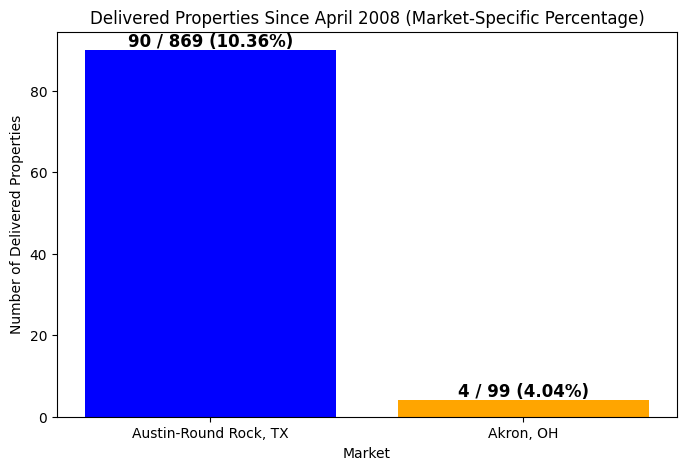

In [15]:
# Delivered properties count
delivered_counts = [len(delivered_Austin), len(delivered_Akron)]
total_counts = [total_properties_austin, total_properties_akron]  # Market-specific totals
markets = ["Austin-Round Rock, TX", "Akron, OH"]

# Create bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(markets, delivered_counts, color=['blue', 'orange'])
for bar, delivered, total in zip(bars, delivered_counts, total_counts):
    percentage = (delivered / total) * 100  # Calculate market-specific percentage
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{delivered} / {total} ({percentage:.2f}%)",  # Format: "Delivered / Total (Percentage%)"
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Customize plot labels and title
plt.xlabel("Market")
plt.ylabel("Number of Delivered Properties")
plt.title("Delivered Properties Since April 2008 (Market-Specific Percentage)")


# Display the plot
plt.show()

In [16]:
delivered_Akron

0  MarketCode MarketName StateCode StateName CountyCode CountyName TractCode  \
0       10420  Akron, OH        OH      Ohio        153     Summit    509000   
2       10420  Akron, OH        OH      Ohio        153     Summit    508301   
11      10420  Akron, OH        OH      Ohio        153     Summit    530902   
18      10420  Akron, OH        OH      Ohio        153     Summit    502500   

0  BlockGroupCode  Latitude Longitude ETAKInd                True Owner  \
0               1  41.07457 -81.49274     NaN                       NaN   
2               1  41.08116 -81.51936     NaN         Bower Development   
11              3  41.08548 -81.43438     NaN  PREMIER DEVELOPMENTS LLC   
18              2  41.06638 -81.48264     NaN  IRG Realty Advisors, LLC   

0          ManagementCompany    ProjID            Submarket  \
0                        NaN  10258733  South Summit County   
2          Bower Development     87610  South Summit County   
11  PREMIER DEVELOPMENTS LLC     47913  South Summit County   
18  IRG Realty Advisors, LLC     51333  South Summit County   

0                     Name             Address       City State    Zip  \
0   797 Residence & Suites     797 E Market St      Akron    OH  44305   
2          Bowery District       156 S Main St      Akron    OH  44308   
11            Colony Hills  558 Colony Park Dr  Tallmadge    OH  44278   
18     East End Residences    1201 E Market St      Akron    OH  44305   

0        Phone YearBuilt Rehab1 Rehab2 Rehab3 Quantity AreaPerUnit Level  \
0   3306175777      2019    NaN    NaN    NaN       60         959     3   
2   3306183469      2020    NaN    NaN    NaN       92         897    12   
11  3308005656      2017    NaN    NaN    NaN       40        1183     2   
18  3308400157      2016    NaN    NaN    NaN      105         842     6   

0  Neighborhood Status Apr-08 May-08 Jun-08 Jul-08 Aug-08 Sep-08 Oct-08  \
0           NaN     LU    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2           NaN     LU    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
11          NaN      S    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18          NaN      S    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

0  Nov-08 Dec-08 Jan-09 Feb-09 Mar-09 Apr-09 May-09 Jun-09 Jul-09 Aug-09  \
0     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
11    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

0  Sep-09 Oct-09 Nov-09 Dec-09 Jan-10 Feb-10 Mar-10 Apr-10 May-10 Jun-10  \
0     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
11    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

0  Jul-10 Aug-10 Sep-10 Oct-10 Nov-10 Dec-10 Jan-11 Feb-11 Mar-11 Apr-11  \
0     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
11    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

0  May-11 Jun-11 Jul-11 Aug-11 Sep-11 Oct-11 Nov-11 Dec-11 Jan-12 Feb-12  \
0     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
11    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
18    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

0  Mar-12 Apr-12 May-12 Jun-12 Jul-12 Aug-12 Sep-12 Oct-12 Nov-12 Dec-12  \
0     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
11    NaN    NaN    NaN    

In [17]:
# Extract relevant columns for delivered properties
delivered_austin_properties = delivered_Austin[["ProjID", "True Owner", "ManagementCompany", "Name", "Market"]]
delivered_akron_properties = delivered_Akron[["ProjID", "True Owner", "ManagementCompany", "Name", "Market"]]

# Combine Austin and Akron delivered properties
delivered_properties_summary = pd.concat([delivered_austin_properties, delivered_akron_properties], ignore_index=True)


Summary of delivered properties in a dataframe

In [18]:
delivered_properties_summary

0     ProjID                   True Owner             ManagementCompany  \
0   10255043       NE Property Management        NE Property Management   
1      19148                    JP Morgan                      Greystar   
2      27065  FrontRange Capital Partners  Alliance Residential Company   
3      19410             AMLI Residential              AMLI Residential   
4      34139             AMLI Residential              AMLI Residential   
..       ...                          ...                           ...   
89     71889  GID Real Estate Investments           Windsor Communities   
90  10258733                          NaN                           NaN   
91     87610            Bower Development             Bower Development   
92     47913     PREMIER DEVELOPMENTS LLC      PREMIER DEVELOPMENTS LLC   
93     51333     IRG Realty Advisors, LLC      IRG Realty Advisors, LLC   

0                      Name                 Market  
0       22 North Apartments  Austin-Round Rock, TX  
1             3500 Westlake  Austin-Round Rock, TX  
2   Agave at South Congress  Austin-Round Rock, TX  
3                  AMLI 300  Austin-Round Rock, TX  
4                 AMLI 5350  Austin-Round Rock, TX  
..                      ...                    ...  
89   Windsor Republic Place  Austin-Round Rock, TX  
90   797 Residence & Suites              Akron, OH  
91          Bowery District              Akron, OH  
92             Colony Hills              Akron, OH  
93      East End Residences              Akron, OH  

[94 rows x 5 columns]

**2. Calculate the average lease-up time for these markets.**
"Lease-up time" is the number of months from delivery to market until the first month when the
property reached 90% occupancy"

In [19]:
#lease up time 2 - taking it as definititon "the period from when a new or renovated property is first launched to when it reaches 90% occupancy"

In [ ]:
occupancy_austin = MSA1_cleaned_sheets["Occ_&_Concession"]
occupancy_akron = MSA2_cleaned_sheets["Occ_&_Concession"]

In [21]:
occupancy_akron.head(3)

0 MarketCode MarketName StateCode StateName CountyCode CountyName TractCode  \
0      10420  Akron, OH        OH      Ohio        153     Summit    509000   
1      10420  Akron, OH        OH      Ohio        153     Summit    530104   
2      10420  Akron, OH        OH      Ohio        153     Summit    508301   

0 BlockGroupCode  Latitude Longitude ETAKInd         True Owner  \
0              1  41.07457 -81.49274     NaN                NaN   
1              4  41.31766 -81.44473     NaN  Gross Residential   
2              1  41.08116 -81.51936     NaN  Bower Development   

0  ManagementCompany    ProjID            Submarket                    Name  \
0                NaN  10258733  South Summit County  797 Residence & Suites   
1  Gross Residential     13558  North Summit County              Arbor Glen   
2  Bower Development     87610  South Summit County         Bowery District   

0             Address       City State    Zip       Phone YearBuilt Rehab1  \
0     797 E Market St      Akron    OH  44305  3306175777      2019    NaN   
1  2639 Arbor Glen Dr  Twinsburg    OH  44087  3309633360      2002    NaN   
2       156 S Main St      Akron    OH  44308  3306183469      2020    NaN   

0 Rehab2 Rehab3 Quantity AreaPerUnit Level Neighborhood Status Apr-08 May-08  \
0    NaN    NaN       60         959     3          NaN     LU    NaN    NaN   
1    NaN    NaN      288        1007     3          NaN      S    NaN    NaN   
2    NaN    NaN       92         897    12          NaN     LU    NaN    NaN   

0 Jun-08 Jul-08 Aug-08 Sep-08 Oct-08 Nov-08 Dec-08 Jan-09 Feb-09 Mar-09  \
0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

0 Apr-09 May-09 Jun-09 Jul-09 Aug-09 Sep-09 Oct-09 Nov-09 Dec-09 Jan-10  \
0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

0 Feb-10 Mar-10 Apr-10 May-10 Jun-10 Jul-10 Aug-10 Sep-10 Oct-10 Nov-10  \
0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

0 Dec-10 Jan-11 Feb-11 Mar-11 Apr-11 May-11 Jun-11 Jul-11 Aug-11 Sep-11  \
0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

0 Oct-11 Nov-11 Dec-11 Jan-12 Feb-12 Mar-12 Apr-12 May-12 Jun-12 Jul-12  \
0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

0 Aug-12 Sep-12 Oct-12 Nov-12 Dec-12 Jan-13 Feb-13 Mar-13 Apr-13 May-13  \
0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1    NaN    NaN    NaN    NaN    NaN    NaN    NaN  0.996  0.941  0.941   
2    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

0 Jun-13 Jul-13 Aug-13 Sep-13 Oct-13 Nov-13 Dec-13 Jan-14 Feb-14 Mar-14  \
0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1  0.941  0.923  0.947  0.961  0.993  0.993  0.993      1  0.989  0.982   
2    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

0 Apr-14 May-14 Jun-14 Jul-14 Aug-14 Sep-14 Oct-14 Nov-14 Dec-14 Jan-15  \
0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1  0.986  0.993      1  0.989  0.989  0.989  0.965  0.965  0.965  0.965   
2    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

0 Feb-15 Mar-15 Apr-15 May-15 Jun-15 Jul-15 Aug-15 Sep-

checking the occupancy columns, and not selecting the concession columns as of now

In [22]:
occupancy_akron.iloc[:, 30:180]

0  Apr-08 May-08 Jun-08 Jul-08 Aug-08 Sep-08 Oct-08 Nov-08 Dec-08 Jan-09  \
0     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3   0.877  0.927  0.927  0.977   0.95  0.961  0.916  0.938  0.972  0.977   
4     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
94    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
95    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
96  0.901   0.93   0.93   0.97  0.936  0.959   0.95   0.95  0.939   0.95   
97  0.989  0.989  0.989  0.996  0.959  0.959      1  0.969  0.969  0.969   
98    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

0  Feb-09 Mar-09 Apr-09 May-09 Jun-09 Jul-09 Aug-09 Sep-09 Oct-09 Nov-09  \
0     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3   0.927  0.927  0.938  0.916    0.9  0.927    0.9  0.916  0.927  0.888   
4     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
94    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
95    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
96  0.936  0.936  0.947  0.924  0.959      1  0.979  0.982  0.973  0.959   
97  0.979  0.969  0.969  0.989      1      1  0.989      1  0.979  0.949   
98    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

0  Dec-09 Jan-10 Feb-10 Mar-10 Apr-10 May-10 Jun-10 Jul-10 Aug-10 Sep-10  \
0     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3   0.927  0.938   0.95  0.888  0.916  0.911  0.916  0.916  0.927  0.938   
4     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
94    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
95    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
96  0.944  0.947   0.95  0.956   0.93   0.95  0.959  0.901  0.909  0.918   
97  0.949  0.959  0.969  0.969  0.949      1  0.989  0.979  0.969  0.979   
98    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

0  Oct-10 Nov-10 Dec-10 Jan-11 Feb-11 Mar-11 Apr-11 May-11 Jun-11 Jul-11  \
0     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3    0.95  0.961  0.972  0.977  0.988  0.961  0.972  0.961  0.961  0.961   
4     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
94    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
95    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
96   0.93  0.918  0.799  0.848   0.86  0.848  0.857  0.901  0.848  0.848   
97  0.969  0.959  0.901  0.959  0.969  0.969  0.979  0.979  0.979      1   
98    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

0  Aug-11 Sep-11 Oct-11 Nov-11 Dec-11 Jan-12 Feb-12 Mar-12 Apr-12 May-12  \
0     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3   0.977  0.977  0.988    0.9  0.972   0.95

In [23]:
def filter_occupancy_rates(df):
    
    # Select only relevant columns up to column index 180 (ignoring concessions)
    filtered_df = df.iloc[:, :180]  # Keep only occupancy rates

    return filtered_df

In [24]:
occupancy_austin = filter_occupancy_rates(MSA1_cleaned_sheets["Occ_&_Concession"])
occupancy_akron = filter_occupancy_rates(MSA2_cleaned_sheets["Occ_&_Concession"])


In [25]:
print(occupancy_austin)

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305              2  30.30917 -97.72881   

In [26]:
def calculate_lease_up_time(delivered_df, occupancy_df, market_name):
    """
    Calculates the average lease-up time for delivered properties in a given market.

    Args:
    delivered_df (pd.DataFrame): DataFrame containing only delivered properties (ProjID-based).
    occupancy_df (pd.DataFrame): Filtered dataset containing only occupancy rates.
    market_name (str): Name of the market for logging.

    Returns:
    float: Average lease-up time for the market.
    """
    lease_up_times = []  # Store lease-up times for each delivered property

    # Keep only properties in occupancy dataset that are in the delivered properties list (ProjID matching)
    delivered_occupancy_df = occupancy_df[occupancy_df["ProjID"].isin(delivered_df["ProjID"])]

    # Iterate through each delivered property
    for index, row in delivered_occupancy_df.iterrows():
        # Extract only occupancy values (from first date column onward)
        occupancy_values = row.iloc[30:].values  # Start from April 2008 - and occupancy values of 150 months

        # Identify first numeric value (ignoring NaN)
        first_valid_index = np.where(~pd.isna(occupancy_values))[0]  # Get indices of valid numbers

        if len(first_valid_index) == 0:
            continue  # Skip if there are no numerical values

        first_valid_index = first_valid_index[0]  # Get first valid index
        first_value = occupancy_values[first_valid_index]  # Get first numerical value

        # Find when occupancy reaches 90% for the first time
        lease_up_index = np.where(occupancy_values[first_valid_index:] >= 0.90)[0]

        if len(lease_up_index) == 0:
            continue  # Skip if never reaches 90%

        lease_up_months = lease_up_index[0] + 1  # Months count starts at 1

        lease_up_times.append(lease_up_months)

    # Compute and return average lease-up time for the market
    avg_lease_up_time = np.mean(lease_up_times) if lease_up_times else None
    print(f"Average Lease-Up Time for {market_name} (Delivered Properties): {avg_lease_up_time:.2f} months")
    return avg_lease_up_time

In [27]:
avg_lease_up_austin = calculate_lease_up_time(delivered_austin_properties, occupancy_austin, "Austin-Round Rock, TX")


Average Lease-Up Time for Austin-Round Rock, TX (Delivered Properties): 10.91 months


In [28]:
avg_lease_up_akron = calculate_lease_up_time(delivered_akron_properties, occupancy_akron, "Akron")


Average Lease-Up Time for Akron (Delivered Properties): 9.00 months


**Visualising the Lease Up times calculated and comparing it for both markets**

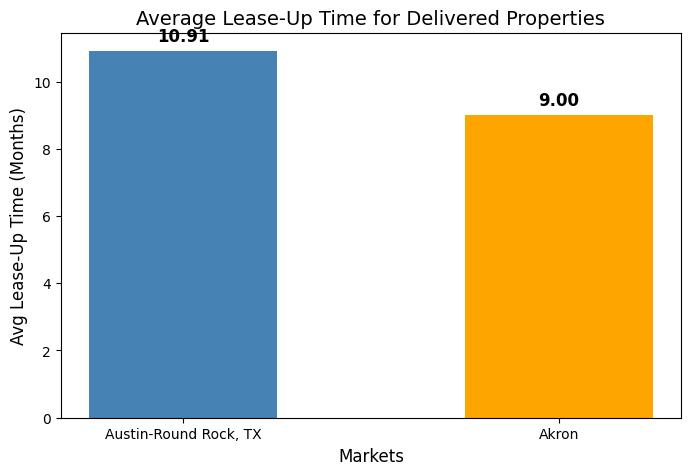

In [29]:
markets = ["Austin-Round Rock, TX", "Akron"]
lease_up_times = [avg_lease_up_austin, avg_lease_up_akron]

# Create a simple and clean bar chart
plt.figure(figsize=(8, 5))
plt.bar(markets, lease_up_times, color=['steelblue', 'orange'], width=0.5)

# Add labels and title
plt.xlabel("Markets", fontsize=12)
plt.ylabel("Avg Lease-Up Time (Months)", fontsize=12)
plt.title("Average Lease-Up Time for Delivered Properties", fontsize=14)

# Display values on bars
for i, v in enumerate(lease_up_times):
    plt.text(i, v + 0.3, f"{v:.2f}", ha='center', fontsize=12, fontweight='bold')

# Show the plot
plt.show()

**3. Determine which properties had negative effective rent growth during lease-up.**

In [30]:
rent_austin = MSA1_cleaned_sheets["Rent"]
rent_akron = MSA2_cleaned_sheets["Rent"]

In [31]:
rent_austin

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305              2  30.30917 -97.72881     NaN   
1        Travis    001716              2  30.36687 -97.79303     NaN   
2        Travis    001860              2  30.45009 -97.64873     NaN   
3        Travis    000604              3  30.28462 -97.74723     NaN   
4    Williamson    020312              2  30.57164 -97.87028     NaN   
..          ...       ...            ...       ...       ...     ...   
864      Travis    001817              1  30.36689 -97.72829     NaN   
865        Hays    010804              3  30.03098 -98.10173     NaN   
866      Travis    001806              3  30.34684  -97.6966     NaN   
867      Travis    002005              1  30.23269 -97.78612     NaN   
868      Travis    001707              2  30.37337 -97.75408     NaN   

0                      True Owner           ManagementCompany    ProjID  \
0                 Privately Owned          MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital           Weller Management     14466   
2      Castle Lanterra Properties    Lincoln Property Company     89519   
3          Texla Housing Partners      Texla Housing Partners     43056   
4          NE Property Management      NE Property Management  10255043   
..                            ...                         ...       ...   
864    Churchill Forge Properties  Churchill Forge Properties     18419   
865      Sendera Investment Group            Merge Management     79577   
866           DTI Investments Inc         DTI Investments Inc     69991   
867            Martine Properties          Martine Properties     88278   
868                 Nitya Capital   Karya Property Management     87479   

0                    Submarket                         Name  \
0            Near North Austin                    108 Place   
1              Far West Austin      10X Living at Grandview   
2    Pflugerville/Wells Branch                1825 Cottages   
3          Downtown/University                     21 Pearl   
4                   Cedar Park          22 North Apartments   
..                         ...                          ...   
864          Near North Austin                    Woodchase   
865                 San Marcos         Woodcreek Apartments   
866       North Central Austin  Woodland Heights Apartments   
867               South Austin            Woods at Manchaca   
868                  Arboretum                    Woodstone   

0                        Address          City State    Zip       Phone  \
0                  108 W 45th St        Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   
3                  911 W 21st St        Austin    TX  78705  5124730808   
4                149 S Bagdad Rd       Leander    TX  78641  5129868727   
..                           ...           ...   ...    ...         ...   
864               8524 Burnet Rd        Austin    TX  78757  5124208341   
865         

For this task, I aimed to identify properties that experienced negative effective rent growth during lease-up. I started by filtering properties that were delivered since April 2008 and matched them with occupancy and rent datasets using "ProjID". My assumption was that occupancy data was complete and accurate, meaning that I could rely on recorded values to track lease-up progress.

Steps I Followed:
Defined Lease-Up Period:

Found the first recorded occupancy (ignoring NaNs).
Identified the first month reaching 90% occupancy as the lease-up completion.
Extracted Rent Data:

Selected rent values during the lease-up period and converted them to numeric.
Checked for Negative Growth Conditions:

Rent dropped at least once (np.diff(rent_values) < 0).
Final rent was lower than initial rent (final_rent < initial_rent).
If both conditions were met, I flagged the property and stored key metrics like Lease_Up_Months, Initial_Rent, and Final_Rent.

My Assumptions & Considerations:
Occupancy and rent data were correctly recorded.
If rent data was missing, trends might not be detected properly.

In [33]:
def identify_negative_rent_growth(delivered_df, occupancy_df, rent_df, market_name):
    """
    Identifies properties with negative effective rent growth during lease-up.

    Args:
    delivered_df (pd.DataFrame): DataFrame of delivered properties.
    occupancy_df (pd.DataFrame): Occupancy dataset (contains % values for each month).
    rent_df (pd.DataFrame): Rent dataset (contains effective rent values).
    market_name (str): Name of the market for logging.

    Returns:
    pd.DataFrame: Properties with negative effective rent growth.
    """

    # Step 1: Keep only delivered properties in occupancy & rent datasets (ProjID matching)
    delivered_occupancy_df = occupancy_df[occupancy_df["ProjID"].isin(delivered_df["ProjID"])].copy()
    delivered_rent_df = rent_df[rent_df["ProjID"].isin(delivered_df["ProjID"])].copy()

    # Step 2: Convert rent columns to numeric to prevent errors
    delivered_rent_df.iloc[:, 30:] = delivered_rent_df.iloc[:, 30:].apply(pd.to_numeric, errors='coerce')

    negative_growth_properties = []  # Store properties with negative rent growth

    # Step 3: Loop through each property to find lease-up months & check rent trends
    for index, row in delivered_occupancy_df.iterrows():
        proj_id = row["ProjID"]

        # Extract occupancy values (from April 2008 onward)
        occupancy_values = row.iloc[30:].values  
        months = occupancy_df.columns[30:]  

        # Step 4: Identify first recorded occupancy (ignore NaNs)
        first_valid_index = np.where(~pd.isna(occupancy_values))[0]

        if len(first_valid_index) == 0:
            continue  # Skip if no valid occupancy data

        first_valid_index = first_valid_index[0]  # First non-NaN occupancy value
        first_value = occupancy_values[first_valid_index]  # First recorded occupancy rate

        # Find when occupancy reaches 90%
        lease_up_index = np.where(occupancy_values[first_valid_index:] >= 0.90)[0]

        if len(lease_up_index) == 0:
            continue  # Skip if never reaches 90%

        lease_up_start = first_valid_index  # Lease-up start month
        lease_up_end = lease_up_index[0] + lease_up_start  # Month when occupancy hits 90%

        # Extract lease-up months
        lease_up_months = months[lease_up_start:lease_up_end + 1]

        # Step 5: Get effective rent values for lease-up period
        rent_row = delivered_rent_df[delivered_rent_df["ProjID"] == proj_id]

        if rent_row.empty:
            continue  # Skip if no rent data

        rent_values = rent_row.iloc[:, 30:].values.flatten()  # Extract all rent values
        rent_values = rent_values[lease_up_start:lease_up_end + 1]  # Select lease-up period

        # ** Convert to numeric & remove NaNs **
        rent_values = pd.to_numeric(rent_values, errors="coerce")
        rent_values = rent_values[~np.isnan(rent_values)]  # Remove NaNs

        if len(rent_values) < 2:
            continue  # Skip if not enough rent data

        initial_rent = rent_values[0]  # First rent value
        final_rent = rent_values[-1]  # Last rent value

        # Step 6: Check for negative effective rent growth conditions
        rent_decreased_anywhere = any(np.diff(rent_values) < 0)  # Rent dropped at least once
        rent_never_recovered = final_rent < initial_rent  # Final rent still below first recorded rent

        if rent_decreased_anywhere and rent_never_recovered:
            negative_growth_properties.append({
                "ProjID": proj_id,
                "Market": market_name,
                "Lease_Up_Months": len(lease_up_months),
                "Initial_Rent": initial_rent,
                "Final_Rent": final_rent,
                "Rent_Change": final_rent - initial_rent
            })

    # Convert list to DataFrame
    negative_growth_df = pd.DataFrame(negative_growth_properties)

    print(f"Market: {market_name} | Properties with Negative Effective Rent Growth: {len(negative_growth_df)}")
    
    return negative_growth_df

In [34]:
negative_effrent_austin = identify_negative_rent_growth(delivered_Austin, occupancy_austin, MSA1_cleaned_sheets["Rent"], "Austin-Round Rock, TX")
negative_effrent_akron = identify_negative_rent_growth(delivered_Akron, occupancy_akron, MSA2_cleaned_sheets["Rent"], "Akron, OH")


Market: Austin-Round Rock, TX | Properties with Negative Effective Rent Growth: 23
Market: Akron, OH | Properties with Negative Effective Rent Growth: 0


Found akron discovered with no properties with negative effective rent during lease up time according to my assumptions

In [35]:
negative_effrent_akron

Empty DataFrame
Columns: []
Index: []

In [36]:
negative_effrent_austin

ProjID                 Market  Lease_Up_Months  Initial_Rent  \
0      19410  Austin-Round Rock, TX               20        2012.0   
1      34139  Austin-Round Rock, TX                6        1428.0   
2      19035  Austin-Round Rock, TX                6        2479.0   
3      53644  Austin-Round Rock, TX                9        1109.0   
4      26420  Austin-Round Rock, TX                6        1138.0   
5      37407  Austin-Round Rock, TX               32        1693.0   
6      19170  Austin-Round Rock, TX               14        1016.0   
7      26404  Austin-Round Rock, TX               13         997.0   
8      26406  Austin-Round Rock, TX                6        2154.0   
9      19624  Austin-Round Rock, TX                9        1018.0   
10     19837  Austin-Round Rock, TX               21        1188.0   
11  10255580  Austin-Round Rock, TX                6        1161.0   
12     41412  Austin-Round Rock, TX                7         930.0   
13     51760  Austin-Round Rock, TX               17        1632.0   
14     26327  Austin-Round Rock, TX               16        1243.0   
15     26425  Austin-Round Rock, TX                8        1429.0   
16     19639  Austin-Round Rock, TX                4        1864.0   
17     37912  Austin-Round Rock, TX               17        2448.0   
18     43630  Austin-Round Rock, TX               20        1717.0   
19     71887  Austin-Round Rock, TX                9        1141.0   
20     69751  Austin-Round Rock, TX                6        1235.0   
21     23047  Austin-Round Rock, TX                7        1266.0   
22     30455  Austin-Round Rock, TX               16        1141.0   

    Final_Rent  Rent_Change  
0       1999.0        -13.0  
1       1414.0        -14.0  
2       2069.0       -410.0  
3       1049.0        -60.0  
4        954.0       -184.0  
5       1659.0        -34.0  
6        839.0       -177.0  
7        849.0       -148.0  
8       2117.0        -37.0  
9       1003.0        -15.0  
10      1164.0        -24.0  
11      1158.0         -3.0  
12       917.0        -13.0  
13      1576.0        -56.0  
14      1125.0       -118.0  
15      1366.0        -63.0  
16      1849.0        -15.0  
17      1987.0       -461.0  
18      1650.0        -67.0  
19      1128.0        -13.0  
20      1209.0        -26.0  
21      1250.0        -16.0  
22      1054.0        -87.0

**4. Feature Engineering Challenge: Create at least 5 additional features from this dataset
that could improve predictive modeling of lease-up time. Explain your reasoning for each
feature.**

In [37]:
#feature engineering

In [38]:
MSA1_cleaned_sheets['Property_Status'].columns

Index(['MarketCode', 'MarketName', 'StateCode', 'StateName', 'CountyCode',
       'CountyName', 'TractCode', 'BlockGroupCode', 'Latitude', 'Longitude',
       ...
       'Mar-20', 'Apr-20', 'May-20', 'Jun-20', 'Jul-20', 'Aug-20', 'Sep-20',
       'First_Status', 'First_Status_Date', 'First_LU_Date'],
      dtype='object', name=0, length=183)

In [39]:
MSA2_cleaned_sheets.keys()

dict_keys(['Rent', 'Occ_&_Concession', 'Asset_Class', 'Property_Status'])

**Feature 1: Estimated Property Size
For my first engineered feature, I created Estimated Property Size, which provides an approximate total property area based on available unit data.
Estimated Property Size = 
(Quanitity * AreaPerUnit)/Level

Assumption:
Units are evenly distributed across floors (Level column).
AreaPerUnit represents the average unit size in square feet.
If Level is zero or missing, I exclude that row (np.nan) or simply put level as 1.**


In [40]:
def calculate_estimated_property_size(df):
    """
    Estimates Property Size by dividing Quantity by Levels (assuming equal distribution of units)
    and multiplying by AreaPerUnit.

    Args:
    df (pd.DataFrame): Full dataset (e.g., Rent dataset).

    Returns:
    pd.DataFrame: Updated DataFrame with new 'Estimated_Property_Size' column.
    """
    df["Estimated_Property_Size"] = df.apply(
        lambda row: (row["Quantity"] / row["Level"]) * row["AreaPerUnit"] 
        if pd.notna(row["Quantity"]) and pd.notna(row["AreaPerUnit"]) and row["Level"] > 0 else np.nan, axis=1
    )
    return df


In [41]:
MSA1_cleaned_sheets["Rent"] = calculate_estimated_property_size(MSA1_cleaned_sheets["Rent"])
MSA2_cleaned_sheets["Rent"] = calculate_estimated_property_size(MSA2_cleaned_sheets["Rent"])


In [42]:
print(MSA1_cleaned_sheets['Rent'])

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305              2  30.30917 -97.72881   

In [592]:
print(MSA2_cleaned_sheets['Rent'])

0  MarketCode MarketName StateCode StateName CountyCode CountyName TractCode  \
0       10420  Akron, OH        OH      Ohio        153     Summit    509000   
1       10420  Akron, OH        OH      Ohio        153     Summit    530104   
2       10420  Akron, OH        OH      Ohio        153     Summit    508301   
3       10420  Akron, OH        OH      Ohio        153     Summit    530603   
4       10420  Akron, OH        OH      Ohio        153     Summit    530401   
..        ...        ...       ...       ...        ...        ...       ...   
94      10420  Akron, OH        OH      Ohio        133    Portage    600800   
95      10420  Akron, OH        OH      Ohio        133    Portage    600401   
96      10420  Akron, OH        OH      Ohio        153     Summit    506100   
97      10420  Akron, OH        OH      Ohio        153     Summit    530603   
98      10420  Akron, OH        OH      Ohio        153     Summit    520106   

0  BlockGroupCode  Latitude Longitude E

**Create The Box plot to view the distibution of Est. Property Size feature**

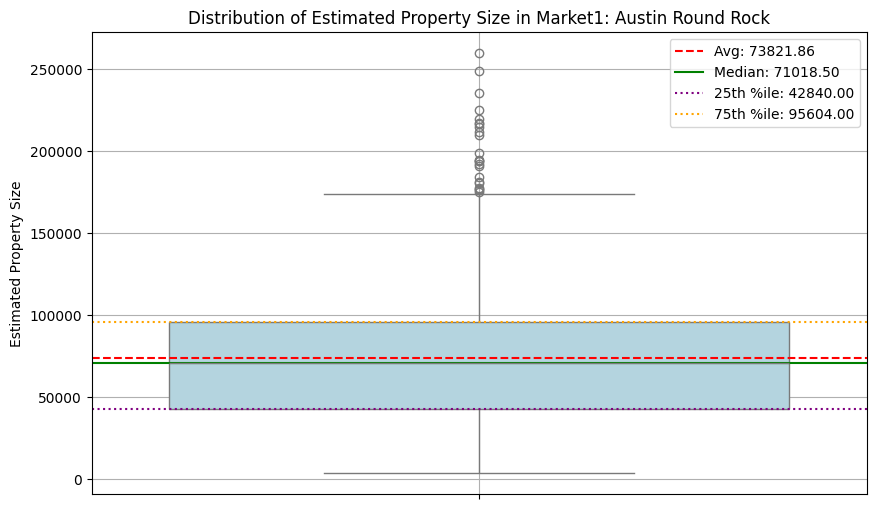

In [43]:
import seaborn as sns
df_1 = MSA1_cleaned_sheets['Rent']

# Calculate statistics
mean_value = df_1['Estimated_Property_Size'].mean()
q25 = np.percentile(df_1['Estimated_Property_Size'].dropna(), 25)
q75 = np.percentile(df_1['Estimated_Property_Size'].dropna(), 75)
median_value = np.median(df_1['Estimated_Property_Size'].dropna())

# Create Box Plot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(y=df_1['Estimated_Property_Size'], color="lightblue")

# Add annotations
plt.axhline(mean_value, color='r', linestyle='--', label=f'Avg: {mean_value:.2f}')
plt.axhline(median_value, color='g', linestyle='-', label=f'Median: {median_value:.2f}')
plt.axhline(q25, color='purple', linestyle=':', label=f'25th %ile: {q25:.2f}')
plt.axhline(q75, color='orange', linestyle=':', label=f'75th %ile: {q75:.2f}')

# Labels and legend
plt.title('Distribution of Estimated Property Size in Market1: Austin Round Rock')
plt.ylabel('Estimated Property Size')
plt.legend(loc="upper right")
plt.grid(True)

plt.show()


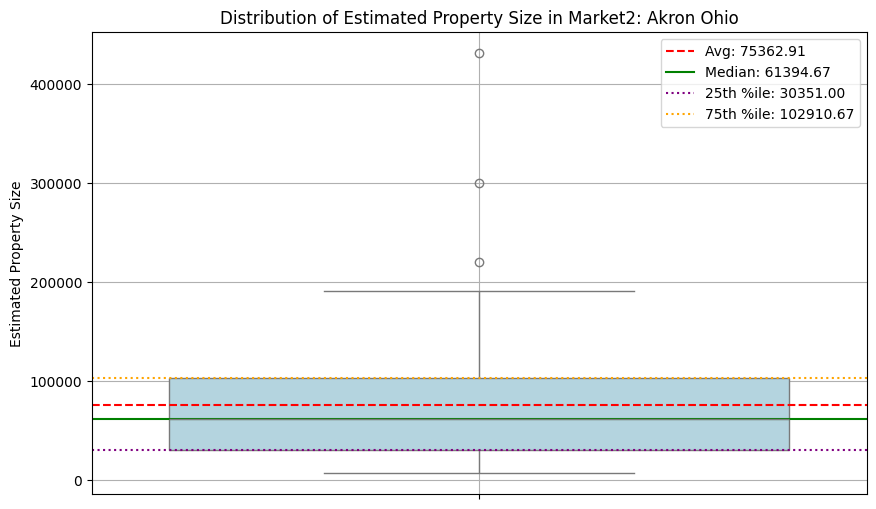

In [594]:
import seaborn as sns
df_2 = MSA2_cleaned_sheets['Rent']

# Calculate statistics
mean_value = df_2['Estimated_Property_Size'].mean()
q25 = np.percentile(df_2['Estimated_Property_Size'].dropna(), 25)
q75 = np.percentile(df_2['Estimated_Property_Size'].dropna(), 75)
median_value = np.median(df_2['Estimated_Property_Size'].dropna())

# Create Box Plot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(y=df_2['Estimated_Property_Size'], color="lightblue")

# Add annotations
plt.axhline(mean_value, color='r', linestyle='--', label=f'Avg: {mean_value:.2f}')
plt.axhline(median_value, color='g', linestyle='-', label=f'Median: {median_value:.2f}')
plt.axhline(q25, color='purple', linestyle=':', label=f'25th %ile: {q25:.2f}')
plt.axhline(q75, color='orange', linestyle=':', label=f'75th %ile: {q75:.2f}')

# Labels and legend
plt.title('Distribution of Estimated Property Size in Market2: Akron Ohio')
plt.ylabel('Estimated Property Size')
plt.legend(loc="upper right")
plt.grid(True)

plt.show()


**FEATURE 2 : MARKET AND SUBMARKET AVERAGE USING ASSET CLASS SHEET IN EXCEL**

Grade Mapping

In [44]:
'''Grade	Numeric Score
A+	5.0
A	4.5
B+	4.0
B	3.5
B-	3.0
C+	2.5
C	2.0
C-	1.5
'''

'Grade\tNumeric Score\nA+\t5.0\nA\t4.5\nB+\t4.0\nB\t3.5\nB-\t3.0\nC+\t2.5\nC\t2.0\nC-\t1.5\n'

In [45]:
prop_market_grade_cols_1 = MSA1_cleaned_sheets['Asset_Class'].iloc[:, 30:180]

In [46]:
prop_market_grade_cols_1

0   Apr-08 May-08 Jun-08 Jul-08 Aug-08 Sep-08 Oct-08 Nov-08 Dec-08 Jan-09  \
0      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1       A+     A+     A+     A+     A+     A+     A+     A+     A+     A+   
2       B+     B+     B+      B      B      B      A      A      A     B+   
3      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
864     C+     C+     C+     C+     C+     C+     C+     C+     C+      C   
865    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
866    NaN    NaN      C      C      C      C     C-     C-     C-      C   
867    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
868     A-     A-     A-     B+     B+     B+     B+     B+     B+      B   

0   Feb-09 Mar-09 Apr-09 May-09 Jun-09 Jul-09 Aug-09 Sep-09 Oct-09 Nov-09  \
0      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1       A+     A+     A+     A+     A+     A+     A+     A+     A+     A+   
2       B+     B+     B+     B+     B+     B+     B+     B+     B+     B+   
3      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
864      C      C     C-     C-     C-      C      C      C      C      C   
865    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
866      C      C     C+     C+     C+      C      C      C      C      C   
867    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
868      B      B     B+     B+     B+      A      A      A     A-     A-   

0   Dec-09 Jan-10 Feb-10 Mar-10 Apr-10 May-10 Jun-10 Jul-10 Aug-10 Sep-10  \
0      NaN    NaN    NaN    NaN    NaN    NaN      A    NaN    NaN    NaN   
1       A+     A+     A+     A+     A+     A+     A+     A+     A+     A+   
2      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
864      C     C-     C-     C-     C-     C-     C-     C-     C-     C-   
865    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
866      C     C+     C+     C+     C+     C+     C+     C+     C+     C+   
867    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
868     A-     B+     B+     B+     B+     B+     B+     A-     A-     A-   

0   Oct-10 Nov-10 Dec-10 Jan-11 Feb-11 Mar-11 Apr-11 May-11 Jun-11 Jul-11  \
0      NaN    NaN    NaN    NaN    NaN    NaN     B+    NaN    NaN    NaN   
1       A+     A+     A+     A+     A+     A+     A+     A+     A+     A+   
2      NaN    NaN    NaN    NaN    NaN    NaN    NaN     A-     A-     B-   
3      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
864     C+     C+     C+      C      C      C      C      C      C      C   
865    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
866     C+     C+     C+      C      C      C      C      C      C      C   
867    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
868      A      A      A     A-     A-     A-     B+     B+     B+     B+   

0   Aug-11 Sep-11 Oct-11 Nov-11 Dec-11 Jan-12 Feb-12 Mar-12 Apr-12 May-12  \
0      NaN    NaN    NaN    NaN    NaN     B+    NaN    NaN    NaN    NaN   
1       A+     A+     A+     A+     A+     A+     A+     A+     A+     A+   
2       B-     B-      B      B      B      B      B      B      B   

In [47]:
prop_submarket_grade_cols_1 = MSA1_cleaned_sheets['Asset_Class'].iloc[:, 180:330]

In [48]:
prop_submarket_grade_cols_1

0   Apr-08 May-08 Jun-08 Jul-08 Aug-08 Sep-08 Oct-08 Nov-08 Dec-08 Jan-09  \
0      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1       A+     A+     A+     A+     A+     A+     A+     A+     A+      A   
2        B      B      B      B      B      B     B+     B+     B+      B   
3      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
864     B-     B-     B-     B-     B-     B-     B-     B-     B-     B-   
865    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
866    NaN    NaN      C      C      C      C     C-     C-     C-      C   
867    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
868     A-     A-     A-     B+     B+     B+     A-     A-     A-     B+   

0   Feb-09 Mar-09 Apr-09 May-09 Jun-09 Jul-09 Aug-09 Sep-09 Oct-09 Nov-09  \
0      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1        A      A     A+     A+     A+      A      A      A     A-     A-   
2        B      B     B-     B-     B-      B      B      B      B      B   
3      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
864     B-     B-     C+     C+     C+      B      B      B     B-     B-   
865    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
866      C      C     C+     C+     C+     C+     C+     C+     C+     C+   
867    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
868     B+     B+     B+     B+     B+     A-     A-     A-     A-     A-   

0   Dec-09 Jan-10 Feb-10 Mar-10 Apr-10 May-10 Jun-10 Jul-10 Aug-10 Sep-10  \
0      NaN    NaN    NaN    NaN    NaN    NaN     A+    NaN    NaN    NaN   
1       A-     A-     A-     A-      A      A      A     A-     A-     A-   
2      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
864     B-     B-     B-     B-     B-     B-     B-     B-     B-     B-   
865    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
866     C+     C+     C+     C+     C+     C+     C+     C+     C+     C+   
867    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
868     A-     A-     A-     A-     A-     A-     A-      A      A      A   

0   Oct-10 Nov-10 Dec-10 Jan-11 Feb-11 Mar-11 Apr-11 May-11 Jun-11 Jul-11  \
0      NaN    NaN    NaN    NaN    NaN    NaN     A+    NaN    NaN    NaN   
1       A-     A-     A-     B+     B+     B+     A-     A-     A-     A-   
2      NaN    NaN    NaN    NaN    NaN    NaN    NaN      B      B     B-   
3      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
864      B      B      B      B      B      B      B      B      B      B   
865    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
866     C+     C+     C+      C      C      C     C+     C+     C+     C+   
867    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
868      A      A      A     A-     A-     A-     A-     A-     A-     A-   

0   Aug-11 Sep-11 Oct-11 Nov-11 Dec-11 Jan-12 Feb-12 Mar-12 Apr-12 May-12  \
0      NaN    NaN    NaN    NaN    NaN      A    NaN    NaN    NaN    NaN   
1       A-     A-     B+     B+     B+     A-     A-     A-     B+     B+   
2       B-     B-     B-     B-     B-     B-     B-     B-     B-   

In [49]:
grade_mapping = {
    'A+': 5.0, 'A': 4.5, 'A-': 4.0,
    'B+': 3.5, 'B': 3.0, 'B-': 2.5,
    'C+': 2.0, 'C': 1.5, 'C-': 1.0,
    'D': 0.5, 'F': 0.0
}

In [50]:
market_grades_numeric = prop_market_grade_cols_1.replace(grade_mapping)
submarket_grades_numeric = prop_submarket_grade_cols_1.replace(grade_mapping)


/var/folders/z2/fm7clqhj5855cx6jvwxrpyc00000gn/T/ipykernel_24614/868366264.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  market_grades_numeric = prop_market_grade_cols_1.replace(grade_mapping)
/var/folders/z2/fm7clqhj5855cx6jvwxrpyc00000gn/T/ipykernel_24614/868366264.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  submarket_grades_numeric = prop_submarket_grade_cols_1.replace(grade_mapping)


In [51]:
market_grades_numeric

0    Apr-08  May-08  Jun-08  Jul-08  Aug-08  Sep-08  Oct-08  Nov-08  Dec-08  \
0       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1       5.0     5.0     5.0     5.0     5.0     5.0     5.0     5.0     5.0   
2       3.5     3.5     3.5     3.0     3.0     3.0     4.5     4.5     4.5   
3       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
864     2.0     2.0     2.0     2.0     2.0     2.0     2.0     2.0     2.0   
865     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
866     NaN     NaN     1.5     1.5     1.5     1.5     1.0     1.0     1.0   
867     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
868     4.0     4.0     4.0     3.5     3.5     3.5     3.5     3.5     3.5   

0    Jan-09  Feb-09  Mar-09  Apr-09  May-09  Jun-09  Jul-09  Aug-09  Sep-09  \
0       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1       5.0     5.0     5.0     5.0     5.0     5.0     5.0     5.0     5.0   
2       3.5     3.5     3.5     3.5     3.5     3.5     3.5     3.5     3.5   
3       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
864     1.5     1.5     1.5     1.0     1.0     1.0     1.5     1.5     1.5   
865     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
866     1.5     1.5     1.5     2.0     2.0     2.0     1.5     1.5     1.5   
867     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
868     3.0     3.0     3.0     3.5     3.5     3.5     4.5     4.5     4.5   

0    Oct-09  Nov-09  Dec-09  Jan-10  Feb-10  Mar-10  Apr-10  May-10  Jun-10  \
0       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     4.5   
1       5.0     5.0     5.0     5.0     5.0     5.0     5.0     5.0     5.0   
2       3.5     3.5     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
864     1.5     1.5     1.5     1.0     1.0     1.0     1.0     1.0     1.0   
865     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
866     1.5     1.5     1.5     2.0     2.0     2.0     2.0     2.0     2.0   
867     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
868     4.0     4.0     4.0     3.5     3.5     3.5     3.5     3.5     3.5   

0    Jul-10  Aug-10  Sep-10  Oct-10  Nov-10  Dec-10  Jan-11  Feb-11  Mar-11  \
0       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1       5.0     5.0     5.0     5.0     5.0     5.0     5.0     5.0     5.0   
2       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
864     1.0     1.0     1.0     2.0     2.0     2.0     1.5     1.5     1.5   
865     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
866     2.0     2.0     2.0     2.0     2.0     2.0     1.5     1.5     1.5   
867     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
868     4.0     4.0     4.0     4.5     4.5     4.5     4.0     4.0     4.0   

0    Apr-11  May-11  Jun-11  Jul-11  Aug-11  Sep-11  Oct-11  Nov-11  Dec-11  \
0       3.5     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1       5.0     5.0     5.0     5.0     5.0   

In [52]:
submarket_grades_numeric

0    Apr-08  May-08  Jun-08  Jul-08  Aug-08  Sep-08  Oct-08  Nov-08  Dec-08  \
0       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1       5.0     5.0     5.0     5.0     5.0     5.0     5.0     5.0     5.0   
2       3.0     3.0     3.0     3.0     3.0     3.0     3.5     3.5     3.5   
3       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
864     2.5     2.5     2.5     2.5     2.5     2.5     2.5     2.5     2.5   
865     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
866     NaN     NaN     1.5     1.5     1.5     1.5     1.0     1.0     1.0   
867     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
868     4.0     4.0     4.0     3.5     3.5     3.5     4.0     4.0     4.0   

0    Jan-09  Feb-09  Mar-09  Apr-09  May-09  Jun-09  Jul-09  Aug-09  Sep-09  \
0       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1       4.5     4.5     4.5     5.0     5.0     5.0     4.5     4.5     4.5   
2       3.0     3.0     3.0     2.5     2.5     2.5     3.0     3.0     3.0   
3       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
864     2.5     2.5     2.5     2.0     2.0     2.0     3.0     3.0     3.0   
865     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
866     1.5     1.5     1.5     2.0     2.0     2.0     2.0     2.0     2.0   
867     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
868     3.5     3.5     3.5     3.5     3.5     3.5     4.0     4.0     4.0   

0    Oct-09  Nov-09  Dec-09  Jan-10  Feb-10  Mar-10  Apr-10  May-10  Jun-10  \
0       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     5.0   
1       4.0     4.0     4.0     4.0     4.0     4.0     4.5     4.5     4.5   
2       3.0     3.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
864     2.5     2.5     2.5     2.5     2.5     2.5     2.5     2.5     2.5   
865     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
866     2.0     2.0     2.0     2.0     2.0     2.0     2.0     2.0     2.0   
867     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
868     4.0     4.0     4.0     4.0     4.0     4.0     4.0     4.0     4.0   

0    Jul-10  Aug-10  Sep-10  Oct-10  Nov-10  Dec-10  Jan-11  Feb-11  Mar-11  \
0       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1       4.0     4.0     4.0     4.0     4.0     4.0     3.5     3.5     3.5   
2       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
864     2.5     2.5     2.5     3.0     3.0     3.0     3.0     3.0     3.0   
865     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
866     2.0     2.0     2.0     2.0     2.0     2.0     1.5     1.5     1.5   
867     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
868     4.5     4.5     4.5     4.5     4.5     4.5     4.0     4.0     4.0   

0    Apr-11  May-11  Jun-11  Jul-11  Aug-11  Sep-11  Oct-11  Nov-11  Dec-11  \
0       5.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1       4.0     4.0     4.0     4.0     4.0   

In [53]:
MSA1_cleaned_sheets['Asset_Class']['Market_Grade_Avg'] = market_grades_numeric.mean(axis=1, skipna=True)


In [54]:
MSA1_cleaned_sheets['Asset_Class']

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305              2  30.30917 -97.72881     NaN   
1        Travis    001716              2  30.36687 -97.79303     NaN   
2        Travis    001860              2  30.45009 -97.64873     NaN   
3        Travis    000604              3  30.28462 -97.74723     NaN   
4    Williamson    020312              2  30.57164 -97.87028     NaN   
..          ...       ...            ...       ...       ...     ...   
864      Travis    001817              1  30.36689 -97.72829     NaN   
865        Hays    010804              3  30.03098 -98.10173     NaN   
866      Travis    001806              3  30.34684  -97.6966     NaN   
867      Travis    002005              1  30.23269 -97.78612     NaN   
868      Travis    001707              2  30.37337 -97.75408     NaN   

0                      True Owner           ManagementCompany    ProjID  \
0                 Privately Owned          MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital           Weller Management     14466   
2      Castle Lanterra Properties    Lincoln Property Company     89519   
3          Texla Housing Partners      Texla Housing Partners     43056   
4          NE Property Management      NE Property Management  10255043   
..                            ...                         ...       ...   
864    Churchill Forge Properties  Churchill Forge Properties     18419   
865      Sendera Investment Group            Merge Management     79577   
866           DTI Investments Inc         DTI Investments Inc     69991   
867            Martine Properties          Martine Properties     88278   
868                 Nitya Capital   Karya Property Management     87479   

0                    Submarket                         Name  \
0            Near North Austin                    108 Place   
1              Far West Austin      10X Living at Grandview   
2    Pflugerville/Wells Branch                1825 Cottages   
3          Downtown/University                     21 Pearl   
4                   Cedar Park          22 North Apartments   
..                         ...                          ...   
864          Near North Austin                    Woodchase   
865                 San Marcos         Woodcreek Apartments   
866       North Central Austin  Woodland Heights Apartments   
867               South Austin            Woods at Manchaca   
868                  Arboretum                    Woodstone   

0                        Address          City State    Zip       Phone  \
0                  108 W 45th St        Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   
3                  911 W 21st St        Austin    TX  78705  5124730808   
4                149 S Bagdad Rd       Leander    TX  78641  5129868727   
..                           ...           ...   ...    ...         ...   
864               8524 Burnet Rd        Austin    TX  78757  5124208341   
865         

In [55]:
MSA1_cleaned_sheets['Asset_Class']['SubMarket_Grade_Avg'] = submarket_grades_numeric.mean(axis=1, skipna=True)


In [56]:
MSA1_cleaned_sheets['Asset_Class']

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305              2  30.30917 -97.72881     NaN   
1        Travis    001716              2  30.36687 -97.79303     NaN   
2        Travis    001860              2  30.45009 -97.64873     NaN   
3        Travis    000604              3  30.28462 -97.74723     NaN   
4    Williamson    020312              2  30.57164 -97.87028     NaN   
..          ...       ...            ...       ...       ...     ...   
864      Travis    001817              1  30.36689 -97.72829     NaN   
865        Hays    010804              3  30.03098 -98.10173     NaN   
866      Travis    001806              3  30.34684  -97.6966     NaN   
867      Travis    002005              1  30.23269 -97.78612     NaN   
868      Travis    001707              2  30.37337 -97.75408     NaN   

0                      True Owner           ManagementCompany    ProjID  \
0                 Privately Owned          MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital           Weller Management     14466   
2      Castle Lanterra Properties    Lincoln Property Company     89519   
3          Texla Housing Partners      Texla Housing Partners     43056   
4          NE Property Management      NE Property Management  10255043   
..                            ...                         ...       ...   
864    Churchill Forge Properties  Churchill Forge Properties     18419   
865      Sendera Investment Group            Merge Management     79577   
866           DTI Investments Inc         DTI Investments Inc     69991   
867            Martine Properties          Martine Properties     88278   
868                 Nitya Capital   Karya Property Management     87479   

0                    Submarket                         Name  \
0            Near North Austin                    108 Place   
1              Far West Austin      10X Living at Grandview   
2    Pflugerville/Wells Branch                1825 Cottages   
3          Downtown/University                     21 Pearl   
4                   Cedar Park          22 North Apartments   
..                         ...                          ...   
864          Near North Austin                    Woodchase   
865                 San Marcos         Woodcreek Apartments   
866       North Central Austin  Woodland Heights Apartments   
867               South Austin            Woods at Manchaca   
868                  Arboretum                    Woodstone   

0                        Address          City State    Zip       Phone  \
0                  108 W 45th St        Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   
3                  911 W 21st St        Austin    TX  78705  5124730808   
4                149 S Bagdad Rd       Leander    TX  78641  5129868727   
..                           ...           ...   ...    ...         ...   
864               8524 Burnet Rd        Austin    TX  78757  5124208341   
865         

In [608]:
MSA1_cleaned_sheets['Asset_Class'].describe

<bound method NDFrame.describe of 0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305    

In [57]:
MSA1_cleaned_sheets['Asset_Class'].iloc[:, 480:]

0    Market_Grade_Avg  SubMarket_Grade_Avg
0            2.865591             3.913978
1            4.910000             3.510000
2            3.710317             2.857143
3            3.279070             5.000000
4            3.100000             2.100000
..                ...                  ...
864          1.660000             2.730000
865          4.363636             2.454545
866          1.804054             1.854730
867          1.500000             2.815789
868          3.380435             3.489130

[869 rows x 2 columns]

ROUNDING OF THE AVERAGE GRADES ASSOCIATED WITH EACH PROPERTIES 

In [58]:


# Keep first 30 columns and last 2 columns
MSA1_cleaned_sheets['Asset_Class'] = pd.concat([
    MSA1_cleaned_sheets['Asset_Class'].iloc[:, :30],  # First 30 columns
    MSA1_cleaned_sheets['Asset_Class'].iloc[:, -2:]  # Last 2 columns
], axis=1)  # Concatenating along columns


In [59]:
MSA1_cleaned_sheets['Asset_Class']

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305              2  30.30917 -97.72881     NaN   
1        Travis    001716              2  30.36687 -97.79303     NaN   
2        Travis    001860              2  30.45009 -97.64873     NaN   
3        Travis    000604              3  30.28462 -97.74723     NaN   
4    Williamson    020312              2  30.57164 -97.87028     NaN   
..          ...       ...            ...       ...       ...     ...   
864      Travis    001817              1  30.36689 -97.72829     NaN   
865        Hays    010804              3  30.03098 -98.10173     NaN   
866      Travis    001806              3  30.34684  -97.6966     NaN   
867      Travis    002005              1  30.23269 -97.78612     NaN   
868      Travis    001707              2  30.37337 -97.75408     NaN   

0                      True Owner           ManagementCompany    ProjID  \
0                 Privately Owned          MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital           Weller Management     14466   
2      Castle Lanterra Properties    Lincoln Property Company     89519   
3          Texla Housing Partners      Texla Housing Partners     43056   
4          NE Property Management      NE Property Management  10255043   
..                            ...                         ...       ...   
864    Churchill Forge Properties  Churchill Forge Properties     18419   
865      Sendera Investment Group            Merge Management     79577   
866           DTI Investments Inc         DTI Investments Inc     69991   
867            Martine Properties          Martine Properties     88278   
868                 Nitya Capital   Karya Property Management     87479   

0                    Submarket                         Name  \
0            Near North Austin                    108 Place   
1              Far West Austin      10X Living at Grandview   
2    Pflugerville/Wells Branch                1825 Cottages   
3          Downtown/University                     21 Pearl   
4                   Cedar Park          22 North Apartments   
..                         ...                          ...   
864          Near North Austin                    Woodchase   
865                 San Marcos         Woodcreek Apartments   
866       North Central Austin  Woodland Heights Apartments   
867               South Austin            Woods at Manchaca   
868                  Arboretum                    Woodstone   

0                        Address          City State    Zip       Phone  \
0                  108 W 45th St        Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   
3                  911 W 21st St        Austin    TX  78705  5124730808   
4                149 S Bagdad Rd       Leander    TX  78641  5129868727   
..                           ...           ...   ...    ...         ...   
864               8524 Burnet Rd        Austin    TX  78757  5124208341   
865         

In [60]:
MSA1_cleaned_sheets['Asset_Class']['Market_Grade_Avg'] = (
    MSA1_cleaned_sheets['Asset_Class']['Market_Grade_Avg'].round(1) * 2
).round() / 2

In [61]:
MSA1_cleaned_sheets['Asset_Class']

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305              2  30.30917 -97.72881     NaN   
1        Travis    001716              2  30.36687 -97.79303     NaN   
2        Travis    001860              2  30.45009 -97.64873     NaN   
3        Travis    000604              3  30.28462 -97.74723     NaN   
4    Williamson    020312              2  30.57164 -97.87028     NaN   
..          ...       ...            ...       ...       ...     ...   
864      Travis    001817              1  30.36689 -97.72829     NaN   
865        Hays    010804              3  30.03098 -98.10173     NaN   
866      Travis    001806              3  30.34684  -97.6966     NaN   
867      Travis    002005              1  30.23269 -97.78612     NaN   
868      Travis    001707              2  30.37337 -97.75408     NaN   

0                      True Owner           ManagementCompany    ProjID  \
0                 Privately Owned          MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital           Weller Management     14466   
2      Castle Lanterra Properties    Lincoln Property Company     89519   
3          Texla Housing Partners      Texla Housing Partners     43056   
4          NE Property Management      NE Property Management  10255043   
..                            ...                         ...       ...   
864    Churchill Forge Properties  Churchill Forge Properties     18419   
865      Sendera Investment Group            Merge Management     79577   
866           DTI Investments Inc         DTI Investments Inc     69991   
867            Martine Properties          Martine Properties     88278   
868                 Nitya Capital   Karya Property Management     87479   

0                    Submarket                         Name  \
0            Near North Austin                    108 Place   
1              Far West Austin      10X Living at Grandview   
2    Pflugerville/Wells Branch                1825 Cottages   
3          Downtown/University                     21 Pearl   
4                   Cedar Park          22 North Apartments   
..                         ...                          ...   
864          Near North Austin                    Woodchase   
865                 San Marcos         Woodcreek Apartments   
866       North Central Austin  Woodland Heights Apartments   
867               South Austin            Woods at Manchaca   
868                  Arboretum                    Woodstone   

0                        Address          City State    Zip       Phone  \
0                  108 W 45th St        Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   
3                  911 W 21st St        Austin    TX  78705  5124730808   
4                149 S Bagdad Rd       Leander    TX  78641  5129868727   
..                           ...           ...   ...    ...         ...   
864               8524 Burnet Rd        Austin    TX  78757  5124208341   
865         

In [62]:
MSA1_cleaned_sheets['Asset_Class']['SubMarket_Grade_Avg'] = (
    MSA1_cleaned_sheets['Asset_Class']['SubMarket_Grade_Avg'].round(1) * 2
).round() / 2

In [63]:
MSA1_cleaned_sheets['Asset_Class']

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305              2  30.30917 -97.72881     NaN   
1        Travis    001716              2  30.36687 -97.79303     NaN   
2        Travis    001860              2  30.45009 -97.64873     NaN   
3        Travis    000604              3  30.28462 -97.74723     NaN   
4    Williamson    020312              2  30.57164 -97.87028     NaN   
..          ...       ...            ...       ...       ...     ...   
864      Travis    001817              1  30.36689 -97.72829     NaN   
865        Hays    010804              3  30.03098 -98.10173     NaN   
866      Travis    001806              3  30.34684  -97.6966     NaN   
867      Travis    002005              1  30.23269 -97.78612     NaN   
868      Travis    001707              2  30.37337 -97.75408     NaN   

0                      True Owner           ManagementCompany    ProjID  \
0                 Privately Owned          MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital           Weller Management     14466   
2      Castle Lanterra Properties    Lincoln Property Company     89519   
3          Texla Housing Partners      Texla Housing Partners     43056   
4          NE Property Management      NE Property Management  10255043   
..                            ...                         ...       ...   
864    Churchill Forge Properties  Churchill Forge Properties     18419   
865      Sendera Investment Group            Merge Management     79577   
866           DTI Investments Inc         DTI Investments Inc     69991   
867            Martine Properties          Martine Properties     88278   
868                 Nitya Capital   Karya Property Management     87479   

0                    Submarket                         Name  \
0            Near North Austin                    108 Place   
1              Far West Austin      10X Living at Grandview   
2    Pflugerville/Wells Branch                1825 Cottages   
3          Downtown/University                     21 Pearl   
4                   Cedar Park          22 North Apartments   
..                         ...                          ...   
864          Near North Austin                    Woodchase   
865                 San Marcos         Woodcreek Apartments   
866       North Central Austin  Woodland Heights Apartments   
867               South Austin            Woods at Manchaca   
868                  Arboretum                    Woodstone   

0                        Address          City State    Zip       Phone  \
0                  108 W 45th St        Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   
3                  911 W 21st St        Austin    TX  78705  5124730808   
4                149 S Bagdad Rd       Leander    TX  78641  5129868727   
..                           ...           ...   ...    ...         ...   
864               8524 Burnet Rd        Austin    TX  78757  5124208341   
865         

In [617]:
#MSA1_cleaned_sheets['Asset_Class'].drop(columns=['Market_Grade_Avg_Rounded'], inplace=True)


In [64]:
MSA1_cleaned_sheets['Asset_Class']

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305              2  30.30917 -97.72881     NaN   
1        Travis    001716              2  30.36687 -97.79303     NaN   
2        Travis    001860              2  30.45009 -97.64873     NaN   
3        Travis    000604              3  30.28462 -97.74723     NaN   
4    Williamson    020312              2  30.57164 -97.87028     NaN   
..          ...       ...            ...       ...       ...     ...   
864      Travis    001817              1  30.36689 -97.72829     NaN   
865        Hays    010804              3  30.03098 -98.10173     NaN   
866      Travis    001806              3  30.34684  -97.6966     NaN   
867      Travis    002005              1  30.23269 -97.78612     NaN   
868      Travis    001707              2  30.37337 -97.75408     NaN   

0                      True Owner           ManagementCompany    ProjID  \
0                 Privately Owned          MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital           Weller Management     14466   
2      Castle Lanterra Properties    Lincoln Property Company     89519   
3          Texla Housing Partners      Texla Housing Partners     43056   
4          NE Property Management      NE Property Management  10255043   
..                            ...                         ...       ...   
864    Churchill Forge Properties  Churchill Forge Properties     18419   
865      Sendera Investment Group            Merge Management     79577   
866           DTI Investments Inc         DTI Investments Inc     69991   
867            Martine Properties          Martine Properties     88278   
868                 Nitya Capital   Karya Property Management     87479   

0                    Submarket                         Name  \
0            Near North Austin                    108 Place   
1              Far West Austin      10X Living at Grandview   
2    Pflugerville/Wells Branch                1825 Cottages   
3          Downtown/University                     21 Pearl   
4                   Cedar Park          22 North Apartments   
..                         ...                          ...   
864          Near North Austin                    Woodchase   
865                 San Marcos         Woodcreek Apartments   
866       North Central Austin  Woodland Heights Apartments   
867               South Austin            Woods at Manchaca   
868                  Arboretum                    Woodstone   

0                        Address          City State    Zip       Phone  \
0                  108 W 45th St        Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   
3                  911 W 21st St        Austin    TX  78705  5124730808   
4                149 S Bagdad Rd       Leander    TX  78641  5129868727   
..                           ...           ...   ...    ...         ...   
864               8524 Burnet Rd        Austin    TX  78757  5124208341   
865         

In [65]:
prop_market_grade_cols_2 = MSA2_cleaned_sheets['Asset_Class'].iloc[:, 30:180]

In [66]:
prop_submarket_grade_cols_2 = MSA2_cleaned_sheets['Asset_Class'].iloc[:, 180:330]

In [67]:
market_grades_numeric_2 = prop_market_grade_cols_2.replace(grade_mapping)
submarket_grades_numeric_2 = prop_submarket_grade_cols_2.replace(grade_mapping)


/var/folders/z2/fm7clqhj5855cx6jvwxrpyc00000gn/T/ipykernel_24614/931444493.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  market_grades_numeric_2 = prop_market_grade_cols_2.replace(grade_mapping)
/var/folders/z2/fm7clqhj5855cx6jvwxrpyc00000gn/T/ipykernel_24614/931444493.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  submarket_grades_numeric_2 = prop_submarket_grade_cols_2.replace(grade_mapping)


In [68]:
MSA2_cleaned_sheets['Asset_Class']['Market_Grade_Avg'] = market_grades_numeric_2.mean(axis=1, skipna=True)


In [69]:
MSA2_cleaned_sheets['Asset_Class']

0  MarketCode MarketName StateCode StateName CountyCode CountyName TractCode  \
0       10420  Akron, OH        OH      Ohio        153     Summit    509000   
1       10420  Akron, OH        OH      Ohio        153     Summit    530104   
2       10420  Akron, OH        OH      Ohio        153     Summit    508301   
3       10420  Akron, OH        OH      Ohio        153     Summit    530603   
4       10420  Akron, OH        OH      Ohio        153     Summit    530401   
..        ...        ...       ...       ...        ...        ...       ...   
94      10420  Akron, OH        OH      Ohio        133    Portage    600800   
95      10420  Akron, OH        OH      Ohio        133    Portage    600401   
96      10420  Akron, OH        OH      Ohio        153     Summit    506100   
97      10420  Akron, OH        OH      Ohio        153     Summit    530603   
98      10420  Akron, OH        OH      Ohio        153     Summit    520106   

0  BlockGroupCode  Latitude Longitude ETAKInd                    True Owner  \
0               1  41.07457 -81.49274     NaN                           NaN   
1               4  41.31766 -81.44473     NaN             Gross Residential   
2               1  41.08116 -81.51936     NaN             Bower Development   
3               1  41.17892 -81.48353     NaN        Botnick Realty Company   
4               1  41.17894 -81.43911     NaN                 Banyan Living   
..            ...       ...       ...     ...                           ...   
94              1  41.16758 -81.23151     NaN  Simco Management Corporation   
95              1  41.26366  -81.3641     NaN      Elon Property Management   
96              6  41.11091 -81.57355     NaN            AIY Properties Inc   
97              1  41.17923 -81.48822     NaN       PNC Real Estate Finance   
98              2  41.12067 -81.46037     NaN          BROOKWOOD MANAGEMENT   

0              ManagementCompany    ProjID            Submarket  \
0                            NaN  10258733  South Summit County   
1              Gross Residential     13558  North Summit County   
2              Bower Development     87610  South Summit County   
3         Botnick Realty Company     17397  North Summit County   
4                    KALO Living     67674  North Summit County   
..                           ...       ...                  ...   
94  Simco Management Corporation     62083  Kent/Portage County   
95      Elon Property Management  10000315  Kent/Portage County   
96            AIY Properties Inc     17335  South Summit County   
97             Gross Residential     17396  North Summit County   
98          BROOKWOOD MANAGEMENT     68394  North Summit County   

0                     Name                    Address            City State  \
0   797 Residence & Suites            797 E Market St           Akron    OH   
1               Arbor Glen         2639 Arbor Glen Dr       Twinsburg    OH   
2          Bowery District              156 S Main St           Akron    OH   
3              Bridgewater      4172 Bridgewater Pkwy            Stow    OH   
4           Brighton Place             4175 Darrow Rd            Stow    OH   
..                     ...                        ...             ...   ...   
94          Woodgate North                709 Sapp Rd         Ravenna    OH   
95               Woodlands               833 Frost Rd     Streetsboro    OH   
96       Woods of Fairlawn                17 Manor Rd           Akron    OH   
97           Wyndham Ridge      4020 Wyndham Ridge Dr            Stow    OH   
98         Yorkshire Woods  1305 Buckingham Gate Blvd  Cuyahoga Falls    OH   

0     Zip       Phone YearBuilt Rehab1 Rehab2 Rehab3 Quantity AreaPerUnit  \
0   44305  3306175777      2019    NaN    NaN    NaN       60         959   
1   44087  3309633360      2002    NaN    NaN    NaN      288        1007   
2   44308  3306183469      2020    NaN    NaN    NaN       92         897   
3   44224  3309283121      1

In [70]:
MSA2_cleaned_sheets['Asset_Class']['SubMarket_Grade_Avg'] = submarket_grades_numeric_2.mean(axis=1, skipna=True)


In [71]:
MSA2_cleaned_sheets['Asset_Class'] = pd.concat([
    MSA2_cleaned_sheets['Asset_Class'].iloc[:, :30],  # First 30 columns
    MSA2_cleaned_sheets['Asset_Class'].iloc[:, -2:]  # Last 2 columns
], axis=1)  # Concatenating along columns

In [72]:
MSA2_cleaned_sheets['Asset_Class']

0  MarketCode MarketName StateCode StateName CountyCode CountyName TractCode  \
0       10420  Akron, OH        OH      Ohio        153     Summit    509000   
1       10420  Akron, OH        OH      Ohio        153     Summit    530104   
2       10420  Akron, OH        OH      Ohio        153     Summit    508301   
3       10420  Akron, OH        OH      Ohio        153     Summit    530603   
4       10420  Akron, OH        OH      Ohio        153     Summit    530401   
..        ...        ...       ...       ...        ...        ...       ...   
94      10420  Akron, OH        OH      Ohio        133    Portage    600800   
95      10420  Akron, OH        OH      Ohio        133    Portage    600401   
96      10420  Akron, OH        OH      Ohio        153     Summit    506100   
97      10420  Akron, OH        OH      Ohio        153     Summit    530603   
98      10420  Akron, OH        OH      Ohio        153     Summit    520106   

0  BlockGroupCode  Latitude Longitude ETAKInd                    True Owner  \
0               1  41.07457 -81.49274     NaN                           NaN   
1               4  41.31766 -81.44473     NaN             Gross Residential   
2               1  41.08116 -81.51936     NaN             Bower Development   
3               1  41.17892 -81.48353     NaN        Botnick Realty Company   
4               1  41.17894 -81.43911     NaN                 Banyan Living   
..            ...       ...       ...     ...                           ...   
94              1  41.16758 -81.23151     NaN  Simco Management Corporation   
95              1  41.26366  -81.3641     NaN      Elon Property Management   
96              6  41.11091 -81.57355     NaN            AIY Properties Inc   
97              1  41.17923 -81.48822     NaN       PNC Real Estate Finance   
98              2  41.12067 -81.46037     NaN          BROOKWOOD MANAGEMENT   

0              ManagementCompany    ProjID            Submarket  \
0                            NaN  10258733  South Summit County   
1              Gross Residential     13558  North Summit County   
2              Bower Development     87610  South Summit County   
3         Botnick Realty Company     17397  North Summit County   
4                    KALO Living     67674  North Summit County   
..                           ...       ...                  ...   
94  Simco Management Corporation     62083  Kent/Portage County   
95      Elon Property Management  10000315  Kent/Portage County   
96            AIY Properties Inc     17335  South Summit County   
97             Gross Residential     17396  North Summit County   
98          BROOKWOOD MANAGEMENT     68394  North Summit County   

0                     Name                    Address            City State  \
0   797 Residence & Suites            797 E Market St           Akron    OH   
1               Arbor Glen         2639 Arbor Glen Dr       Twinsburg    OH   
2          Bowery District              156 S Main St           Akron    OH   
3              Bridgewater      4172 Bridgewater Pkwy            Stow    OH   
4           Brighton Place             4175 Darrow Rd            Stow    OH   
..                     ...                        ...             ...   ...   
94          Woodgate North                709 Sapp Rd         Ravenna    OH   
95               Woodlands               833 Frost Rd     Streetsboro    OH   
96       Woods of Fairlawn                17 Manor Rd           Akron    OH   
97           Wyndham Ridge      4020 Wyndham Ridge Dr            Stow    OH   
98         Yorkshire Woods  1305 Buckingham Gate Blvd  Cuyahoga Falls    OH   

0     Zip       Phone YearBuilt Rehab1 Rehab2 Rehab3 Quantity AreaPerUnit  \
0   44305  3306175777      2019    NaN    NaN    NaN       60         959   
1   44087  3309633360      2002    NaN    NaN    NaN      288        1007   
2   44308  3306183469      2020    NaN    NaN    NaN       92         897   
3   44224  3309283121      1

In [73]:
MSA2_cleaned_sheets['Asset_Class']['SubMarket_Grade_Avg'] = (
    MSA2_cleaned_sheets['Asset_Class']['SubMarket_Grade_Avg'].round(1) * 2
).round() / 2

In [74]:
MSA2_cleaned_sheets['Asset_Class']['Market_Grade_Avg'] = (
    MSA2_cleaned_sheets['Asset_Class']['Market_Grade_Avg'].round(1) * 2
).round() / 2

**FILLING UP THE MISSING VALUES**

In [75]:
MSA2_cleaned_sheets['Asset_Class']['SubMarket_Grade_Avg'] = MSA2_cleaned_sheets['Asset_Class']['SubMarket_Grade_Avg'].fillna(0)


In [76]:
MSA1_cleaned_sheets['Asset_Class']['SubMarket_Grade_Avg'] = MSA1_cleaned_sheets['Asset_Class']['SubMarket_Grade_Avg'].fillna(0)


In [77]:
MSA2_cleaned_sheets['Asset_Class']['Market_Grade_Avg'] = MSA2_cleaned_sheets['Asset_Class']['Market_Grade_Avg'].fillna(0)


In [78]:
MSA1_cleaned_sheets['Asset_Class']['Market_Grade_Avg'] = MSA1_cleaned_sheets['Asset_Class']['Market_Grade_Avg'].fillna(0)


**Lets See Why it matters: For Example,
In Austin, TX (A- Grade), a newly developed luxury apartment in East Austin (C+ Grade) benefits from the city's strong job growth and rental demand. However, East Austin's historical underinvestment, higher crime rates, and fewer high-end amenities may lead to higher tenant turnover and slower appreciation. Investors might view it as a value-add opportunity, where improvements in infrastructure and amenities could enhance long-term returns.**

In [635]:
import plotly.express as px


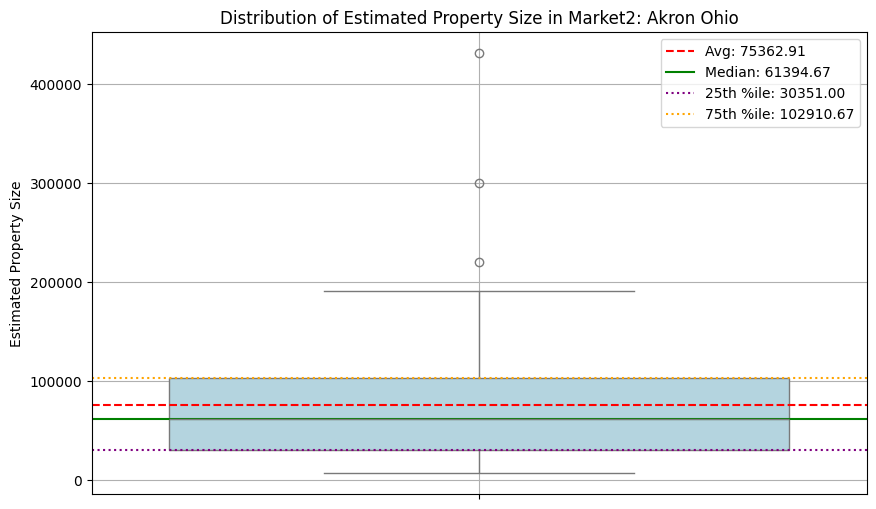

In [81]:
import seaborn as sns
df_2 = MSA2_cleaned_sheets['Rent']

# Calculate statistics
mean_value = df_2['Estimated_Property_Size'].mean()
q25 = np.percentile(df_2['Estimated_Property_Size'].dropna(), 25)
q75 = np.percentile(df_2['Estimated_Property_Size'].dropna(), 75)
median_value = np.median(df_2['Estimated_Property_Size'].dropna())

# Create Box Plot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(y=df_2['Estimated_Property_Size'], color="lightblue")

# Add annotations
plt.axhline(mean_value, color='r', linestyle='--', label=f'Avg: {mean_value:.2f}')
plt.axhline(median_value, color='g', linestyle='-', label=f'Median: {median_value:.2f}')
plt.axhline(q25, color='purple', linestyle=':', label=f'25th %ile: {q25:.2f}')
plt.axhline(q75, color='orange', linestyle=':', label=f'75th %ile: {q75:.2f}')

# Labels and legend
plt.title('Distribution of Estimated Property Size in Market2: Akron Ohio')
plt.ylabel('Estimated Property Size')
plt.legend(loc="upper right")
plt.grid(True)

plt.show()


**HEATMAP For Visualisation of MARKET and SUBMARKET GRADES - Austin Round Rock, TX and Akron,OH**

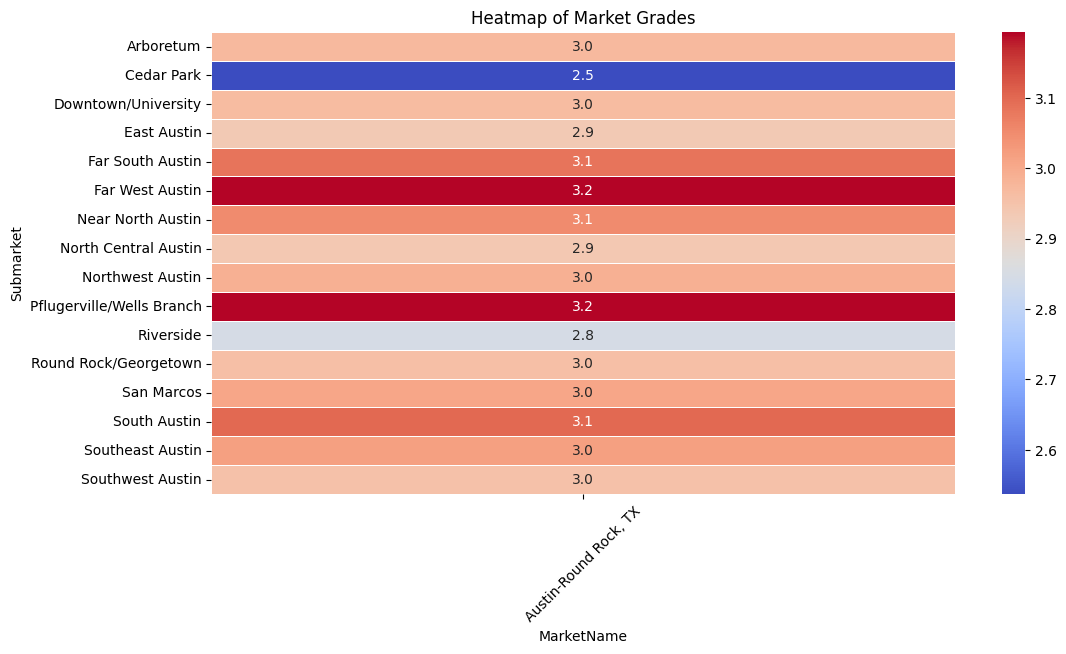

In [82]:

# Heatmap for Market and Submarket Grades
plt.figure(figsize=(12, 6))
pivot_table = MSA1_cleaned_sheets['Asset_Class'].pivot_table(index='Submarket', columns='MarketName', values='Market_Grade_Avg')  # Adjust column names
sns.heatmap(pivot_table, cmap="coolwarm", annot=True, fmt=".1f", linewidths=0.5)
plt.title("Heatmap of Market Grades")
plt.xticks(rotation=45)
plt.show()

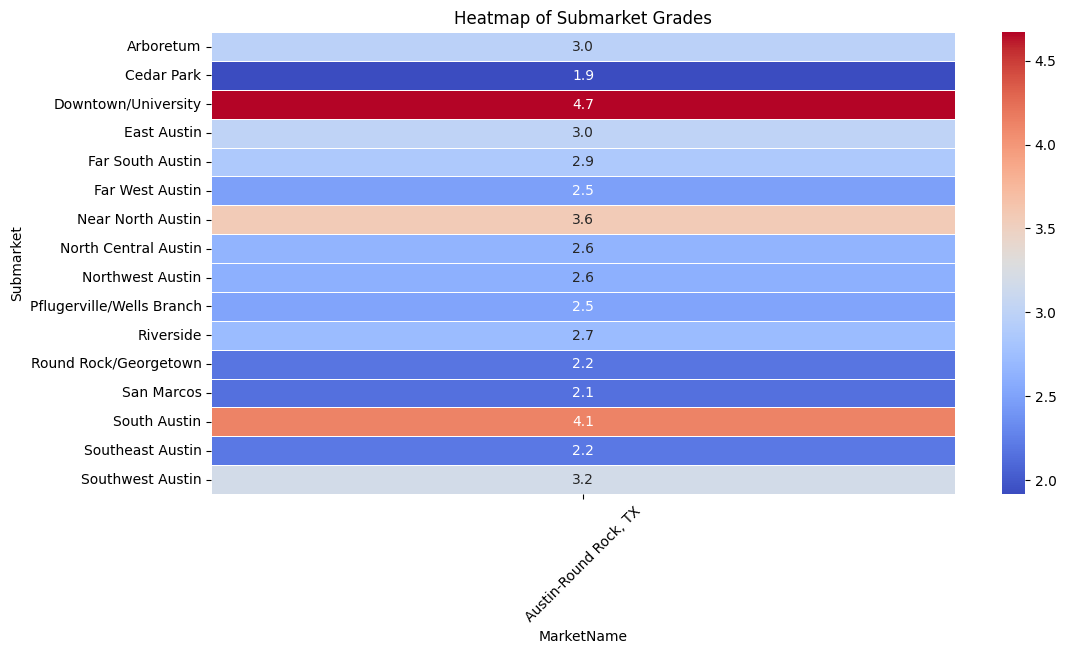

In [83]:

# Heatmap for Market and Submarket Grades
plt.figure(figsize=(12, 6))
pivot_table = MSA1_cleaned_sheets['Asset_Class'].pivot_table(index='Submarket', columns='MarketName', values='SubMarket_Grade_Avg')  # Adjust column names
sns.heatmap(pivot_table, cmap="coolwarm", annot=True, fmt=".1f", linewidths=0.5)
plt.title("Heatmap of Submarket Grades")
plt.xticks(rotation=45)
plt.show()

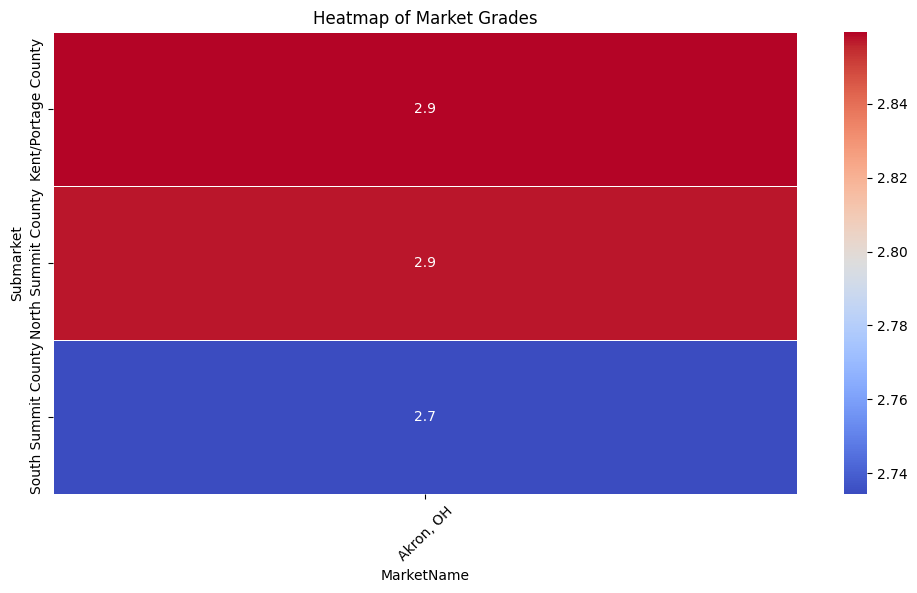

In [84]:

# Heatmap for Market and Submarket Grades
plt.figure(figsize=(12, 6))
pivot_table = MSA2_cleaned_sheets['Asset_Class'].pivot_table(index='Submarket', columns='MarketName', values='Market_Grade_Avg')  # Adjust column names
sns.heatmap(pivot_table, cmap="coolwarm", annot=True, fmt=".1f", linewidths=0.5)
plt.title("Heatmap of Market Grades")
plt.xticks(rotation=45)
plt.show()

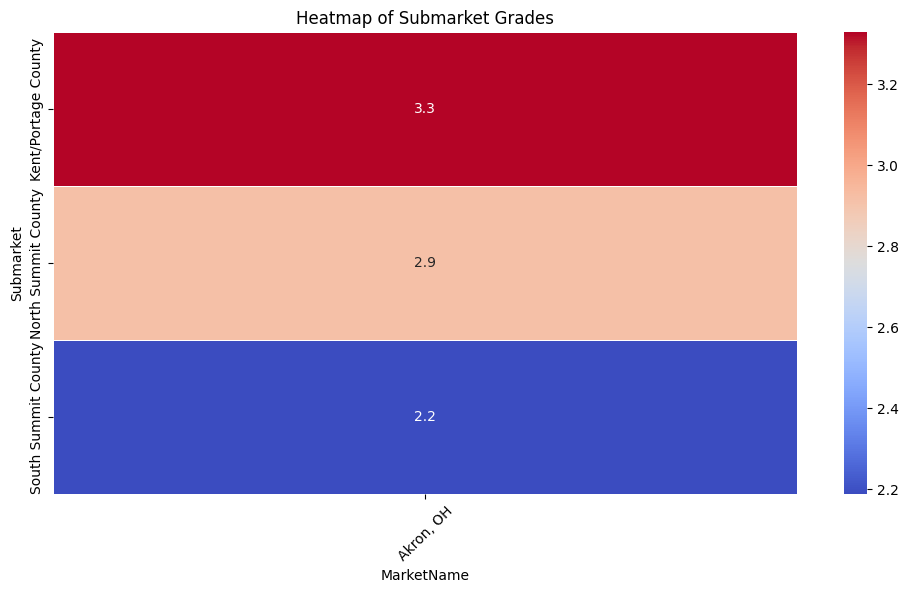

In [85]:

# Heatmap for Market and Submarket Grades
plt.figure(figsize=(12, 6))
pivot_table = MSA2_cleaned_sheets['Asset_Class'].pivot_table(index='Submarket', columns='MarketName', values='SubMarket_Grade_Avg')  # Adjust column names
sns.heatmap(pivot_table, cmap="coolwarm", annot=True, fmt=".1f", linewidths=0.5)
plt.title("Heatmap of Submarket Grades")
plt.xticks(rotation=45)
plt.show()

**#we need to improve predicitve performance of lease up times, what if we made a feature to instead of single values of average occupancy rates during lease up times, avrage eff rent, avg rent per sq ft.**

Let's first see the average occupancy during lease up periods in order to make a dataframe small and compatible

In [86]:
def calculate_avg_occupancy_lease_up(delivered_df, occupancy_df):
    """
    Calculates the average occupancy during lease-up time for each delivered property 
    from the first LU/UC-LU recorded month until it reaches 90% (0.90).

    Args:
    delivered_df (pd.DataFrame): DataFrame containing only delivered properties.
    occupancy_df (pd.DataFrame): DataFrame containing occupancy data.

    Returns:
    pd.DataFrame: The updated occupancy_df with a new column for average occupancy during lease-up.
    """
    avg_occupancy_dict = {}

    # Iterate through each delivered property
    for index, row in delivered_df.iterrows():
        proj_id = row["ProjID"]  # Get property identifier
        first_lease_up_date = row["First_LU_Date"]  # Get first LU date

        # Find corresponding row in occupancy dataset
        occupancy_row = occupancy_df[occupancy_df["ProjID"] == proj_id]

        if occupancy_row.empty or pd.isna(first_lease_up_date):
            avg_occupancy_dict[proj_id] = np.nan  # If no matching occupancy data, store NaN
            continue

        # Convert lease-up date to match column names in occupancy_df
        if first_lease_up_date in occupancy_df.columns:
            start_col_index = occupancy_df.columns.get_loc(first_lease_up_date)
        else:
            avg_occupancy_dict[proj_id] = np.nan
            continue

        # Extract occupancy values starting from lease-up month
        occupancy_values = occupancy_row.iloc[:, start_col_index:].values.flatten()

        # Convert to numeric, handling missing values
        occupancy_values = pd.to_numeric(occupancy_values, errors='coerce')
        occupancy_values = occupancy_values[~np.isnan(occupancy_values)]  # Remove NaNs

        # Find when occupancy reaches 90% for the first time
        lease_up_end_index = np.where(occupancy_values >= 0.90)[0]

        if len(lease_up_end_index) == 0:
            avg_occupancy = np.nan  # If never reaches 90%, return NaN
        else:
            lease_up_period = occupancy_values[:lease_up_end_index[0] + 1]  # Include the first 90% month
            avg_occupancy = np.mean(lease_up_period) if len(lease_up_period) > 0 else np.nan

        avg_occupancy_dict[proj_id] = avg_occupancy

    # Map the calculated average occupancy to the main occupancy DataFrame
    occupancy_df["Avg_Occupancy_During_Lease_Up"] = occupancy_df["ProjID"].map(avg_occupancy_dict)

    return occupancy_df


In [87]:
occupancy_austin = calculate_avg_occupancy_lease_up(delivered_Austin, occupancy_austin)
occupancy_akron = calculate_avg_occupancy_lease_up(delivered_Akron, occupancy_akron)

/var/folders/z2/fm7clqhj5855cx6jvwxrpyc00000gn/T/ipykernel_24614/3871127705.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occupancy_df["Avg_Occupancy_During_Lease_Up"] = occupancy_df["ProjID"].map(avg_occupancy_dict)
/var/folders/z2/fm7clqhj5855cx6jvwxrpyc00000gn/T/ipykernel_24614/3871127705.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occupancy_df["Avg_Occupancy_During_Lease_Up"] = occupancy_df["ProjID"].map(avg_occupancy_dict)


In [88]:
occupancy_austin['Avg_Occupancy_During_Lease_Up'].nunique()

64

In [89]:
occupancy_akron['Avg_Occupancy_During_Lease_Up'].nunique()

2

**We also need to calculate average occupancy for properties either as R status or S status. AS that data can be also used as negative examples for lease up time periods.**

In [90]:
def calculate_avg_occupancy_all_properties(delivered_df, occupancy_df):
    """
    Calculates the average occupancy for all properties.
    - For delivered properties, it uses occupancy values until reaching 90%.
    - For other properties, it averages across all available months.

    Args:
    delivered_df (pd.DataFrame): DataFrame containing only delivered properties.
    occupancy_df (pd.DataFrame): DataFrame containing occupancy data.

    Returns:
    pd.DataFrame: The updated occupancy_df with a new column for average occupancy.
    """
    avg_occupancy_dict = {}

    # --- Step 1: Compute Lease-Up Avg for Delivered Properties ---
    for index, row in delivered_df.iterrows():
        proj_id = row["ProjID"]  
        first_lease_up_date = row["First_LU_Date"]

        occupancy_row = occupancy_df[occupancy_df["ProjID"] == proj_id]

        if occupancy_row.empty or pd.isna(first_lease_up_date):
            avg_occupancy_dict[proj_id] = np.nan
            continue

        # Convert lease-up date to match column names in occupancy_df
        if first_lease_up_date in occupancy_df.columns:
            start_col_index = occupancy_df.columns.get_loc(first_lease_up_date)
        else:
            avg_occupancy_dict[proj_id] = np.nan
            continue

        # Extract occupancy values from lease-up month onwards
        occupancy_values = occupancy_row.iloc[:, start_col_index:].values.flatten()
        occupancy_values = pd.to_numeric(occupancy_values, errors='coerce')
        occupancy_values = occupancy_values[~np.isnan(occupancy_values)]

        # Find first 90% occupancy
        lease_up_end_index = np.where(occupancy_values >= 0.90)[0]

        if len(lease_up_end_index) == 0:
            avg_occupancy = np.nan  
        else:
            lease_up_period = occupancy_values[:lease_up_end_index[0] + 1]  
            avg_occupancy = np.mean(lease_up_period) if len(lease_up_period) > 0 else np.nan

        avg_occupancy_dict[proj_id] = avg_occupancy

    # --- Step 2: Compute General Avg for All Other Properties ---
    for index, row in occupancy_df.iterrows():
        proj_id = row["ProjID"]

        if proj_id in avg_occupancy_dict:  
            continue  # Skip if already calculated (delivered properties)

        # Extract numeric occupancy values
        occupancy_values = row.iloc[30:].values  
        occupancy_values = pd.to_numeric(occupancy_values, errors='coerce')
        occupancy_values = occupancy_values[~np.isnan(occupancy_values)]

        avg_occupancy = np.mean(occupancy_values) if len(occupancy_values) > 0 else np.nan
        avg_occupancy_dict[proj_id] = avg_occupancy

    # Map computed values back to occupancy DataFrame
    occupancy_df["Avg_Occupancy"] = occupancy_df["ProjID"].map(avg_occupancy_dict)

    return occupancy_df

In [91]:
occupancy_austin = calculate_avg_occupancy_all_properties(delivered_Austin, occupancy_austin)
occupancy_akron = calculate_avg_occupancy_all_properties(delivered_Akron, occupancy_akron)

/var/folders/z2/fm7clqhj5855cx6jvwxrpyc00000gn/T/ipykernel_24614/2941072221.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occupancy_df["Avg_Occupancy"] = occupancy_df["ProjID"].map(avg_occupancy_dict)
/var/folders/z2/fm7clqhj5855cx6jvwxrpyc00000gn/T/ipykernel_24614/2941072221.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occupancy_df["Avg_Occupancy"] = occupancy_df["ProjID"].map(avg_occupancy_dict)


In [92]:
occupancy_akron

0  MarketCode MarketName StateCode StateName CountyCode CountyName TractCode  \
0       10420  Akron, OH        OH      Ohio        153     Summit    509000   
1       10420  Akron, OH        OH      Ohio        153     Summit    530104   
2       10420  Akron, OH        OH      Ohio        153     Summit    508301   
3       10420  Akron, OH        OH      Ohio        153     Summit    530603   
4       10420  Akron, OH        OH      Ohio        153     Summit    530401   
..        ...        ...       ...       ...        ...        ...       ...   
94      10420  Akron, OH        OH      Ohio        133    Portage    600800   
95      10420  Akron, OH        OH      Ohio        133    Portage    600401   
96      10420  Akron, OH        OH      Ohio        153     Summit    506100   
97      10420  Akron, OH        OH      Ohio        153     Summit    530603   
98      10420  Akron, OH        OH      Ohio        153     Summit    520106   

0  BlockGroupCode  Latitude Longitude ETAKInd                    True Owner  \
0               1  41.07457 -81.49274     NaN                           NaN   
1               4  41.31766 -81.44473     NaN             Gross Residential   
2               1  41.08116 -81.51936     NaN             Bower Development   
3               1  41.17892 -81.48353     NaN        Botnick Realty Company   
4               1  41.17894 -81.43911     NaN                 Banyan Living   
..            ...       ...       ...     ...                           ...   
94              1  41.16758 -81.23151     NaN  Simco Management Corporation   
95              1  41.26366  -81.3641     NaN      Elon Property Management   
96              6  41.11091 -81.57355     NaN            AIY Properties Inc   
97              1  41.17923 -81.48822     NaN       PNC Real Estate Finance   
98              2  41.12067 -81.46037     NaN          BROOKWOOD MANAGEMENT   

0              ManagementCompany    ProjID            Submarket  \
0                            NaN  10258733  South Summit County   
1              Gross Residential     13558  North Summit County   
2              Bower Development     87610  South Summit County   
3         Botnick Realty Company     17397  North Summit County   
4                    KALO Living     67674  North Summit County   
..                           ...       ...                  ...   
94  Simco Management Corporation     62083  Kent/Portage County   
95      Elon Property Management  10000315  Kent/Portage County   
96            AIY Properties Inc     17335  South Summit County   
97             Gross Residential     17396  North Summit County   
98          BROOKWOOD MANAGEMENT     68394  North Summit County   

0                     Name                    Address            City State  \
0   797 Residence & Suites            797 E Market St           Akron    OH   
1               Arbor Glen         2639 Arbor Glen Dr       Twinsburg    OH   
2          Bowery District              156 S Main St           Akron    OH   
3              Bridgewater      4172 Bridgewater Pkwy            Stow    OH   
4           Brighton Place             4175 Darrow Rd            Stow    OH   
..                     ...                        ...             ...   ...   
94          Woodgate North                709 Sapp Rd         Ravenna    OH   
95               Woodlands               833 Frost Rd     Streetsboro    OH   
96       Woods of Fairlawn                17 Manor Rd           Akron    OH   
97           Wyndham Ridge      4020 Wyndham Ridge Dr            Stow    OH   
98         Yorkshire Woods  1305 Buckingham Gate Blvd  Cuyahoga Falls    OH   

0     Zip       Phone YearBuilt Rehab1 Rehab2 Rehab3 Quantity AreaPerUnit  \
0   44305  3306175777      2019    NaN    NaN    NaN       60         959   
1   44087  3309633360      2002    NaN    NaN    NaN      288        1007   
2   44308  3306183469      2020    NaN    NaN    NaN       92         897   
3   44224  3309283121      1

In [649]:
occupancy_austin

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305              2  30.30917 -97.72881     NaN   
1        Travis    001716              2  30.36687 -97.79303     NaN   
2        Travis    001860              2  30.45009 -97.64873     NaN   
3        Travis    000604              3  30.28462 -97.74723     NaN   
4    Williamson    020312              2  30.57164 -97.87028     NaN   
..          ...       ...            ...       ...       ...     ...   
864      Travis    001817              1  30.36689 -97.72829     NaN   
865        Hays    010804              3  30.03098 -98.10173     NaN   
866      Travis    001806              3  30.34684  -97.6966     NaN   
867      Travis    002005              1  30.23269 -97.78612     NaN   
868      Travis    001707              2  30.37337 -97.75408     NaN   

0                      True Owner           ManagementCompany    ProjID  \
0                 Privately Owned          MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital           Weller Management     14466   
2      Castle Lanterra Properties    Lincoln Property Company     89519   
3          Texla Housing Partners      Texla Housing Partners     43056   
4          NE Property Management      NE Property Management  10255043   
..                            ...                         ...       ...   
864    Churchill Forge Properties  Churchill Forge Properties     18419   
865      Sendera Investment Group            Merge Management     79577   
866           DTI Investments Inc         DTI Investments Inc     69991   
867            Martine Properties          Martine Properties     88278   
868                 Nitya Capital   Karya Property Management     87479   

0                    Submarket                         Name  \
0            Near North Austin                    108 Place   
1              Far West Austin      10X Living at Grandview   
2    Pflugerville/Wells Branch                1825 Cottages   
3          Downtown/University                     21 Pearl   
4                   Cedar Park          22 North Apartments   
..                         ...                          ...   
864          Near North Austin                    Woodchase   
865                 San Marcos         Woodcreek Apartments   
866       North Central Austin  Woodland Heights Apartments   
867               South Austin            Woods at Manchaca   
868                  Arboretum                    Woodstone   

0                        Address          City State    Zip       Phone  \
0                  108 W 45th St        Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   
3                  911 W 21st St        Austin    TX  78705  5124730808   
4                149 S Bagdad Rd       Leander    TX  78641  5129868727   
..                           ...           ...   ...    ...         ...   
864               8524 Burnet Rd        Austin    TX  78757  5124208341   
865         

In [93]:
occupancy_akron['Avg_Occupancy'].nunique()

94

In [94]:
occupancy_austin['Avg_Occupancy'].nunique()

838

In [95]:
occupancy_austin["Avg_Occupancy"].fillna(0, inplace=True)
occupancy_akron["Avg_Occupancy"].fillna(0, inplace=True)


/var/folders/z2/fm7clqhj5855cx6jvwxrpyc00000gn/T/ipykernel_24614/2814106643.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  occupancy_austin["Avg_Occupancy"].fillna(0, inplace=True)
/var/folders/z2/fm7clqhj5855cx6jvwxrpyc00000gn/T/ipykernel_24614/2814106643.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occupancy_austin["Avg_Occupancy

In [96]:
occupancy_austin["Avg_Occupancy_During_Lease_Up"].fillna(0, inplace=True)
occupancy_akron["Avg_Occupancy_During_Lease_Up"].fillna(0, inplace=True)


/var/folders/z2/fm7clqhj5855cx6jvwxrpyc00000gn/T/ipykernel_24614/1066189896.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  occupancy_austin["Avg_Occupancy_During_Lease_Up"].fillna(0, inplace=True)
/var/folders/z2/fm7clqhj5855cx6jvwxrpyc00000gn/T/ipykernel_24614/1066189896.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occupancy_austi

In [97]:
occupancy_austin

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305              2  30.30917 -97.72881     NaN   
1        Travis    001716              2  30.36687 -97.79303     NaN   
2        Travis    001860              2  30.45009 -97.64873     NaN   
3        Travis    000604              3  30.28462 -97.74723     NaN   
4    Williamson    020312              2  30.57164 -97.87028     NaN   
..          ...       ...            ...       ...       ...     ...   
864      Travis    001817              1  30.36689 -97.72829     NaN   
865        Hays    010804              3  30.03098 -98.10173     NaN   
866      Travis    001806              3  30.34684  -97.6966     NaN   
867      Travis    002005              1  30.23269 -97.78612     NaN   
868      Travis    001707              2  30.37337 -97.75408     NaN   

0                      True Owner           ManagementCompany    ProjID  \
0                 Privately Owned          MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital           Weller Management     14466   
2      Castle Lanterra Properties    Lincoln Property Company     89519   
3          Texla Housing Partners      Texla Housing Partners     43056   
4          NE Property Management      NE Property Management  10255043   
..                            ...                         ...       ...   
864    Churchill Forge Properties  Churchill Forge Properties     18419   
865      Sendera Investment Group            Merge Management     79577   
866           DTI Investments Inc         DTI Investments Inc     69991   
867            Martine Properties          Martine Properties     88278   
868                 Nitya Capital   Karya Property Management     87479   

0                    Submarket                         Name  \
0            Near North Austin                    108 Place   
1              Far West Austin      10X Living at Grandview   
2    Pflugerville/Wells Branch                1825 Cottages   
3          Downtown/University                     21 Pearl   
4                   Cedar Park          22 North Apartments   
..                         ...                          ...   
864          Near North Austin                    Woodchase   
865                 San Marcos         Woodcreek Apartments   
866       North Central Austin  Woodland Heights Apartments   
867               South Austin            Woods at Manchaca   
868                  Arboretum                    Woodstone   

0                        Address          City State    Zip       Phone  \
0                  108 W 45th St        Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   
3                  911 W 21st St        Austin    TX  78705  5124730808   
4                149 S Bagdad Rd       Leander    TX  78641  5129868727   
..                           ...           ...   ...    ...         ...   
864               8524 Burnet Rd        Austin    TX  78757  5124208341   
865         

In [98]:
'''Updates So Far
Calculated Lease-Up Time 

Identified lease-up periods for delivered properties.
Found the time taken to reach 90% occupancy.
Computed average occupancy during lease-up.
Calculated Average Occupancy for All Properties 

Avoided empty values by assigning NaN → 0.
Updated each property’s average occupancy.
Updated the Sheets 

Now stored in MSA1_cleaned_sheets['Occ_&_Concession']
And MSA2_cleaned_sheets['Occ_&_Concession']
'''

"Updates So Far\nCalculated Lease-Up Time \n\nIdentified lease-up periods for delivered properties.\nFound the time taken to reach 90% occupancy.\nComputed average occupancy during lease-up.\nCalculated Average Occupancy for All Properties \n\nAvoided empty values by assigning NaN → 0.\nUpdated each property’s average occupancy.\nUpdated the Sheets \n\nNow stored in MSA1_cleaned_sheets['Occ_&_Concession']\nAnd MSA2_cleaned_sheets['Occ_&_Concession']\n"

In [99]:
MSA1_cleaned_sheets['Occ_&_Concession'] = MSA1_cleaned_sheets['Occ_&_Concession'].merge(
    occupancy_austin[['ProjID', 'Avg_Occupancy', 'Avg_Occupancy_During_Lease_Up']], 
    on='ProjID', 
    how='left'
)

In [100]:
MSA1_cleaned_sheets['Occ_&_Concession']

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305              2  30.30917 -97.72881     NaN   
1        Travis    001716              2  30.36687 -97.79303     NaN   
2        Travis    001860              2  30.45009 -97.64873     NaN   
3        Travis    000604              3  30.28462 -97.74723     NaN   
4    Williamson    020312              2  30.57164 -97.87028     NaN   
..          ...       ...            ...       ...       ...     ...   
864      Travis    001817              1  30.36689 -97.72829     NaN   
865        Hays    010804              3  30.03098 -98.10173     NaN   
866      Travis    001806              3  30.34684  -97.6966     NaN   
867      Travis    002005              1  30.23269 -97.78612     NaN   
868      Travis    001707              2  30.37337 -97.75408     NaN   

0                      True Owner           ManagementCompany    ProjID  \
0                 Privately Owned          MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital           Weller Management     14466   
2      Castle Lanterra Properties    Lincoln Property Company     89519   
3          Texla Housing Partners      Texla Housing Partners     43056   
4          NE Property Management      NE Property Management  10255043   
..                            ...                         ...       ...   
864    Churchill Forge Properties  Churchill Forge Properties     18419   
865      Sendera Investment Group            Merge Management     79577   
866           DTI Investments Inc         DTI Investments Inc     69991   
867            Martine Properties          Martine Properties     88278   
868                 Nitya Capital   Karya Property Management     87479   

0                    Submarket                         Name  \
0            Near North Austin                    108 Place   
1              Far West Austin      10X Living at Grandview   
2    Pflugerville/Wells Branch                1825 Cottages   
3          Downtown/University                     21 Pearl   
4                   Cedar Park          22 North Apartments   
..                         ...                          ...   
864          Near North Austin                    Woodchase   
865                 San Marcos         Woodcreek Apartments   
866       North Central Austin  Woodland Heights Apartments   
867               South Austin            Woods at Manchaca   
868                  Arboretum                    Woodstone   

0                        Address          City State    Zip       Phone  \
0                  108 W 45th St        Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   
3                  911 W 21st St        Austin    TX  78705  5124730808   
4                149 S Bagdad Rd       Leander    TX  78641  5129868727   
..                           ...           ...   ...    ...         ...   
864               8524 Burnet Rd        Austin    TX  78757  5124208341   
865         

In [659]:
MSA1_cleaned_sheets['Occ_&_Concession']

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305              2  30.30917 -97.72881     NaN   
1        Travis    001716              2  30.36687 -97.79303     NaN   
2        Travis    001860              2  30.45009 -97.64873     NaN   
3        Travis    000604              3  30.28462 -97.74723     NaN   
4    Williamson    020312              2  30.57164 -97.87028     NaN   
..          ...       ...            ...       ...       ...     ...   
864      Travis    001817              1  30.36689 -97.72829     NaN   
865        Hays    010804              3  30.03098 -98.10173     NaN   
866      Travis    001806              3  30.34684  -97.6966     NaN   
867      Travis    002005              1  30.23269 -97.78612     NaN   
868      Travis    001707              2  30.37337 -97.75408     NaN   

0                      True Owner           ManagementCompany    ProjID  \
0                 Privately Owned          MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital           Weller Management     14466   
2      Castle Lanterra Properties    Lincoln Property Company     89519   
3          Texla Housing Partners      Texla Housing Partners     43056   
4          NE Property Management      NE Property Management  10255043   
..                            ...                         ...       ...   
864    Churchill Forge Properties  Churchill Forge Properties     18419   
865      Sendera Investment Group            Merge Management     79577   
866           DTI Investments Inc         DTI Investments Inc     69991   
867            Martine Properties          Martine Properties     88278   
868                 Nitya Capital   Karya Property Management     87479   

0                    Submarket                         Name  \
0            Near North Austin                    108 Place   
1              Far West Austin      10X Living at Grandview   
2    Pflugerville/Wells Branch                1825 Cottages   
3          Downtown/University                     21 Pearl   
4                   Cedar Park          22 North Apartments   
..                         ...                          ...   
864          Near North Austin                    Woodchase   
865                 San Marcos         Woodcreek Apartments   
866       North Central Austin  Woodland Heights Apartments   
867               South Austin            Woods at Manchaca   
868                  Arboretum                    Woodstone   

0                        Address          City State    Zip       Phone  \
0                  108 W 45th St        Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   
3                  911 W 21st St        Austin    TX  78705  5124730808   
4                149 S Bagdad Rd       Leander    TX  78641  5129868727   
..                           ...           ...   ...    ...         ...   
864               8524 Burnet Rd        Austin    TX  78757  5124208341   
865         

In [101]:
MSA2_cleaned_sheets['Occ_&_Concession'] = MSA2_cleaned_sheets['Occ_&_Concession'].merge(
    occupancy_akron[['ProjID', 'Avg_Occupancy', 'Avg_Occupancy_During_Lease_Up']], 
    on='ProjID', 
    how='left'
)

In [102]:
MSA2_cleaned_sheets['Occ_&_Concession']

0  MarketCode MarketName StateCode StateName CountyCode CountyName TractCode  \
0       10420  Akron, OH        OH      Ohio        153     Summit    509000   
1       10420  Akron, OH        OH      Ohio        153     Summit    530104   
2       10420  Akron, OH        OH      Ohio        153     Summit    508301   
3       10420  Akron, OH        OH      Ohio        153     Summit    530603   
4       10420  Akron, OH        OH      Ohio        153     Summit    530401   
..        ...        ...       ...       ...        ...        ...       ...   
94      10420  Akron, OH        OH      Ohio        133    Portage    600800   
95      10420  Akron, OH        OH      Ohio        133    Portage    600401   
96      10420  Akron, OH        OH      Ohio        153     Summit    506100   
97      10420  Akron, OH        OH      Ohio        153     Summit    530603   
98      10420  Akron, OH        OH      Ohio        153     Summit    520106   

0  BlockGroupCode  Latitude Longitude ETAKInd                    True Owner  \
0               1  41.07457 -81.49274     NaN                           NaN   
1               4  41.31766 -81.44473     NaN             Gross Residential   
2               1  41.08116 -81.51936     NaN             Bower Development   
3               1  41.17892 -81.48353     NaN        Botnick Realty Company   
4               1  41.17894 -81.43911     NaN                 Banyan Living   
..            ...       ...       ...     ...                           ...   
94              1  41.16758 -81.23151     NaN  Simco Management Corporation   
95              1  41.26366  -81.3641     NaN      Elon Property Management   
96              6  41.11091 -81.57355     NaN            AIY Properties Inc   
97              1  41.17923 -81.48822     NaN       PNC Real Estate Finance   
98              2  41.12067 -81.46037     NaN          BROOKWOOD MANAGEMENT   

0              ManagementCompany    ProjID            Submarket  \
0                            NaN  10258733  South Summit County   
1              Gross Residential     13558  North Summit County   
2              Bower Development     87610  South Summit County   
3         Botnick Realty Company     17397  North Summit County   
4                    KALO Living     67674  North Summit County   
..                           ...       ...                  ...   
94  Simco Management Corporation     62083  Kent/Portage County   
95      Elon Property Management  10000315  Kent/Portage County   
96            AIY Properties Inc     17335  South Summit County   
97             Gross Residential     17396  North Summit County   
98          BROOKWOOD MANAGEMENT     68394  North Summit County   

0                     Name                    Address            City State  \
0   797 Residence & Suites            797 E Market St           Akron    OH   
1               Arbor Glen         2639 Arbor Glen Dr       Twinsburg    OH   
2          Bowery District              156 S Main St           Akron    OH   
3              Bridgewater      4172 Bridgewater Pkwy            Stow    OH   
4           Brighton Place             4175 Darrow Rd            Stow    OH   
..                     ...                        ...             ...   ...   
94          Woodgate North                709 Sapp Rd         Ravenna    OH   
95               Woodlands               833 Frost Rd     Streetsboro    OH   
96       Woods of Fairlawn                17 Manor Rd           Akron    OH   
97           Wyndham Ridge      4020 Wyndham Ridge Dr            Stow    OH   
98         Yorkshire Woods  1305 Buckingham Gate Blvd  Cuyahoga Falls    OH   

0     Zip       Phone YearBuilt Rehab1 Rehab2 Rehab3 Quantity AreaPerUnit  \
0   44305  3306175777      2019    NaN    NaN    NaN       60         959   
1   44087  3309633360      2002    NaN    NaN    NaN      288        1007   
2   44308  3306183469      2020    NaN    NaN    NaN       92         897   
3   44224  3309283121      1

In [103]:
MSA1_cleaned_sheets['Occ_&_Concession'].iloc[:, 180:330]

0   Apr-08 May-08 Jun-08 Jul-08 Aug-08 Sep-08 Oct-08 Nov-08 Dec-08 Jan-09  \
0      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1       74     84     84     22     34     34    128     93    139      0   
2        0      0      0      0      0      0      0      0      0     20   
3      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
864      0      0      0      0      0      3      9      9     14     28   
865    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
866    NaN    NaN      0      0      0      0     15     31     47     30   
867    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
868      0      0      0     14     29     28     28     28     43     58   

0   Feb-09 Mar-09 Apr-09 May-09 Jun-09 Jul-09 Aug-09 Sep-09 Oct-09 Nov-09  \
0      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1      168    105      0      0    194      0      0      0      0      0   
2       40     60     57     55     53     50     47     45     47     48   
3      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
864     28    110     82    130    131     27     57     57     25     57   
865    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
866     15      0      0      0      0     16     32     48     48     48   
867    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
868     73     88     90     92     95     63     31      0     46     92   

0   Dec-09 Jan-10 Feb-10 Mar-10 Apr-10 May-10 Jun-10 Jul-10 Aug-10 Sep-10  \
0      NaN    NaN    NaN    NaN    NaN    NaN      0    NaN    NaN    NaN   
1        0     53      0      0      0      0      0      0      0      0   
2      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
864    125     51     51     51     51     52      0     52     54     27   
865    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
866     48     49     50     50     50     51     37     26     12      0   
867    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
868     86     79     73     67     67     67     67     33      0      0   

0   Oct-10 Nov-10 Dec-10 Jan-11 Feb-11 Mar-11 Apr-11 May-11 Jun-11 Jul-11  \
0      NaN    NaN    NaN    NaN    NaN    NaN      0    NaN    NaN    NaN   
1        0      0      0      0      0      0      0      0      0      0   
2      NaN    NaN    NaN    NaN    NaN    NaN    NaN      0      0      0   
3      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
864     28      0      0      0     19     28      0     13      0      0   
865    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
866      0      0     23     46     48     49     49     51     52     53   
867    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
868      0      0      0      0      0      0      0      0      0      0   

0   Aug-11 Sep-11 Oct-11 Nov-11 Dec-11 Jan-12 Feb-12 Mar-12 Apr-12 May-12  \
0      NaN    NaN    NaN    NaN    NaN      0    NaN    NaN    NaN    NaN   
1        0      0      0      0      0      0      0      0      0      0   
2        6     11     17     13      8      4      0      0      0   

NEW FEATURE: AVERAGE CONCESSION OFFERED (reffered from historical data during April 2008 to September 2020)

In [104]:
def calculate_avg_concession(df, start_col=180, end_col=330):
    """
    Calculates the average concession for each property, ignoring NaN values,
    and only considering columns that contain actual concession values.
    
    Args:
        df (pd.DataFrame): The dataframe containing concession data.
        start_col (int): The starting column index for concession values.
        end_col (int): The ending column index for concession values.

    Returns:
        pd.Series: A series with the average concession for each property.
    """
    # Selecting only numeric columns with valid concession data
    concession_values = df.iloc[:, start_col:end_col]
    concession_values = concession_values.apply(pd.to_numeric, errors='coerce')  # Ensure numeric data
    
    # Drop columns where all values are NaN (i.e., columns with no concession data)
    concession_values = concession_values.dropna(axis=1, how='all')
    
    # Calculate the average, considering only valid values
    return concession_values.mean(axis=1, skipna=True)



In [105]:
MSA1_cleaned_sheets['Occ_&_Concession']['Avg_Concession'] = calculate_avg_concession(MSA1_cleaned_sheets['Occ_&_Concession'])
MSA2_cleaned_sheets['Occ_&_Concession']['Avg_Concession'] = calculate_avg_concession(MSA2_cleaned_sheets['Occ_&_Concession'])


In [106]:
MSA1_cleaned_sheets['Occ_&_Concession']

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305              2  30.30917 -97.72881     NaN   
1        Travis    001716              2  30.36687 -97.79303     NaN   
2        Travis    001860              2  30.45009 -97.64873     NaN   
3        Travis    000604              3  30.28462 -97.74723     NaN   
4    Williamson    020312              2  30.57164 -97.87028     NaN   
..          ...       ...            ...       ...       ...     ...   
864      Travis    001817              1  30.36689 -97.72829     NaN   
865        Hays    010804              3  30.03098 -98.10173     NaN   
866      Travis    001806              3  30.34684  -97.6966     NaN   
867      Travis    002005              1  30.23269 -97.78612     NaN   
868      Travis    001707              2  30.37337 -97.75408     NaN   

0                      True Owner           ManagementCompany    ProjID  \
0                 Privately Owned          MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital           Weller Management     14466   
2      Castle Lanterra Properties    Lincoln Property Company     89519   
3          Texla Housing Partners      Texla Housing Partners     43056   
4          NE Property Management      NE Property Management  10255043   
..                            ...                         ...       ...   
864    Churchill Forge Properties  Churchill Forge Properties     18419   
865      Sendera Investment Group            Merge Management     79577   
866           DTI Investments Inc         DTI Investments Inc     69991   
867            Martine Properties          Martine Properties     88278   
868                 Nitya Capital   Karya Property Management     87479   

0                    Submarket                         Name  \
0            Near North Austin                    108 Place   
1              Far West Austin      10X Living at Grandview   
2    Pflugerville/Wells Branch                1825 Cottages   
3          Downtown/University                     21 Pearl   
4                   Cedar Park          22 North Apartments   
..                         ...                          ...   
864          Near North Austin                    Woodchase   
865                 San Marcos         Woodcreek Apartments   
866       North Central Austin  Woodland Heights Apartments   
867               South Austin            Woods at Manchaca   
868                  Arboretum                    Woodstone   

0                        Address          City State    Zip       Phone  \
0                  108 W 45th St        Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   
3                  911 W 21st St        Austin    TX  78705  5124730808   
4                149 S Bagdad Rd       Leander    TX  78641  5129868727   
..                           ...           ...   ...    ...         ...   
864               8524 Burnet Rd        Austin    TX  78757  5124208341   
865         

In [107]:
MSA1_cleaned_sheets['Occ_&_Concession'].iloc[:,30:480]

0   Apr-08 May-08 Jun-08 Jul-08 Aug-08 Sep-08 Oct-08 Nov-08 Dec-08 Jan-09  \
0      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1     0.91  0.919  0.919  0.919   0.91   0.91  0.919  0.919  0.912   0.89   
2    0.875  0.913  0.932  0.932  0.923  0.913  0.923  0.894  0.855  0.894   
3      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
864  0.991  0.978  0.978  0.991  0.991  0.978   0.96  0.969  0.969  0.951   
865    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
866    NaN    NaN   0.93  0.927  0.916  0.909   0.93  0.892  0.861  0.868   
867    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
868    0.9  0.933  0.958  0.966  0.966  0.966  0.975  0.966      1      1   

0   Feb-09 Mar-09 Apr-09 May-09 Jun-09 Jul-09 Aug-09 Sep-09 Oct-09 Nov-09  \
0      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1    0.879   0.86   0.86  0.879  0.949  0.969  0.949  0.962  0.941  0.949   
2    0.913  0.932  0.913  0.913  0.913  0.923  0.903  0.894  0.903  0.932   
3      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
864  0.969  0.951  0.921   0.96  0.929   0.96  0.986  0.951  0.929  0.938   
865    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
866  0.927  0.954  0.934  0.881  0.826  0.836  0.885  0.934  0.941   0.93   
867    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
868  0.966  0.916    0.9  0.908  0.925  0.933   0.95  0.966  0.883  0.883   

0   Dec-09 Jan-10 Feb-10 Mar-10 Apr-10 May-10 Jun-10 Jul-10 Aug-10 Sep-10  \
0      NaN    NaN    NaN    NaN    NaN    NaN  0.933    NaN    NaN    NaN   
1     0.96  0.899  0.899   0.89   0.91   0.91   0.93  0.914   0.93  0.941   
2      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
864  0.938  0.951  0.929  0.951   0.96   0.96   0.96  0.951  0.929  0.969   
865    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
866  0.916  0.909  0.909  0.909  0.906  0.913  0.913  0.913  0.871  0.847   
867    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
868  0.883  0.883    0.9  0.916    0.9  0.916  0.925      1      1      1   

0   Oct-10 Nov-10 Dec-10 Jan-11 Feb-11 Mar-11 Apr-11 May-11 Jun-11 Jul-11  \
0      NaN    NaN    NaN    NaN    NaN    NaN      1    NaN    NaN    NaN   
1    0.919   0.93  0.917  0.919   0.93  0.932  0.941   0.96   0.91   0.93   
2      NaN    NaN    NaN    NaN    NaN    NaN    NaN   0.99  0.961  0.951   
3      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
864  0.978   0.96   0.96   0.96  0.951   0.96  0.969  0.951  0.964  0.978   
865    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
866  0.881  0.881  0.881  0.881  0.881  0.881  0.878  0.878  0.868  0.861   
867    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
868  0.991  0.966  0.966  0.941  0.916  0.966  0.966  0.966  0.966  0.958   

0   Aug-11 Sep-11 Oct-11 Nov-11 Dec-11 Jan-12 Feb-12 Mar-12 Apr-12 May-12  \
0      NaN    NaN    NaN    NaN    NaN      1    NaN    NaN    NaN    NaN   
1    0.945   0.93  0.941   0.93  0.919  0.919   0.93  0.949   0.93   0.93   
2    0.951  0.932  0.903  0.903  0.903  0.836  0.798  0.798  0.798  0

In [109]:
MSA2_cleaned_sheets['Occ_&_Concession'].iloc[:,30:483]

0  Apr-08 May-08 Jun-08 Jul-08 Aug-08 Sep-08 Oct-08 Nov-08 Dec-08 Jan-09  \
0     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3   0.877  0.927  0.927  0.977   0.95  0.961  0.916  0.938  0.972  0.977   
4     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
94    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
95    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
96  0.901   0.93   0.93   0.97  0.936  0.959   0.95   0.95  0.939   0.95   
97  0.989  0.989  0.989  0.996  0.959  0.959      1  0.969  0.969  0.969   
98    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

0  Feb-09 Mar-09 Apr-09 May-09 Jun-09 Jul-09 Aug-09 Sep-09 Oct-09 Nov-09  \
0     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3   0.927  0.927  0.938  0.916    0.9  0.927    0.9  0.916  0.927  0.888   
4     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
94    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
95    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
96  0.936  0.936  0.947  0.924  0.959      1  0.979  0.982  0.973  0.959   
97  0.979  0.969  0.969  0.989      1      1  0.989      1  0.979  0.949   
98    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

0  Dec-09 Jan-10 Feb-10 Mar-10 Apr-10 May-10 Jun-10 Jul-10 Aug-10 Sep-10  \
0     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3   0.927  0.938   0.95  0.888  0.916  0.911  0.916  0.916  0.927  0.938   
4     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
94    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
95    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
96  0.944  0.947   0.95  0.956   0.93   0.95  0.959  0.901  0.909  0.918   
97  0.949  0.959  0.969  0.969  0.949      1  0.989  0.979  0.969  0.979   
98    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

0  Oct-10 Nov-10 Dec-10 Jan-11 Feb-11 Mar-11 Apr-11 May-11 Jun-11 Jul-11  \
0     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3    0.95  0.961  0.972  0.977  0.988  0.961  0.972  0.961  0.961  0.961   
4     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
94    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
95    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
96   0.93  0.918  0.799  0.848   0.86  0.848  0.857  0.901  0.848  0.848   
97  0.969  0.959  0.901  0.959  0.969  0.969  0.979  0.979  0.979      1   
98    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

0  Aug-11 Sep-11 Oct-11 Nov-11 Dec-11 Jan-12 Feb-12 Mar-12 Apr-12 May-12  \
0     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3   0.977  0.977  0.988    0.9  0.972   0.95

In [110]:
def drop_monthly_columns(df, start_col=30, end_col=480):
    """
    Removes the monthly columns from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe from which columns should be removed.
        start_col (int): The starting column index for removal.
        end_col (int): The ending column index for removal.

    Returns:
        pd.DataFrame: The updated dataframe with the monthly columns removed.
    """
    df.drop(df.iloc[:, start_col:end_col].columns, axis=1, inplace=True)
    return df

In [111]:
MSA1_cleaned_sheets['Occ_&_Concession'] = drop_monthly_columns(MSA1_cleaned_sheets['Occ_&_Concession'])
MSA2_cleaned_sheets['Occ_&_Concession'] = drop_monthly_columns(MSA2_cleaned_sheets['Occ_&_Concession'])

In [112]:
MSA1_cleaned_sheets['Occ_&_Concession']

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305              2  30.30917 -97.72881     NaN   
1        Travis    001716              2  30.36687 -97.79303     NaN   
2        Travis    001860              2  30.45009 -97.64873     NaN   
3        Travis    000604              3  30.28462 -97.74723     NaN   
4    Williamson    020312              2  30.57164 -97.87028     NaN   
..          ...       ...            ...       ...       ...     ...   
864      Travis    001817              1  30.36689 -97.72829     NaN   
865        Hays    010804              3  30.03098 -98.10173     NaN   
866      Travis    001806              3  30.34684  -97.6966     NaN   
867      Travis    002005              1  30.23269 -97.78612     NaN   
868      Travis    001707              2  30.37337 -97.75408     NaN   

0                      True Owner           ManagementCompany    ProjID  \
0                 Privately Owned          MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital           Weller Management     14466   
2      Castle Lanterra Properties    Lincoln Property Company     89519   
3          Texla Housing Partners      Texla Housing Partners     43056   
4          NE Property Management      NE Property Management  10255043   
..                            ...                         ...       ...   
864    Churchill Forge Properties  Churchill Forge Properties     18419   
865      Sendera Investment Group            Merge Management     79577   
866           DTI Investments Inc         DTI Investments Inc     69991   
867            Martine Properties          Martine Properties     88278   
868                 Nitya Capital   Karya Property Management     87479   

0                    Submarket                         Name  \
0            Near North Austin                    108 Place   
1              Far West Austin      10X Living at Grandview   
2    Pflugerville/Wells Branch                1825 Cottages   
3          Downtown/University                     21 Pearl   
4                   Cedar Park          22 North Apartments   
..                         ...                          ...   
864          Near North Austin                    Woodchase   
865                 San Marcos         Woodcreek Apartments   
866       North Central Austin  Woodland Heights Apartments   
867               South Austin            Woods at Manchaca   
868                  Arboretum                    Woodstone   

0                        Address          City State    Zip       Phone  \
0                  108 W 45th St        Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   
3                  911 W 21st St        Austin    TX  78705  5124730808   
4                149 S Bagdad Rd       Leander    TX  78641  5129868727   
..                           ...           ...   ...    ...         ...   
864               8524 Burnet Rd        Austin    TX  78757  5124208341   
865         

In [113]:
MSA2_cleaned_sheets['Occ_&_Concession']

0  MarketCode MarketName StateCode StateName CountyCode CountyName TractCode  \
0       10420  Akron, OH        OH      Ohio        153     Summit    509000   
1       10420  Akron, OH        OH      Ohio        153     Summit    530104   
2       10420  Akron, OH        OH      Ohio        153     Summit    508301   
3       10420  Akron, OH        OH      Ohio        153     Summit    530603   
4       10420  Akron, OH        OH      Ohio        153     Summit    530401   
..        ...        ...       ...       ...        ...        ...       ...   
94      10420  Akron, OH        OH      Ohio        133    Portage    600800   
95      10420  Akron, OH        OH      Ohio        133    Portage    600401   
96      10420  Akron, OH        OH      Ohio        153     Summit    506100   
97      10420  Akron, OH        OH      Ohio        153     Summit    530603   
98      10420  Akron, OH        OH      Ohio        153     Summit    520106   

0  BlockGroupCode  Latitude Longitude ETAKInd                    True Owner  \
0               1  41.07457 -81.49274     NaN                           NaN   
1               4  41.31766 -81.44473     NaN             Gross Residential   
2               1  41.08116 -81.51936     NaN             Bower Development   
3               1  41.17892 -81.48353     NaN        Botnick Realty Company   
4               1  41.17894 -81.43911     NaN                 Banyan Living   
..            ...       ...       ...     ...                           ...   
94              1  41.16758 -81.23151     NaN  Simco Management Corporation   
95              1  41.26366  -81.3641     NaN      Elon Property Management   
96              6  41.11091 -81.57355     NaN            AIY Properties Inc   
97              1  41.17923 -81.48822     NaN       PNC Real Estate Finance   
98              2  41.12067 -81.46037     NaN          BROOKWOOD MANAGEMENT   

0              ManagementCompany    ProjID            Submarket  \
0                            NaN  10258733  South Summit County   
1              Gross Residential     13558  North Summit County   
2              Bower Development     87610  South Summit County   
3         Botnick Realty Company     17397  North Summit County   
4                    KALO Living     67674  North Summit County   
..                           ...       ...                  ...   
94  Simco Management Corporation     62083  Kent/Portage County   
95      Elon Property Management  10000315  Kent/Portage County   
96            AIY Properties Inc     17335  South Summit County   
97             Gross Residential     17396  North Summit County   
98          BROOKWOOD MANAGEMENT     68394  North Summit County   

0                     Name                    Address            City State  \
0   797 Residence & Suites            797 E Market St           Akron    OH   
1               Arbor Glen         2639 Arbor Glen Dr       Twinsburg    OH   
2          Bowery District              156 S Main St           Akron    OH   
3              Bridgewater      4172 Bridgewater Pkwy            Stow    OH   
4           Brighton Place             4175 Darrow Rd            Stow    OH   
..                     ...                        ...             ...   ...   
94          Woodgate North                709 Sapp Rd         Ravenna    OH   
95               Woodlands               833 Frost Rd     Streetsboro    OH   
96       Woods of Fairlawn                17 Manor Rd           Akron    OH   
97           Wyndham Ridge      4020 Wyndham Ridge Dr            Stow    OH   
98         Yorkshire Woods  1305 Buckingham Gate Blvd  Cuyahoga Falls    OH   

0     Zip       Phone YearBuilt Rehab1 Rehab2 Rehab3 Quantity AreaPerUnit  \
0   44305  3306175777      2019    NaN    NaN    NaN       60         959   
1   44087  3309633360      2002    NaN    NaN    NaN      288        1007   
2   44308  3306183469      2020    NaN    NaN    NaN       92         897   
3   44224  3309283121      1

In [114]:

#MSA2_cleaned_sheets['Occ_&_Concession'] 

LET"S See the Visualisation of AVERAGE Occupancy for Both Markets

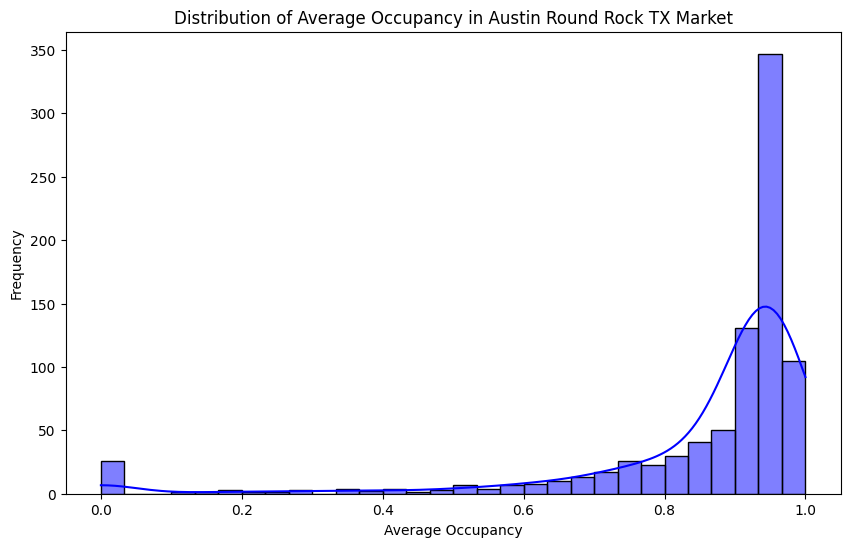

In [115]:
plt.figure(figsize=(10,6))
sns.histplot(MSA1_cleaned_sheets['Occ_&_Concession']['Avg_Occupancy'], bins=30, kde=True, color='blue')
plt.xlabel("Average Occupancy")
plt.ylabel("Frequency")
plt.title("Distribution of Average Occupancy in Austin Round Rock TX Market")
plt.show()

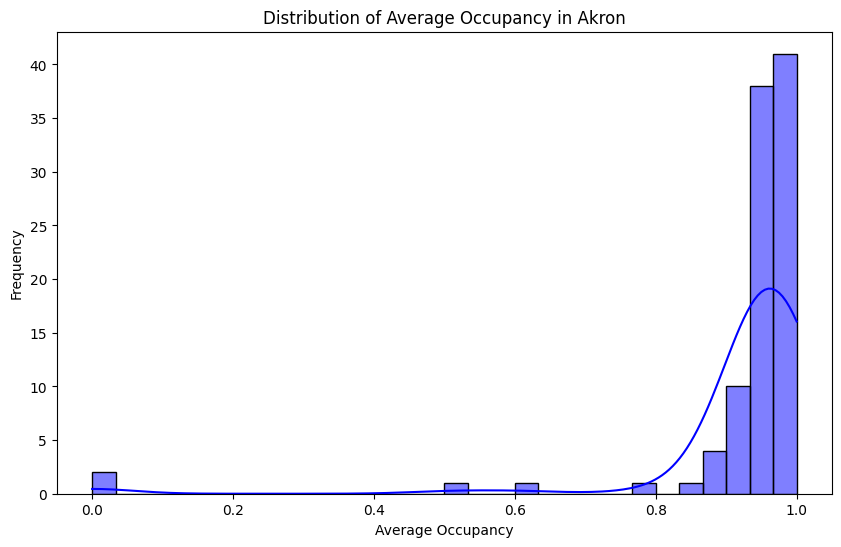

In [116]:
plt.figure(figsize=(10,6))
sns.histplot(MSA2_cleaned_sheets['Occ_&_Concession']['Avg_Occupancy'], bins=30, kde=True, color='blue')
plt.xlabel("Average Occupancy")
plt.ylabel("Frequency")
plt.title("Distribution of Average Occupancy in Akron")
plt.show()

Interesting This histogram shows a strongly right-skewed distribution (negative skew) of average occupancy in Akron.
The data is heavily concentrated at the high end of the occupancy scale (around 0.9-1.0 or 90-100% occupancy), with a long tail extending to the left toward lower occupancy values. This indicates that most properties in Akron maintain very high occupancy rates, with only a small number of properties experiencing low occupancy.

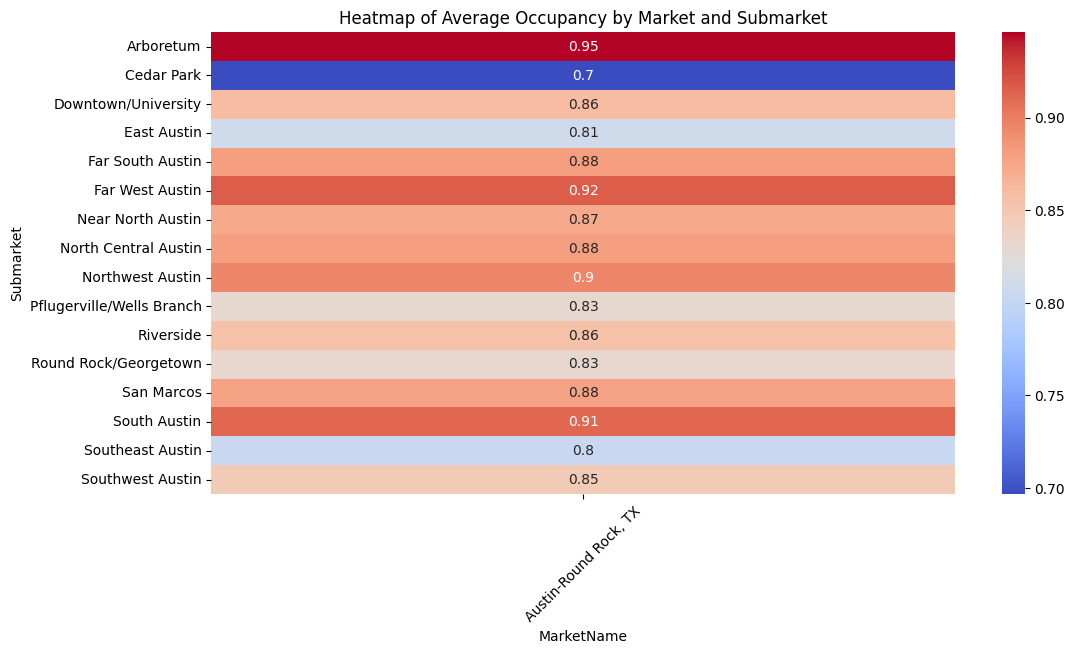

In [117]:
plt.figure(figsize=(12,6))
pivot_table = MSA1_cleaned_sheets['Occ_&_Concession'].pivot_table(index='Submarket', columns='MarketName', values='Avg_Occupancy')
sns.heatmap(pivot_table, cmap="coolwarm", annot=True)
plt.title("Heatmap of Average Occupancy by Market and Submarket")
plt.xticks(rotation=45)
plt.show()


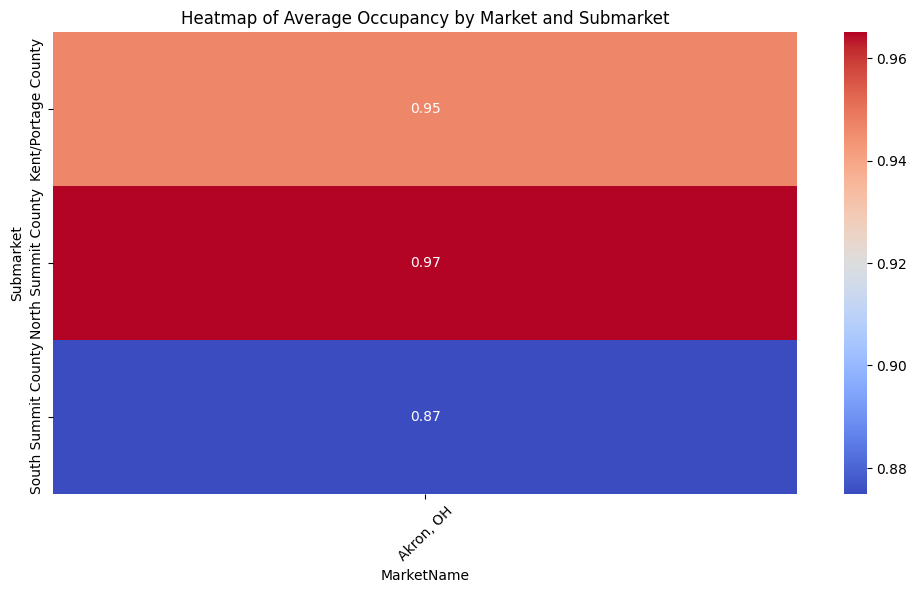

In [118]:
plt.figure(figsize=(12,6))
pivot_table = MSA2_cleaned_sheets['Occ_&_Concession'].pivot_table(index='Submarket', columns='MarketName', values='Avg_Occupancy')
sns.heatmap(pivot_table, cmap="coolwarm", annot=True)
plt.title("Heatmap of Average Occupancy by Market and Submarket")
plt.xticks(rotation=45)
plt.show()


The figure above shows the Austin-Round Rock, TX market with 16 submarkets, where occupancy ranges from 0.70 (Cedar Park) to 0.95 (Arboretum). Most submarkets maintain high occupancy (0.85-0.95), with Arboretum, Far West Austin, and South Austin being the strongest performers.
Secodnly, the figure 2 presents Akron, OH with three submarkets, showing a clear hierarchy: North Summit County leads with exceptional 0.97 occupancy, followed by County Kent/Portage at 0.95, while South Summit County lags at 0.87, indicating potential investment opportunities or structural market differences.

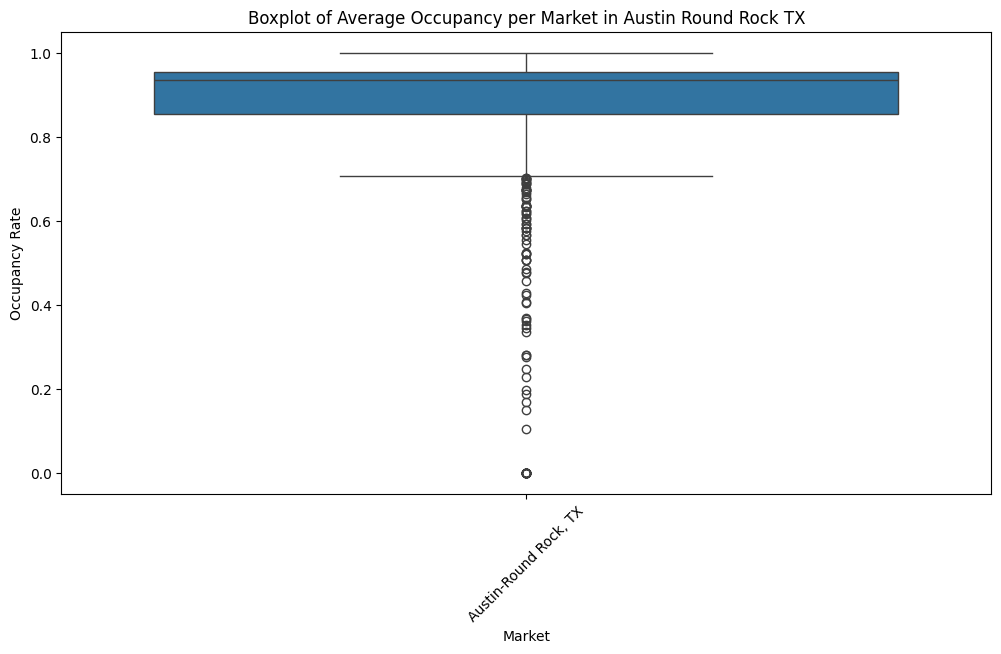

In [121]:
plt.figure(figsize=(12,6))
sns.boxplot(x="MarketName", y="Avg_Occupancy", data=MSA1_cleaned_sheets['Occ_&_Concession'])
plt.xticks(rotation=45)
plt.xlabel("Market")
plt.ylabel("Occupancy Rate")
plt.title("Boxplot of Average Occupancy per Market in Austin Round Rock TX")
plt.show()

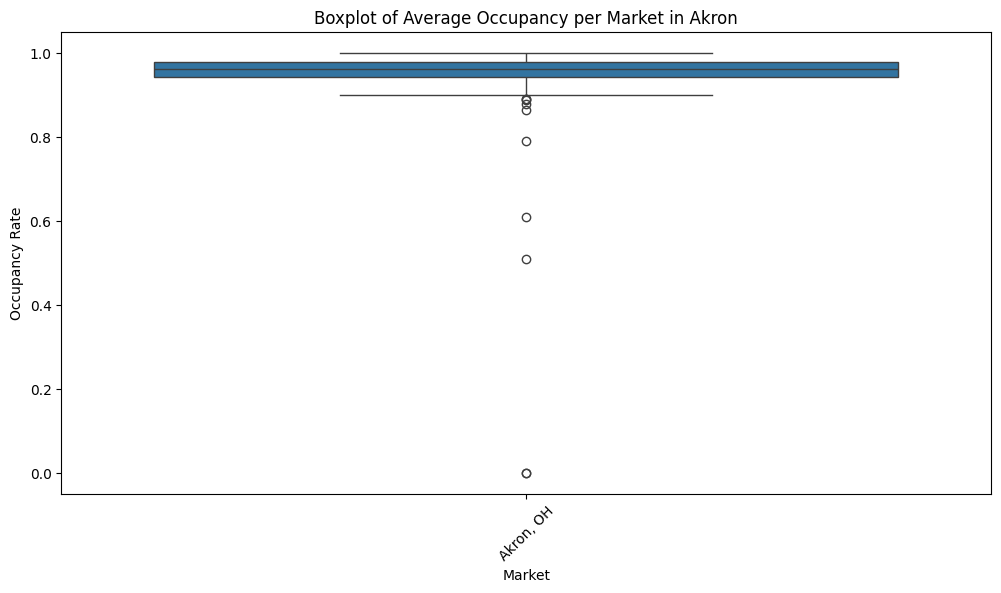

In [122]:
plt.figure(figsize=(12,6))
sns.boxplot(x="MarketName", y="Avg_Occupancy", data=MSA2_cleaned_sheets['Occ_&_Concession'])
plt.xticks(rotation=45)
plt.xlabel("Market")
plt.ylabel("Occupancy Rate")
plt.title("Boxplot of Average Occupancy per Market in Akron")
plt.show()

In [154]:
MSA1_cleaned_sheets['Rent']

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305              2  30.30917 -97.72881     NaN   
1        Travis    001716              2  30.36687 -97.79303     NaN   
2        Travis    001860              2  30.45009 -97.64873     NaN   
3        Travis    000604              3  30.28462 -97.74723     NaN   
4    Williamson    020312              2  30.57164 -97.87028     NaN   
..          ...       ...            ...       ...       ...     ...   
864      Travis    001817              1  30.36689 -97.72829     NaN   
865        Hays    010804              3  30.03098 -98.10173     NaN   
866      Travis    001806              3  30.34684  -97.6966     NaN   
867      Travis    002005              1  30.23269 -97.78612     NaN   
868      Travis    001707              2  30.37337 -97.75408     NaN   

0                      True Owner           ManagementCompany    ProjID  \
0                 Privately Owned          MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital           Weller Management     14466   
2      Castle Lanterra Properties    Lincoln Property Company     89519   
3          Texla Housing Partners      Texla Housing Partners     43056   
4          NE Property Management      NE Property Management  10255043   
..                            ...                         ...       ...   
864    Churchill Forge Properties  Churchill Forge Properties     18419   
865      Sendera Investment Group            Merge Management     79577   
866           DTI Investments Inc         DTI Investments Inc     69991   
867            Martine Properties          Martine Properties     88278   
868                 Nitya Capital   Karya Property Management     87479   

0                    Submarket                         Name  \
0            Near North Austin                    108 Place   
1              Far West Austin      10X Living at Grandview   
2    Pflugerville/Wells Branch                1825 Cottages   
3          Downtown/University                     21 Pearl   
4                   Cedar Park          22 North Apartments   
..                         ...                          ...   
864          Near North Austin                    Woodchase   
865                 San Marcos         Woodcreek Apartments   
866       North Central Austin  Woodland Heights Apartments   
867               South Austin            Woods at Manchaca   
868                  Arboretum                    Woodstone   

0                        Address          City State    Zip       Phone  \
0                  108 W 45th St        Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   
3                  911 W 21st St        Austin    TX  78705  5124730808   
4                149 S Bagdad Rd       Leander    TX  78641  5129868727   
..                           ...           ...   ...    ...         ...   
864               8524 Burnet Rd        Austin    TX  78757  5124208341   
865         

NEW FEATURE: AVERAGE EFFECTIVE RENT AND AVERAGE EFFECTIVE RENT PER SqFt.

In [124]:
def calculate_avg_effective_rent(df, start_col=180, end_col=330):
    """
    Calculates the average effective rent for each property by averaging values 
    across specified month columns (ignoring NaN values).

    Args:
        df (pd.DataFrame): The dataframe containing rent data.
        start_col (int): The starting column index of effective rent months.
        end_col (int): The ending column index of effective rent months.

    Returns:
        pd.DataFrame: The updated dataframe with a new 'Avg_Effective_Rent' column.
    """
    df['Avg_Effective_Rent'] = df.iloc[:, start_col:end_col].mean(axis=1, skipna=True)
    return df

In [125]:
MSA1_cleaned_sheets['Rent'] = calculate_avg_effective_rent(MSA1_cleaned_sheets['Rent'])
MSA2_cleaned_sheets['Rent'] = calculate_avg_effective_rent(MSA2_cleaned_sheets['Rent'])

In [126]:
MSA1_cleaned_sheets['Rent']

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305              2  30.30917 -97.72881     NaN   
1        Travis    001716              2  30.36687 -97.79303     NaN   
2        Travis    001860              2  30.45009 -97.64873     NaN   
3        Travis    000604              3  30.28462 -97.74723     NaN   
4    Williamson    020312              2  30.57164 -97.87028     NaN   
..          ...       ...            ...       ...       ...     ...   
864      Travis    001817              1  30.36689 -97.72829     NaN   
865        Hays    010804              3  30.03098 -98.10173     NaN   
866      Travis    001806              3  30.34684  -97.6966     NaN   
867      Travis    002005              1  30.23269 -97.78612     NaN   
868      Travis    001707              2  30.37337 -97.75408     NaN   

0                      True Owner           ManagementCompany    ProjID  \
0                 Privately Owned          MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital           Weller Management     14466   
2      Castle Lanterra Properties    Lincoln Property Company     89519   
3          Texla Housing Partners      Texla Housing Partners     43056   
4          NE Property Management      NE Property Management  10255043   
..                            ...                         ...       ...   
864    Churchill Forge Properties  Churchill Forge Properties     18419   
865      Sendera Investment Group            Merge Management     79577   
866           DTI Investments Inc         DTI Investments Inc     69991   
867            Martine Properties          Martine Properties     88278   
868                 Nitya Capital   Karya Property Management     87479   

0                    Submarket                         Name  \
0            Near North Austin                    108 Place   
1              Far West Austin      10X Living at Grandview   
2    Pflugerville/Wells Branch                1825 Cottages   
3          Downtown/University                     21 Pearl   
4                   Cedar Park          22 North Apartments   
..                         ...                          ...   
864          Near North Austin                    Woodchase   
865                 San Marcos         Woodcreek Apartments   
866       North Central Austin  Woodland Heights Apartments   
867               South Austin            Woods at Manchaca   
868                  Arboretum                    Woodstone   

0                        Address          City State    Zip       Phone  \
0                  108 W 45th St        Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   
3                  911 W 21st St        Austin    TX  78705  5124730808   
4                149 S Bagdad Rd       Leander    TX  78641  5129868727   
..                           ...           ...   ...    ...         ...   
864               8524 Burnet Rd        Austin    TX  78757  5124208341   
865         

In [127]:
def calculate_avg_rent_per_sqft(df, start_col=330, end_col=480):
    """
    Computes the average effective rent per square foot for each property.

    Args:
        df (pd.DataFrame): The dataframe containing rent data.
        start_col (int): The starting column index of effective rent per sq ft months.
        end_col (int): The ending column index for effective rent per sq ft.

    Returns:
        pd.DataFrame: The updated dataframe with 'Avg_Effective_Rent_Per_SqFt'.
    """
    # Compute average rent per sq ft (ignoring NaNs)
    df['Avg_Effective_Rent_Per_SqFt'] = df.iloc[:, start_col:end_col].mean(axis=1, skipna=True)

    return df


In [128]:
MSA1_cleaned_sheets['Rent'] = calculate_avg_rent_per_sqft(MSA1_cleaned_sheets['Rent'])
MSA2_cleaned_sheets['Rent'] = calculate_avg_rent_per_sqft(MSA2_cleaned_sheets['Rent'])


In [129]:
MSA1_cleaned_sheets['Rent']

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305              2  30.30917 -97.72881     NaN   
1        Travis    001716              2  30.36687 -97.79303     NaN   
2        Travis    001860              2  30.45009 -97.64873     NaN   
3        Travis    000604              3  30.28462 -97.74723     NaN   
4    Williamson    020312              2  30.57164 -97.87028     NaN   
..          ...       ...            ...       ...       ...     ...   
864      Travis    001817              1  30.36689 -97.72829     NaN   
865        Hays    010804              3  30.03098 -98.10173     NaN   
866      Travis    001806              3  30.34684  -97.6966     NaN   
867      Travis    002005              1  30.23269 -97.78612     NaN   
868      Travis    001707              2  30.37337 -97.75408     NaN   

0                      True Owner           ManagementCompany    ProjID  \
0                 Privately Owned          MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital           Weller Management     14466   
2      Castle Lanterra Properties    Lincoln Property Company     89519   
3          Texla Housing Partners      Texla Housing Partners     43056   
4          NE Property Management      NE Property Management  10255043   
..                            ...                         ...       ...   
864    Churchill Forge Properties  Churchill Forge Properties     18419   
865      Sendera Investment Group            Merge Management     79577   
866           DTI Investments Inc         DTI Investments Inc     69991   
867            Martine Properties          Martine Properties     88278   
868                 Nitya Capital   Karya Property Management     87479   

0                    Submarket                         Name  \
0            Near North Austin                    108 Place   
1              Far West Austin      10X Living at Grandview   
2    Pflugerville/Wells Branch                1825 Cottages   
3          Downtown/University                     21 Pearl   
4                   Cedar Park          22 North Apartments   
..                         ...                          ...   
864          Near North Austin                    Woodchase   
865                 San Marcos         Woodcreek Apartments   
866       North Central Austin  Woodland Heights Apartments   
867               South Austin            Woods at Manchaca   
868                  Arboretum                    Woodstone   

0                        Address          City State    Zip       Phone  \
0                  108 W 45th St        Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   
3                  911 W 21st St        Austin    TX  78705  5124730808   
4                149 S Bagdad Rd       Leander    TX  78641  5129868727   
..                           ...           ...   ...    ...         ...   
864               8524 Burnet Rd        Austin    TX  78757  5124208341   
865         

In [130]:
MSA1_cleaned_sheets['Rent'].iloc[:, 30:480]

0   Apr-08 May-08 Jun-08 Jul-08 Aug-08 Sep-08 Oct-08 Nov-08 Dec-08 Jan-09  \
0      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1     1364   1342   1354   1367   1358   1358   1358   1358   1358   1253   
2      725    725    725    725    725    725    742    758    774    758   
3      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
864    689    689    689    689    689    689    689    689    689    689   
865    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
866    NaN    NaN    580    582    584    586    575    564    553    555   
867    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
868    792    797    801    802    802    802    802    802    802    802   

0   Feb-09 Mar-09 Apr-09 May-09 Jun-09 Jul-09 Aug-09 Sep-09 Oct-09 Nov-09  \
0      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1     1253   1261   1261   1261   1261   1261   1276   1271   1222   1222   
2      742    725    725    725    725    725    725    725    725    725   
3      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
864    689    689    689    710    710    685    689    677    688    688   
865    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
866    558    561    570    579    587    587    587    587    587    587   
867    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
868    802    802    802    802    802    802    802    802    803    803   

0   Dec-09 Jan-10 Feb-10 Mar-10 Apr-10 May-10 Jun-10 Jul-10 Aug-10 Sep-10  \
0      NaN    NaN    NaN    NaN    NaN    NaN    780    NaN    NaN    NaN   
1     1222   1230   1201   1215   1210   1217   1272   1283   1283   1283   
2      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
864    688    614    614    614    614    629    629    629    655    655   
865    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
866    587    589    590    591    592    594    586    580    572    566   
867    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
868    803    803    803    803    803    802    801    802    802    802   

0   Oct-10 Nov-10 Dec-10 Jan-11 Feb-11 Mar-11 Apr-11 May-11 Jun-11 Jul-11  \
0      NaN    NaN    NaN    NaN    NaN    NaN    756    NaN    NaN    NaN   
1     1283   1283   1283   1256   1203   1257   1309   1296   1440   1297   
2      NaN    NaN    NaN    NaN    NaN    NaN    NaN    750    738    725   
3      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
864    689    689    689    689    689    689    689    689    689    689   
865    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
866    567    568    568    568    578    587    596    606    615    624   
867    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
868    802    802    802    802    802    807    812    816    820    823   

0   Aug-11 Sep-11 Oct-11 Nov-11 Dec-11 Jan-12 Feb-12 Mar-12 Apr-12 May-12  \
0      NaN    NaN    NaN    NaN    NaN    800    NaN    NaN    NaN    NaN   
1     1397   1517   1400   1289   1245   1406   1395   1450   1381   1305   
2      730    735    740    743    745    748    750    750    750   

In [131]:
MSA1_cleaned_sheets['Rent'].drop(MSA1_cleaned_sheets['Rent'].iloc[:, 30:480].columns, axis=1, inplace=True)
MSA2_cleaned_sheets['Rent'].drop(MSA2_cleaned_sheets['Rent'].iloc[:, 30:480].columns, axis=1, inplace=True)

In [132]:
MSA1_cleaned_sheets['Rent']

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305              2  30.30917 -97.72881     NaN   
1        Travis    001716              2  30.36687 -97.79303     NaN   
2        Travis    001860              2  30.45009 -97.64873     NaN   
3        Travis    000604              3  30.28462 -97.74723     NaN   
4    Williamson    020312              2  30.57164 -97.87028     NaN   
..          ...       ...            ...       ...       ...     ...   
864      Travis    001817              1  30.36689 -97.72829     NaN   
865        Hays    010804              3  30.03098 -98.10173     NaN   
866      Travis    001806              3  30.34684  -97.6966     NaN   
867      Travis    002005              1  30.23269 -97.78612     NaN   
868      Travis    001707              2  30.37337 -97.75408     NaN   

0                      True Owner           ManagementCompany    ProjID  \
0                 Privately Owned          MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital           Weller Management     14466   
2      Castle Lanterra Properties    Lincoln Property Company     89519   
3          Texla Housing Partners      Texla Housing Partners     43056   
4          NE Property Management      NE Property Management  10255043   
..                            ...                         ...       ...   
864    Churchill Forge Properties  Churchill Forge Properties     18419   
865      Sendera Investment Group            Merge Management     79577   
866           DTI Investments Inc         DTI Investments Inc     69991   
867            Martine Properties          Martine Properties     88278   
868                 Nitya Capital   Karya Property Management     87479   

0                    Submarket                         Name  \
0            Near North Austin                    108 Place   
1              Far West Austin      10X Living at Grandview   
2    Pflugerville/Wells Branch                1825 Cottages   
3          Downtown/University                     21 Pearl   
4                   Cedar Park          22 North Apartments   
..                         ...                          ...   
864          Near North Austin                    Woodchase   
865                 San Marcos         Woodcreek Apartments   
866       North Central Austin  Woodland Heights Apartments   
867               South Austin            Woods at Manchaca   
868                  Arboretum                    Woodstone   

0                        Address          City State    Zip       Phone  \
0                  108 W 45th St        Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   
3                  911 W 21st St        Austin    TX  78705  5124730808   
4                149 S Bagdad Rd       Leander    TX  78641  5129868727   
..                           ...           ...   ...    ...         ...   
864               8524 Burnet Rd        Austin    TX  78757  5124208341   
865         

In [133]:
MSA1_cleaned_sheets['Asset_Class']

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305              2  30.30917 -97.72881     NaN   
1        Travis    001716              2  30.36687 -97.79303     NaN   
2        Travis    001860              2  30.45009 -97.64873     NaN   
3        Travis    000604              3  30.28462 -97.74723     NaN   
4    Williamson    020312              2  30.57164 -97.87028     NaN   
..          ...       ...            ...       ...       ...     ...   
864      Travis    001817              1  30.36689 -97.72829     NaN   
865        Hays    010804              3  30.03098 -98.10173     NaN   
866      Travis    001806              3  30.34684  -97.6966     NaN   
867      Travis    002005              1  30.23269 -97.78612     NaN   
868      Travis    001707              2  30.37337 -97.75408     NaN   

0                      True Owner           ManagementCompany    ProjID  \
0                 Privately Owned          MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital           Weller Management     14466   
2      Castle Lanterra Properties    Lincoln Property Company     89519   
3          Texla Housing Partners      Texla Housing Partners     43056   
4          NE Property Management      NE Property Management  10255043   
..                            ...                         ...       ...   
864    Churchill Forge Properties  Churchill Forge Properties     18419   
865      Sendera Investment Group            Merge Management     79577   
866           DTI Investments Inc         DTI Investments Inc     69991   
867            Martine Properties          Martine Properties     88278   
868                 Nitya Capital   Karya Property Management     87479   

0                    Submarket                         Name  \
0            Near North Austin                    108 Place   
1              Far West Austin      10X Living at Grandview   
2    Pflugerville/Wells Branch                1825 Cottages   
3          Downtown/University                     21 Pearl   
4                   Cedar Park          22 North Apartments   
..                         ...                          ...   
864          Near North Austin                    Woodchase   
865                 San Marcos         Woodcreek Apartments   
866       North Central Austin  Woodland Heights Apartments   
867               South Austin            Woods at Manchaca   
868                  Arboretum                    Woodstone   

0                        Address          City State    Zip       Phone  \
0                  108 W 45th St        Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   
3                  911 W 21st St        Austin    TX  78705  5124730808   
4                149 S Bagdad Rd       Leander    TX  78641  5129868727   
..                           ...           ...   ...    ...         ...   
864               8524 Burnet Rd        Austin    TX  78757  5124208341   
865         

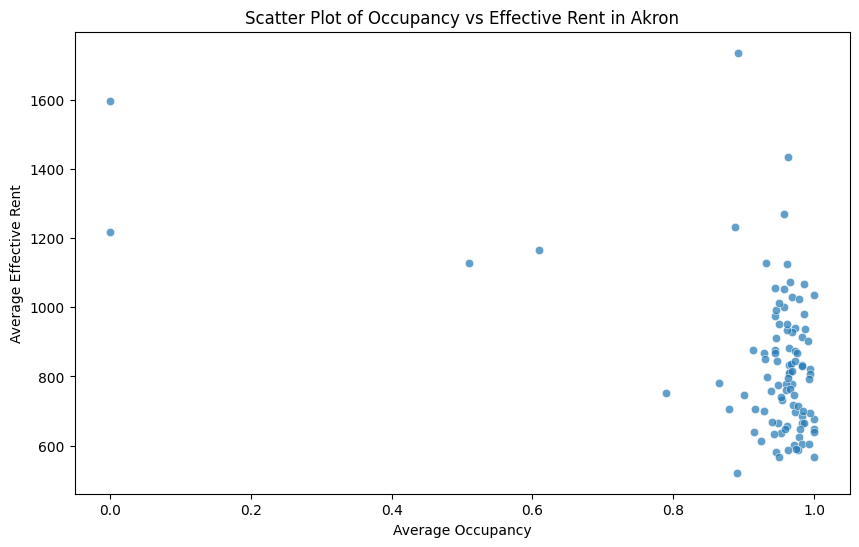

In [156]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x=MSA2_cleaned_sheets['Occ_&_Concession']['Avg_Occupancy'], 
    y=MSA2_cleaned_sheets['Rent']['Avg_Effective_Rent'], 
    alpha=0.7
)
plt.xlabel("Average Occupancy")
plt.ylabel("Average Effective Rent")
plt.title("Scatter Plot of Occupancy vs Effective Rent in Akron")
plt.show()

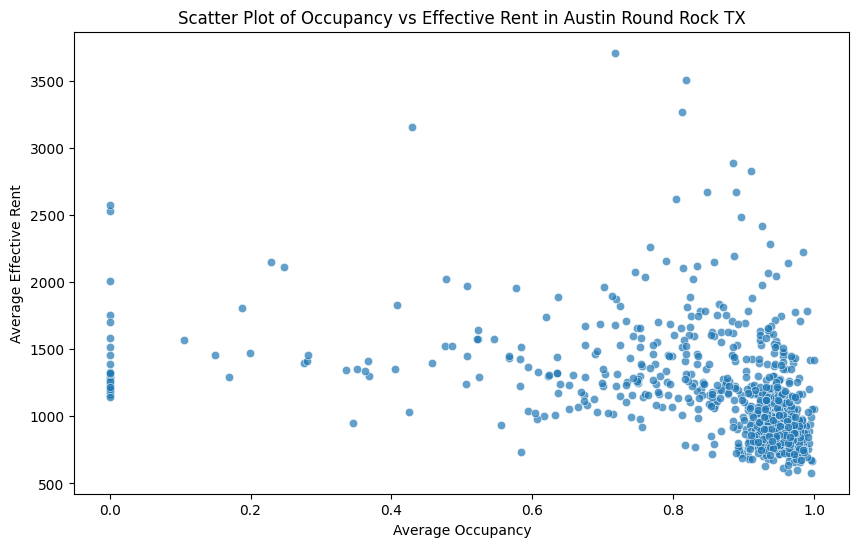

In [155]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x=MSA1_cleaned_sheets['Occ_&_Concession']['Avg_Occupancy'], 
    y=MSA1_cleaned_sheets['Rent']['Avg_Effective_Rent'], 
    alpha=0.7
)
plt.xlabel("Average Occupancy")
plt.ylabel("Average Effective Rent")
plt.title("Scatter Plot of Occupancy vs Effective Rent in Austin Round Rock TX")
plt.show()

In Akron, there's significant clustering of properties at high occupancy rates (0.9-1.0) with a wide rent range ($600-1400), suggesting price diversity even among fully occupied properties.
Austin Round Rock shows higher overall rent prices (mostly $1000-3700) with similar clustering at high occupancy, but also has more properties spread across all occupancy levels, indicating a more diverse market with both struggling and thriving properties.
Both markets have outliers - a few properties with very low occupancy but high rents, possibly indicating luxury properties or those with recent changes in strategy.

In [134]:
MSA1_cleaned_sheets['Occ_&_Concession']

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305              2  30.30917 -97.72881     NaN   
1        Travis    001716              2  30.36687 -97.79303     NaN   
2        Travis    001860              2  30.45009 -97.64873     NaN   
3        Travis    000604              3  30.28462 -97.74723     NaN   
4    Williamson    020312              2  30.57164 -97.87028     NaN   
..          ...       ...            ...       ...       ...     ...   
864      Travis    001817              1  30.36689 -97.72829     NaN   
865        Hays    010804              3  30.03098 -98.10173     NaN   
866      Travis    001806              3  30.34684  -97.6966     NaN   
867      Travis    002005              1  30.23269 -97.78612     NaN   
868      Travis    001707              2  30.37337 -97.75408     NaN   

0                      True Owner           ManagementCompany    ProjID  \
0                 Privately Owned          MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital           Weller Management     14466   
2      Castle Lanterra Properties    Lincoln Property Company     89519   
3          Texla Housing Partners      Texla Housing Partners     43056   
4          NE Property Management      NE Property Management  10255043   
..                            ...                         ...       ...   
864    Churchill Forge Properties  Churchill Forge Properties     18419   
865      Sendera Investment Group            Merge Management     79577   
866           DTI Investments Inc         DTI Investments Inc     69991   
867            Martine Properties          Martine Properties     88278   
868                 Nitya Capital   Karya Property Management     87479   

0                    Submarket                         Name  \
0            Near North Austin                    108 Place   
1              Far West Austin      10X Living at Grandview   
2    Pflugerville/Wells Branch                1825 Cottages   
3          Downtown/University                     21 Pearl   
4                   Cedar Park          22 North Apartments   
..                         ...                          ...   
864          Near North Austin                    Woodchase   
865                 San Marcos         Woodcreek Apartments   
866       North Central Austin  Woodland Heights Apartments   
867               South Austin            Woods at Manchaca   
868                  Arboretum                    Woodstone   

0                        Address          City State    Zip       Phone  \
0                  108 W 45th St        Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   
3                  911 W 21st St        Austin    TX  78705  5124730808   
4                149 S Bagdad Rd       Leander    TX  78641  5129868727   
..                           ...           ...   ...    ...         ...   
864               8524 Burnet Rd        Austin    TX  78757  5124208341   
865         

NEW FEATURE: PROPERTY TRUST INDEX - Rehabilitation Index, Market Grade, Submarket grade, Property Age Score

PAS gives higher scores to newer properties and lower scores to older ones.
The formula ensures newer properties (built recently) get a PAS closer to 1, while older ones get a lower score.

Then, Min-Max normalization is applied to scale the values between 0 and 1, where:
1 means a newly built property.
0 means the oldest property in the dataset.

Purpose of RI :Rehabilitation work improves property trust, so we assign a score based on when rehab was last done.

Default RI = 0 (no rehabilitation).
Properties rehabilitated after 2015 get a score of 1.
Properties rehabilitated before 2015 get a score of 0.5.

Property Trust Index (PTI) - PTI is a weighted combination of market strength, submarket strength, property age, and rehab impact. Here I have taken random weights but can be upgraded and assigned using analysis. (40% for market Grade, 30% for SubMarket Grade, 20% for Property Age Score and 10% for Rehabilitation Index )

In [135]:
from sklearn.preprocessing import MinMaxScaler

def calculate_pti(df):
    """
    Calculates the Property Trust Index (PTI) for each property in the dataset.
    
    Args:
    df (pd.DataFrame): The dataset containing necessary property details.

    Returns:
    pd.DataFrame: Updated dataset with PTI scores.
    """

    # **Step 1: Normalize Property Age Score (PAS)**
    df["Property_Age"] = 2020 - df["YearBuilt"]  # Assuming 2025 as the current year
    min_age = df["Property_Age"].min()
    max_age = df["Property_Age"].max()

    df["PAS_normalized"] = 1 - ((df["Property_Age"] - min_age) / (max_age - min_age))

    # **Step 2: Assign Rehabilitation Impact (RI)**
    df["RI"] = 0.0 # Default
    df.loc[df["Rehab1"] >= 2015, "RI"] = 1
    df.loc[(df["Rehab1"] > 0) & (df["Rehab1"] < 2015), "RI"] = 0.5

    df["RI"] = df["RI"].astype(float)
    # **Step 3: Calculate PTI Score**
    df["PTI"] = (
        (0.4 * df["Market_Grade_Avg"]) +
        (0.3 * df["SubMarket_Grade_Avg"]) +
        (0.2 * df["PAS_normalized"]) +
        (0.1 * df["RI"])
    )

    return df

In [136]:
MSA1_cleaned_sheets["Asset_Class"] = calculate_pti(MSA1_cleaned_sheets["Asset_Class"])


In [137]:
MSA2_cleaned_sheets["Asset_Class"] = calculate_pti(MSA2_cleaned_sheets["Asset_Class"])


In [138]:
MSA1_cleaned_sheets["Asset_Class"][MSA1_cleaned_sheets["Asset_Class"]["RI"] == 0.5]

0   MarketCode             MarketName StateCode StateName CountyCode  \
21       12420  Austin-Round Rock, TX        TX     Texas        453   
24       12420  Austin-Round Rock, TX        TX     Texas        453   
45       12420  Austin-Round Rock, TX        TX     Texas        491   
71       12420  Austin-Round Rock, TX        TX     Texas        453   
72       12420  Austin-Round Rock, TX        TX     Texas        209   
87       12420  Austin-Round Rock, TX        TX     Texas        453   
132      12420  Austin-Round Rock, TX        TX     Texas        491   
214      12420  Austin-Round Rock, TX        TX     Texas        453   
222      12420  Austin-Round Rock, TX        TX     Texas        491   
223      12420  Austin-Round Rock, TX        TX     Texas        491   
235      12420  Austin-Round Rock, TX        TX     Texas        453   
255      12420  Austin-Round Rock, TX        TX     Texas        453   
275      12420  Austin-Round Rock, TX        TX     Texas        491   
317      12420  Austin-Round Rock, TX        TX     Texas        453   
319      12420  Austin-Round Rock, TX        TX     Texas        453   
325      12420  Austin-Round Rock, TX        TX     Texas        453   
349      12420  Austin-Round Rock, TX        TX     Texas        453   
356      12420  Austin-Round Rock, TX        TX     Texas        209   
358      12420  Austin-Round Rock, TX        TX     Texas        453   
407      12420  Austin-Round Rock, TX        TX     Texas        453   
421      12420  Austin-Round Rock, TX        TX     Texas        453   
422      12420  Austin-Round Rock, TX        TX     Texas        453   
448      12420  Austin-Round Rock, TX        TX     Texas        453   
468      12420  Austin-Round Rock, TX        TX     Texas        453   
471      12420  Austin-Round Rock, TX        TX     Texas        453   
491      12420  Austin-Round Rock, TX        TX     Texas        453   
576      12420  Austin-Round Rock, TX        TX     Texas        453   
581      12420  Austin-Round Rock, TX        TX     Texas        453   
588      12420  Austin-Round Rock, TX        TX     Texas        453   
684      12420  Austin-Round Rock, TX        TX     Texas        453   
709      12420  Austin-Round Rock, TX        TX     Texas        453   
720      12420  Austin-Round Rock, TX        TX     Texas        453   
732      12420  Austin-Round Rock, TX        TX     Texas        453   
784      12420  Austin-Round Rock, TX        TX     Texas        453   
813      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
21       Travis    001752              3  30.35582  -97.7546     NaN   
24       Travis    001811              2  30.32819 -97.67929     NaN   
45   Williamson    020704              2  30.49674 -97.66829     NaN   
71       Travis    001818              2  30.36164 -97.71829     NaN   
72         Hays    010303              3  29.89417 -97.91214     NaN   
87       Travis    001911              2  30.25632 -97.79599     NaN   
132  Williamson    020602              2  30.51647 -97.69301     NaN   
214      Travis    001834              1  30.33064 -97.66556     NaN   
222  Williamson    020322              4  30.50071 -97.82014     NaN   
223  Williamson    020322              4  30.50071 -97.82014     NaN   
235      Travis    002315              1  30.23466 -97.73177     NaN   
255      Travis    001754              2  30.40274 -97.74176     NaN   
275  Williamson    021502              1  30.53072 -97.67432     NaN   
317      Travis    001403              1  30.23374 -97.73766     NaN   
319      Travis    002314              3  30.22964 -97.72124     NaN   
325      Travis    002202              2   30.2967 -97.62561     NaN   
349      Travis    001503              3  30.33089 -97.72202     NaN   
356        Hays    010701              3  29.90092 -97.95814     NaN   
358      Travis    001915              

In [139]:
MSA2_cleaned_sheets["Asset_Class"][MSA2_cleaned_sheets["Asset_Class"]["RI"] == 0.5]

0  MarketCode MarketName StateCode StateName CountyCode CountyName TractCode  \
10      10420  Akron, OH        OH      Ohio        133    Portage    601502   

0  BlockGroupCode  Latitude Longitude ETAKInd                     True Owner  \
10              2  41.14666 -81.33381     NaN  Windsor Realty and Management   

0               ManagementCompany ProjID            Submarket            Name  \
10  Windsor Realty and Management     64  Kent/Portage County  College Towers   

0          Address  City State    Zip       Phone YearBuilt Rehab1 Rehab2  \
10  1800 Rhodes Rd  Kent    OH  44240  3306780746      1970   2014    NaN   

0  Rehab3 Quantity AreaPerUnit Level Neighborhood Status  Market_Grade_Avg  \
10    NaN      457         680     3          NaN      S               3.0   

0   SubMarket_Grade_Avg Property_Age PAS_normalized   RI       PTI  
10                  3.5           50       0.632353  0.5  2.426471

In [140]:
MSA1_cleaned_sheets['Occ_&_Concession']

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305              2  30.30917 -97.72881     NaN   
1        Travis    001716              2  30.36687 -97.79303     NaN   
2        Travis    001860              2  30.45009 -97.64873     NaN   
3        Travis    000604              3  30.28462 -97.74723     NaN   
4    Williamson    020312              2  30.57164 -97.87028     NaN   
..          ...       ...            ...       ...       ...     ...   
864      Travis    001817              1  30.36689 -97.72829     NaN   
865        Hays    010804              3  30.03098 -98.10173     NaN   
866      Travis    001806              3  30.34684  -97.6966     NaN   
867      Travis    002005              1  30.23269 -97.78612     NaN   
868      Travis    001707              2  30.37337 -97.75408     NaN   

0                      True Owner           ManagementCompany    ProjID  \
0                 Privately Owned          MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital           Weller Management     14466   
2      Castle Lanterra Properties    Lincoln Property Company     89519   
3          Texla Housing Partners      Texla Housing Partners     43056   
4          NE Property Management      NE Property Management  10255043   
..                            ...                         ...       ...   
864    Churchill Forge Properties  Churchill Forge Properties     18419   
865      Sendera Investment Group            Merge Management     79577   
866           DTI Investments Inc         DTI Investments Inc     69991   
867            Martine Properties          Martine Properties     88278   
868                 Nitya Capital   Karya Property Management     87479   

0                    Submarket                         Name  \
0            Near North Austin                    108 Place   
1              Far West Austin      10X Living at Grandview   
2    Pflugerville/Wells Branch                1825 Cottages   
3          Downtown/University                     21 Pearl   
4                   Cedar Park          22 North Apartments   
..                         ...                          ...   
864          Near North Austin                    Woodchase   
865                 San Marcos         Woodcreek Apartments   
866       North Central Austin  Woodland Heights Apartments   
867               South Austin            Woods at Manchaca   
868                  Arboretum                    Woodstone   

0                        Address          City State    Zip       Phone  \
0                  108 W 45th St        Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   
3                  911 W 21st St        Austin    TX  78705  5124730808   
4                149 S Bagdad Rd       Leander    TX  78641  5129868727   
..                           ...           ...   ...    ...         ...   
864               8524 Burnet Rd        Austin    TX  78757  5124208341   
865         

In [146]:
occupancy_akron.shape

(99, 182)

NEW FEATURE: Let's See Lease_up Months for different Properties

In [141]:
def calculate_lease_up_months(occupancy_df, delivered_df):
    """
    Adds a column indicating the number of months a property took to reach 90% occupancy.
    
    Args:
        occupancy_df (pd.DataFrame): Occupancy dataset excluding last two columns.
        delivered_df (pd.DataFrame): Delivered properties DataFrame.
    
    Returns:
        pd.DataFrame: Occupancy DataFrame with 'Lease_Up_Months' column added.
    """
    lease_up_months_dict = {}

    # Filter occupancy data for delivered properties only
    delivered_occupancy_df = occupancy_df[occupancy_df["ProjID"].isin(delivered_df["ProjID"])]

    for index, row in delivered_occupancy_df.iterrows():
        proj_id = row["ProjID"]

        # Extract only occupancy values (excluding first 30 non-month columns & last two columns)
        occupancy_values = row.iloc[30:-2].values  
        months = occupancy_df.columns[30:-2]  # Only consider month columns

        # Find first valid occupancy record (ignore NaNs)
        first_valid_index = np.where(~pd.isna(occupancy_values))[0]
        if len(first_valid_index) == 0:
            continue  # Skip if no valid occupancy data

        first_valid_index = first_valid_index[0]  # First non-NaN occupancy value
        first_value = occupancy_values[first_valid_index]  # First recorded occupancy rate

        # Find when occupancy reaches 90%
        lease_up_index = np.where(occupancy_values[first_valid_index:] >= 0.90)[0]
        if len(lease_up_index) == 0:
            continue  # Skip if never reaches 90%

        lease_up_start = first_valid_index  # Lease-up start month index
        lease_up_end = lease_up_index[0] + lease_up_start  # Month when occupancy hits 90%

        # Compute lease-up duration
        lease_up_months = len(months[lease_up_start:lease_up_end + 1])

        lease_up_months_dict[proj_id] = lease_up_months

    # Map results back to main occupancy DataFrame
    occupancy_df["Lease_Up_Months"] = occupancy_df["ProjID"].map(lease_up_months_dict)

    return occupancy_df

In [150]:
occupancy_akron = calculate_lease_up_months(
    occupancy_akron, delivered_Akron
)

In [151]:
occupancy_akron['Lease_Up_Months'].nunique()

2

In [152]:
occupancy_austin = calculate_lease_up_months(
    occupancy_austin, delivered_Austin
)

In [153]:
occupancy_austin

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305              2  30.30917 -97.72881     NaN   
1        Travis    001716              2  30.36687 -97.79303     NaN   
2        Travis    001860              2  30.45009 -97.64873     NaN   
3        Travis    000604              3  30.28462 -97.74723     NaN   
4    Williamson    020312              2  30.57164 -97.87028     NaN   
..          ...       ...            ...       ...       ...     ...   
864      Travis    001817              1  30.36689 -97.72829     NaN   
865        Hays    010804              3  30.03098 -98.10173     NaN   
866      Travis    001806              3  30.34684  -97.6966     NaN   
867      Travis    002005              1  30.23269 -97.78612     NaN   
868      Travis    001707              2  30.37337 -97.75408     NaN   

0                      True Owner           ManagementCompany    ProjID  \
0                 Privately Owned          MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital           Weller Management     14466   
2      Castle Lanterra Properties    Lincoln Property Company     89519   
3          Texla Housing Partners      Texla Housing Partners     43056   
4          NE Property Management      NE Property Management  10255043   
..                            ...                         ...       ...   
864    Churchill Forge Properties  Churchill Forge Properties     18419   
865      Sendera Investment Group            Merge Management     79577   
866           DTI Investments Inc         DTI Investments Inc     69991   
867            Martine Properties          Martine Properties     88278   
868                 Nitya Capital   Karya Property Management     87479   

0                    Submarket                         Name  \
0            Near North Austin                    108 Place   
1              Far West Austin      10X Living at Grandview   
2    Pflugerville/Wells Branch                1825 Cottages   
3          Downtown/University                     21 Pearl   
4                   Cedar Park          22 North Apartments   
..                         ...                          ...   
864          Near North Austin                    Woodchase   
865                 San Marcos         Woodcreek Apartments   
866       North Central Austin  Woodland Heights Apartments   
867               South Austin            Woods at Manchaca   
868                  Arboretum                    Woodstone   

0                        Address          City State    Zip       Phone  \
0                  108 W 45th St        Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   
3                  911 W 21st St        Austin    TX  78705  5124730808   
4                149 S Bagdad Rd       Leander    TX  78641  5129868727   
..                           ...           ...   ...    ...         ...   
864               8524 Burnet Rd        Austin    TX  78757  5124208341   
865         

In [157]:
if "Lease_Up_Months" in occupancy_austin.columns:
    MSA1_cleaned_sheets["Occ_&_Concession"]["Lease_Up_Months"] = occupancy_austin["Lease_Up_Months"]

if "Lease_Up_Months" in occupancy_akron.columns:
    MSA2_cleaned_sheets["Occ_&_Concession"]["Lease_Up_Months"] = occupancy_akron["Lease_Up_Months"]

In [158]:
MSA1_cleaned_sheets['Occ_&_Concession']

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305              2  30.30917 -97.72881     NaN   
1        Travis    001716              2  30.36687 -97.79303     NaN   
2        Travis    001860              2  30.45009 -97.64873     NaN   
3        Travis    000604              3  30.28462 -97.74723     NaN   
4    Williamson    020312              2  30.57164 -97.87028     NaN   
..          ...       ...            ...       ...       ...     ...   
864      Travis    001817              1  30.36689 -97.72829     NaN   
865        Hays    010804              3  30.03098 -98.10173     NaN   
866      Travis    001806              3  30.34684  -97.6966     NaN   
867      Travis    002005              1  30.23269 -97.78612     NaN   
868      Travis    001707              2  30.37337 -97.75408     NaN   

0                      True Owner           ManagementCompany    ProjID  \
0                 Privately Owned          MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital           Weller Management     14466   
2      Castle Lanterra Properties    Lincoln Property Company     89519   
3          Texla Housing Partners      Texla Housing Partners     43056   
4          NE Property Management      NE Property Management  10255043   
..                            ...                         ...       ...   
864    Churchill Forge Properties  Churchill Forge Properties     18419   
865      Sendera Investment Group            Merge Management     79577   
866           DTI Investments Inc         DTI Investments Inc     69991   
867            Martine Properties          Martine Properties     88278   
868                 Nitya Capital   Karya Property Management     87479   

0                    Submarket                         Name  \
0            Near North Austin                    108 Place   
1              Far West Austin      10X Living at Grandview   
2    Pflugerville/Wells Branch                1825 Cottages   
3          Downtown/University                     21 Pearl   
4                   Cedar Park          22 North Apartments   
..                         ...                          ...   
864          Near North Austin                    Woodchase   
865                 San Marcos         Woodcreek Apartments   
866       North Central Austin  Woodland Heights Apartments   
867               South Austin            Woods at Manchaca   
868                  Arboretum                    Woodstone   

0                        Address          City State    Zip       Phone  \
0                  108 W 45th St        Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   
3                  911 W 21st St        Austin    TX  78705  5124730808   
4                149 S Bagdad Rd       Leander    TX  78641  5129868727   
..                           ...           ...   ...    ...         ...   
864               8524 Burnet Rd        Austin    TX  78757  5124208341   
865         

In [159]:
MSA2_cleaned_sheets['Occ_&_Concession']

0  MarketCode MarketName StateCode StateName CountyCode CountyName TractCode  \
0       10420  Akron, OH        OH      Ohio        153     Summit    509000   
1       10420  Akron, OH        OH      Ohio        153     Summit    530104   
2       10420  Akron, OH        OH      Ohio        153     Summit    508301   
3       10420  Akron, OH        OH      Ohio        153     Summit    530603   
4       10420  Akron, OH        OH      Ohio        153     Summit    530401   
..        ...        ...       ...       ...        ...        ...       ...   
94      10420  Akron, OH        OH      Ohio        133    Portage    600800   
95      10420  Akron, OH        OH      Ohio        133    Portage    600401   
96      10420  Akron, OH        OH      Ohio        153     Summit    506100   
97      10420  Akron, OH        OH      Ohio        153     Summit    530603   
98      10420  Akron, OH        OH      Ohio        153     Summit    520106   

0  BlockGroupCode  Latitude Longitude ETAKInd                    True Owner  \
0               1  41.07457 -81.49274     NaN                           NaN   
1               4  41.31766 -81.44473     NaN             Gross Residential   
2               1  41.08116 -81.51936     NaN             Bower Development   
3               1  41.17892 -81.48353     NaN        Botnick Realty Company   
4               1  41.17894 -81.43911     NaN                 Banyan Living   
..            ...       ...       ...     ...                           ...   
94              1  41.16758 -81.23151     NaN  Simco Management Corporation   
95              1  41.26366  -81.3641     NaN      Elon Property Management   
96              6  41.11091 -81.57355     NaN            AIY Properties Inc   
97              1  41.17923 -81.48822     NaN       PNC Real Estate Finance   
98              2  41.12067 -81.46037     NaN          BROOKWOOD MANAGEMENT   

0              ManagementCompany    ProjID            Submarket  \
0                            NaN  10258733  South Summit County   
1              Gross Residential     13558  North Summit County   
2              Bower Development     87610  South Summit County   
3         Botnick Realty Company     17397  North Summit County   
4                    KALO Living     67674  North Summit County   
..                           ...       ...                  ...   
94  Simco Management Corporation     62083  Kent/Portage County   
95      Elon Property Management  10000315  Kent/Portage County   
96            AIY Properties Inc     17335  South Summit County   
97             Gross Residential     17396  North Summit County   
98          BROOKWOOD MANAGEMENT     68394  North Summit County   

0                     Name                    Address            City State  \
0   797 Residence & Suites            797 E Market St           Akron    OH   
1               Arbor Glen         2639 Arbor Glen Dr       Twinsburg    OH   
2          Bowery District              156 S Main St           Akron    OH   
3              Bridgewater      4172 Bridgewater Pkwy            Stow    OH   
4           Brighton Place             4175 Darrow Rd            Stow    OH   
..                     ...                        ...             ...   ...   
94          Woodgate North                709 Sapp Rd         Ravenna    OH   
95               Woodlands               833 Frost Rd     Streetsboro    OH   
96       Woods of Fairlawn                17 Manor Rd           Akron    OH   
97           Wyndham Ridge      4020 Wyndham Ridge Dr            Stow    OH   
98         Yorkshire Woods  1305 Buckingham Gate Blvd  Cuyahoga Falls    OH   

0     Zip       Phone YearBuilt Rehab1 Rehab2 Rehab3 Quantity AreaPerUnit  \
0   44305  3306175777      2019    NaN    NaN    NaN       60         959   
1   44087  3309633360      2002    NaN    NaN    NaN      288        1007   
2   44308  3306183469      2020    NaN    NaN    NaN       92         897   
3   44224  3309283121      1

In [160]:
MSA1_cleaned_sheets["Occ_&_Concession"]["Lease_Up_Months"] = (
    MSA1_cleaned_sheets["Occ_&_Concession"]["Lease_Up_Months"].fillna(0)
)

MSA2_cleaned_sheets["Occ_&_Concession"]["Lease_Up_Months"] = (
    MSA2_cleaned_sheets["Occ_&_Concession"]["Lease_Up_Months"].fillna(0)
)

In [161]:
MSA1_cleaned_sheets['Occ_&_Concession']

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305              2  30.30917 -97.72881     NaN   
1        Travis    001716              2  30.36687 -97.79303     NaN   
2        Travis    001860              2  30.45009 -97.64873     NaN   
3        Travis    000604              3  30.28462 -97.74723     NaN   
4    Williamson    020312              2  30.57164 -97.87028     NaN   
..          ...       ...            ...       ...       ...     ...   
864      Travis    001817              1  30.36689 -97.72829     NaN   
865        Hays    010804              3  30.03098 -98.10173     NaN   
866      Travis    001806              3  30.34684  -97.6966     NaN   
867      Travis    002005              1  30.23269 -97.78612     NaN   
868      Travis    001707              2  30.37337 -97.75408     NaN   

0                      True Owner           ManagementCompany    ProjID  \
0                 Privately Owned          MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital           Weller Management     14466   
2      Castle Lanterra Properties    Lincoln Property Company     89519   
3          Texla Housing Partners      Texla Housing Partners     43056   
4          NE Property Management      NE Property Management  10255043   
..                            ...                         ...       ...   
864    Churchill Forge Properties  Churchill Forge Properties     18419   
865      Sendera Investment Group            Merge Management     79577   
866           DTI Investments Inc         DTI Investments Inc     69991   
867            Martine Properties          Martine Properties     88278   
868                 Nitya Capital   Karya Property Management     87479   

0                    Submarket                         Name  \
0            Near North Austin                    108 Place   
1              Far West Austin      10X Living at Grandview   
2    Pflugerville/Wells Branch                1825 Cottages   
3          Downtown/University                     21 Pearl   
4                   Cedar Park          22 North Apartments   
..                         ...                          ...   
864          Near North Austin                    Woodchase   
865                 San Marcos         Woodcreek Apartments   
866       North Central Austin  Woodland Heights Apartments   
867               South Austin            Woods at Manchaca   
868                  Arboretum                    Woodstone   

0                        Address          City State    Zip       Phone  \
0                  108 W 45th St        Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   
3                  911 W 21st St        Austin    TX  78705  5124730808   
4                149 S Bagdad Rd       Leander    TX  78641  5129868727   
..                           ...           ...   ...    ...         ...   
864               8524 Burnet Rd        Austin    TX  78757  5124208341   
865         

In [163]:
occ_con_cols = ["ProjID", "Avg_Occupancy", "Avg_Occupancy_During_Lease_Up", "Avg_Concession", "Lease_Up_Months"]
asset_class_cols = ["ProjID", "Market_Grade_Avg", "SubMarket_Grade_Avg", "Property_Age", "PAS_normalized", "RI", "PTI"]

# Merge function
def merge_features(rent_df, occ_df, asset_df):
    # Merge occupancy & concession data
    rent_df = rent_df.merge(occ_df[occ_con_cols], on="ProjID", how="left")
    
    # Merge asset class data
    rent_df = rent_df.merge(asset_df[asset_class_cols], on="ProjID", how="left")

    return rent_df

# Apply for both markets
MSA1_cleaned_sheets["Rent"] = merge_features(
    MSA1_cleaned_sheets["Rent"], MSA1_cleaned_sheets["Occ_&_Concession"], MSA1_cleaned_sheets["Asset_Class"]
)

MSA2_cleaned_sheets["Rent"] = merge_features(
    MSA2_cleaned_sheets["Rent"], MSA2_cleaned_sheets["Occ_&_Concession"], MSA2_cleaned_sheets["Asset_Class"]
)

In [166]:
MSA1_cleaned_sheets['Rent']

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305              2  30.30917 -97.72881     NaN   
1        Travis    001716              2  30.36687 -97.79303     NaN   
2        Travis    001860              2  30.45009 -97.64873     NaN   
3        Travis    000604              3  30.28462 -97.74723     NaN   
4    Williamson    020312              2  30.57164 -97.87028     NaN   
..          ...       ...            ...       ...       ...     ...   
864      Travis    001817              1  30.36689 -97.72829     NaN   
865        Hays    010804              3  30.03098 -98.10173     NaN   
866      Travis    001806              3  30.34684  -97.6966     NaN   
867      Travis    002005              1  30.23269 -97.78612     NaN   
868      Travis    001707              2  30.37337 -97.75408     NaN   

0                      True Owner           ManagementCompany    ProjID  \
0                 Privately Owned          MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital           Weller Management     14466   
2      Castle Lanterra Properties    Lincoln Property Company     89519   
3          Texla Housing Partners      Texla Housing Partners     43056   
4          NE Property Management      NE Property Management  10255043   
..                            ...                         ...       ...   
864    Churchill Forge Properties  Churchill Forge Properties     18419   
865      Sendera Investment Group            Merge Management     79577   
866           DTI Investments Inc         DTI Investments Inc     69991   
867            Martine Properties          Martine Properties     88278   
868                 Nitya Capital   Karya Property Management     87479   

0                    Submarket                         Name  \
0            Near North Austin                    108 Place   
1              Far West Austin      10X Living at Grandview   
2    Pflugerville/Wells Branch                1825 Cottages   
3          Downtown/University                     21 Pearl   
4                   Cedar Park          22 North Apartments   
..                         ...                          ...   
864          Near North Austin                    Woodchase   
865                 San Marcos         Woodcreek Apartments   
866       North Central Austin  Woodland Heights Apartments   
867               South Austin            Woods at Manchaca   
868                  Arboretum                    Woodstone   

0                        Address          City State    Zip       Phone  \
0                  108 W 45th St        Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   
3                  911 W 21st St        Austin    TX  78705  5124730808   
4                149 S Bagdad Rd       Leander    TX  78641  5129868727   
..                           ...           ...   ...    ...         ...   
864               8524 Burnet Rd        Austin    TX  78757  5124208341   
865         

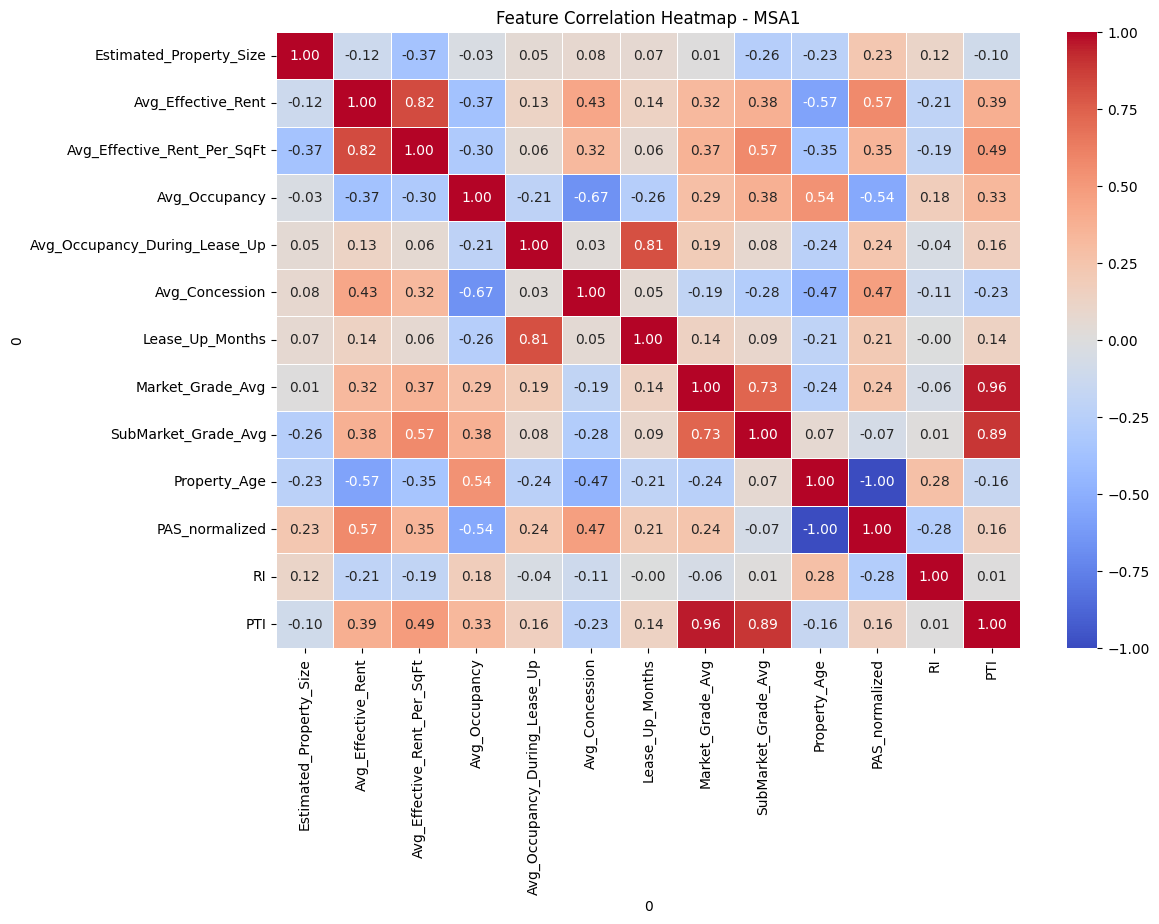

In [169]:
columns_for_correlation = [
    "Estimated_Property_Size", "Avg_Effective_Rent", "Avg_Effective_Rent_Per_SqFt", 
    "Avg_Occupancy", "Avg_Occupancy_During_Lease_Up", "Avg_Concession", "Lease_Up_Months",
    "Market_Grade_Avg", "SubMarket_Grade_Avg", "Property_Age", "PAS_normalized", "RI", "PTI"
]

# Extract the correlation matrix for MSA1 Rent data
corr_matrix_msa1 = MSA1_cleaned_sheets["Rent"][columns_for_correlation].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_msa1, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap - MSA1")
plt.show()

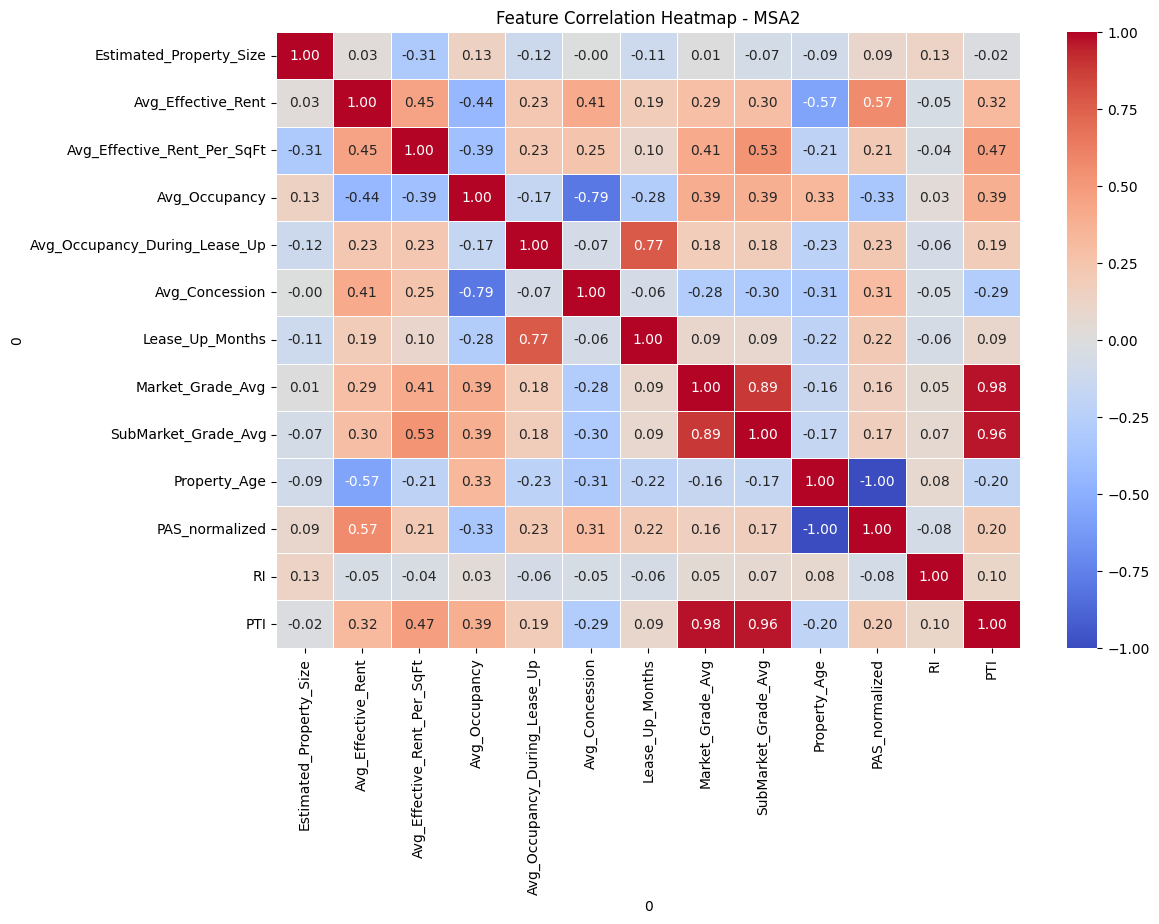

In [175]:
columns_for_correlation = [
    "Estimated_Property_Size", "Avg_Effective_Rent", "Avg_Effective_Rent_Per_SqFt", 
    "Avg_Occupancy", "Avg_Occupancy_During_Lease_Up", "Avg_Concession", "Lease_Up_Months",
    "Market_Grade_Avg", "SubMarket_Grade_Avg", "Property_Age", "PAS_normalized", "RI", "PTI"
]

# Extract the correlation matrix for MSA1 Rent data
corr_matrix_msa2 = MSA2_cleaned_sheets["Rent"][columns_for_correlation].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_msa2, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap - MSA2")
plt.show()

***In both markets, there's a strong negative correlation between occupancy and concessions (MSA1: -0.67, MSA2: -0.79), indicating properties offer more concessions when occupancy is lower to attract tenants.
Market_Grade_Avg and PTI show extremely strong positive correlations in both markets (MSA1: 0.96, MSA2: 0.98), suggesting property quality significantly affects investment performance.
Property_Age and PAS_normalized have perfect negative correlations (-1.00) in both markets, indicating newer properties consistently achieve higher performance assessment scores.***

/var/folders/z2/fm7clqhj5855cx6jvwxrpyc00000gn/T/ipykernel_24614/2796227107.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette="viridis")


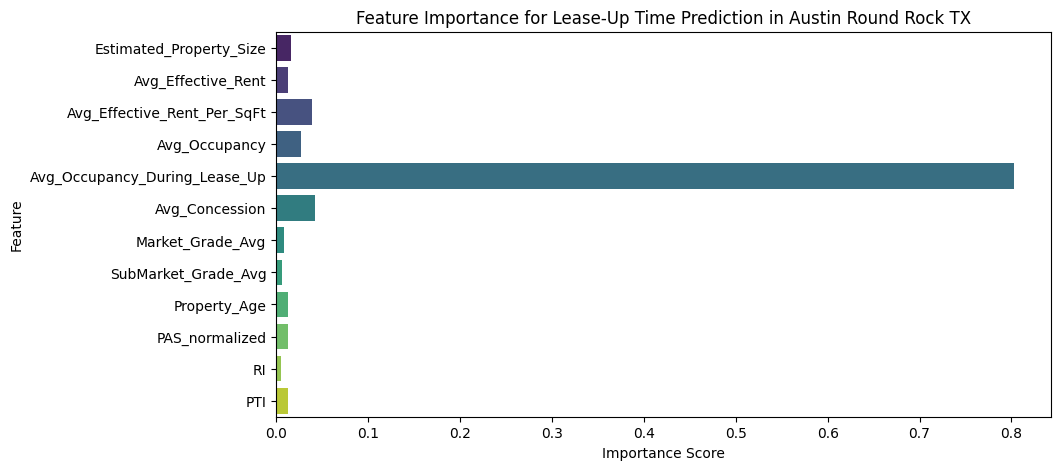

In [178]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Prepare data
df = MSA1_cleaned_sheets["Rent"].dropna(subset=features)
X = df[["Estimated_Property_Size", "Avg_Effective_Rent", "Avg_Effective_Rent_Per_SqFt", 
    "Avg_Occupancy", "Avg_Occupancy_During_Lease_Up", "Avg_Concession", "Market_Grade_Avg", "SubMarket_Grade_Avg", "Property_Age", "PAS_normalized", "RI", "PTI"]]
y = df["Lease_Up_Months"]

# Train a simple model
model = RandomForestRegressor()
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x=importances, y=feature_names, palette="viridis")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance for Lease-Up Time Prediction in Austin Round Rock TX")
plt.show()

Good for Feature Importance for Lease Up Months - Avg Occupancy during Lease Up and Average Eff Rent

/var/folders/z2/fm7clqhj5855cx6jvwxrpyc00000gn/T/ipykernel_24614/2386323846.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette="viridis")


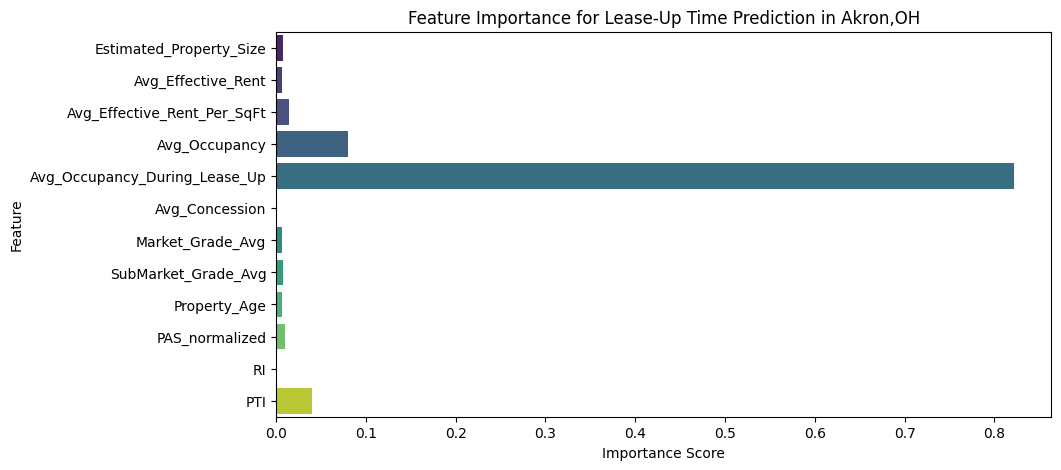

In [177]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Prepare data
df = MSA2_cleaned_sheets["Rent"].dropna(subset=features)
X = df[["Estimated_Property_Size", "Avg_Effective_Rent", "Avg_Effective_Rent_Per_SqFt", 
    "Avg_Occupancy", "Avg_Occupancy_During_Lease_Up", "Avg_Concession", "Market_Grade_Avg", "SubMarket_Grade_Avg", "Property_Age", "PAS_normalized", "RI", "PTI"]]
y = df["Lease_Up_Months"]

# Train a simple model
model = RandomForestRegressor()
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x=importances, y=feature_names, palette="viridis")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance for Lease-Up Time Prediction in Akron,OH")
plt.show()

#Interesting How Occupancy and PTI are showing importance for Akron Market - this can be changed if more data can be there as seen how it changes in Austin Market 

In [173]:
import plotly.express as px

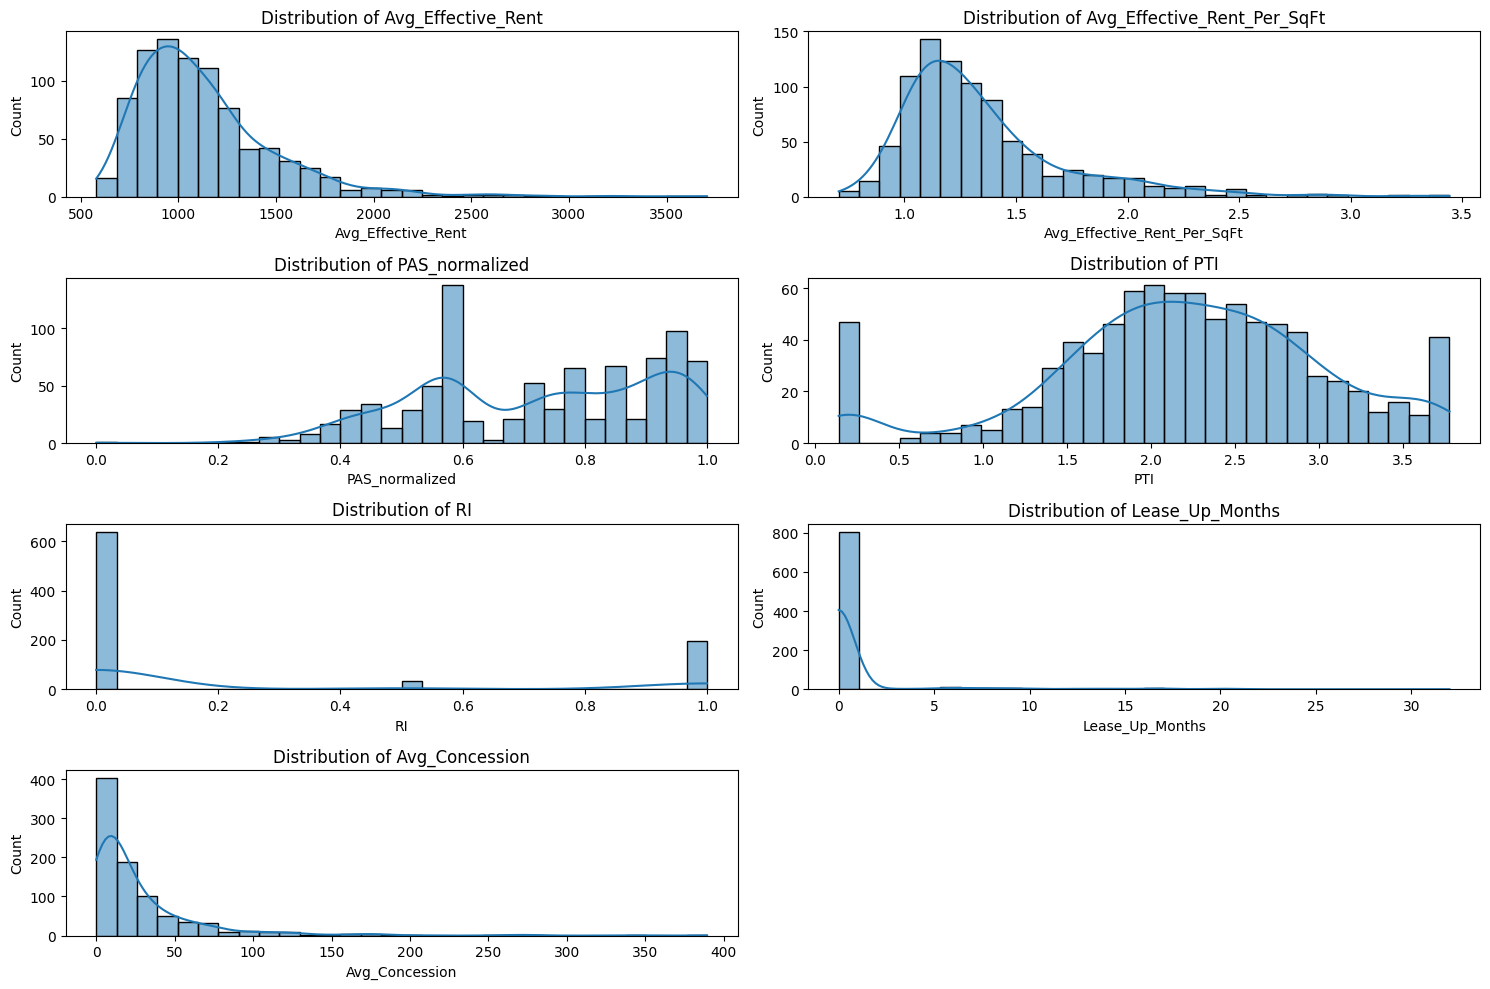

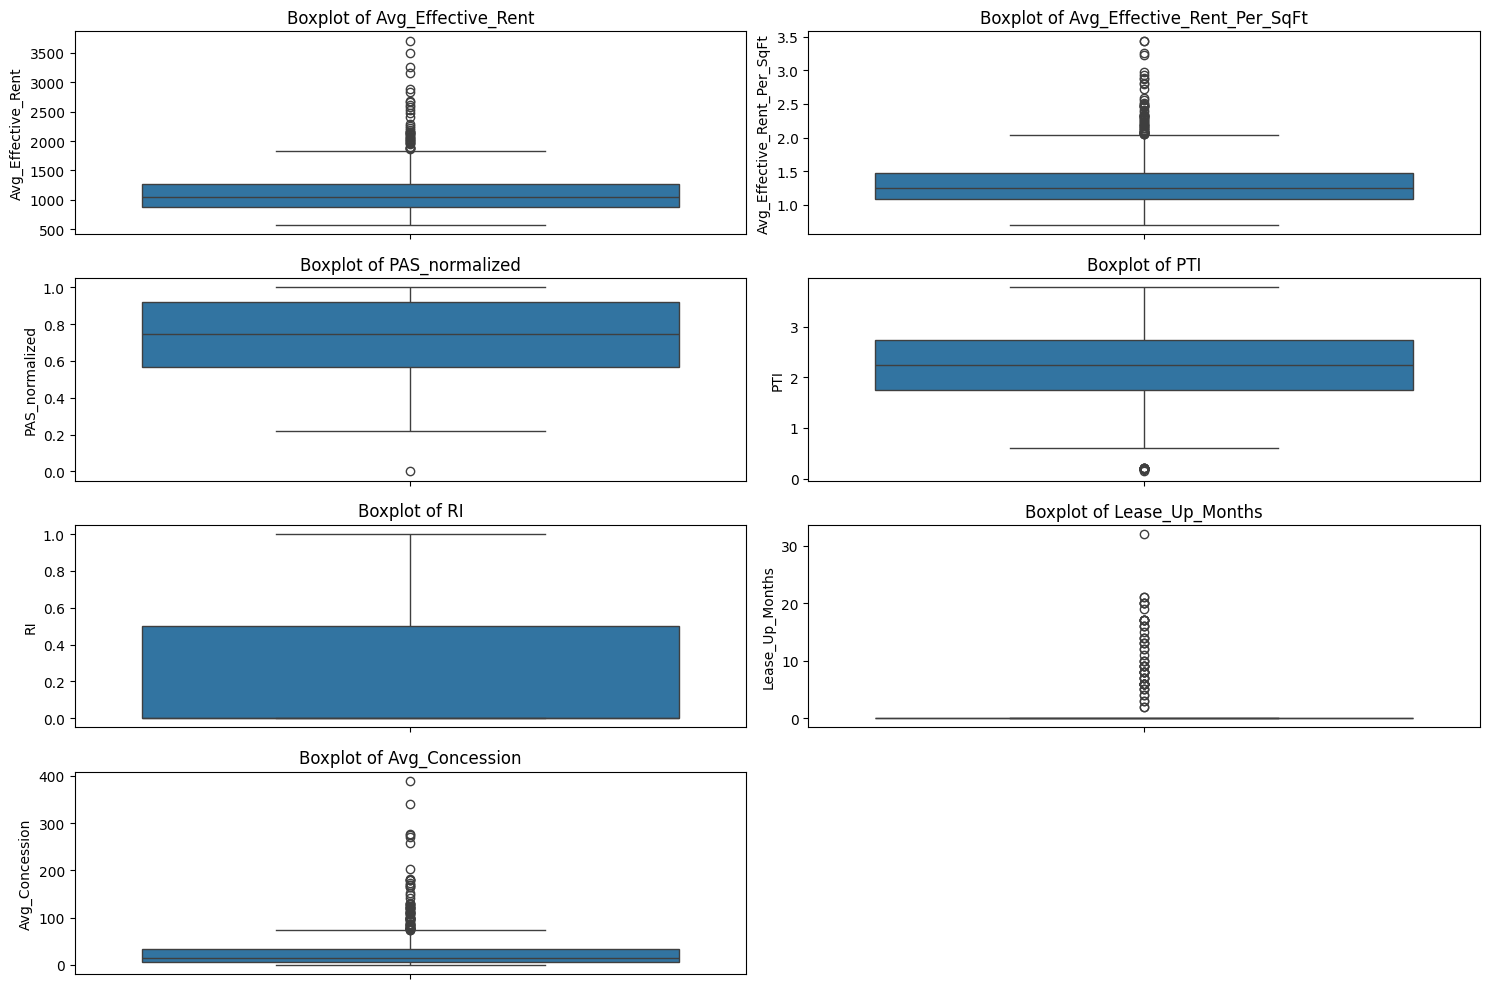

In [180]:
# List of features to visualize
features = [
    "Avg_Effective_Rent", 
    "Avg_Effective_Rent_Per_SqFt", 
    "PAS_normalized", 
    "PTI", 
    "RI", 
    "Lease_Up_Months", 
    "Avg_Concession"
]

# Set figure size
plt.figure(figsize=(15, 10))

# Loop through features to create subplots
for i, feature in enumerate(features, 1):
    plt.subplot(4, 2, i)
    sns.histplot(MSA1_cleaned_sheets["Rent"][feature], bins=30, kde=True)
    plt.title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()

# Boxplots for detecting outliers
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(y=MSA1_cleaned_sheets["Rent"][feature])
    plt.title(f"Boxplot of {feature}")

plt.tight_layout()
plt.show()

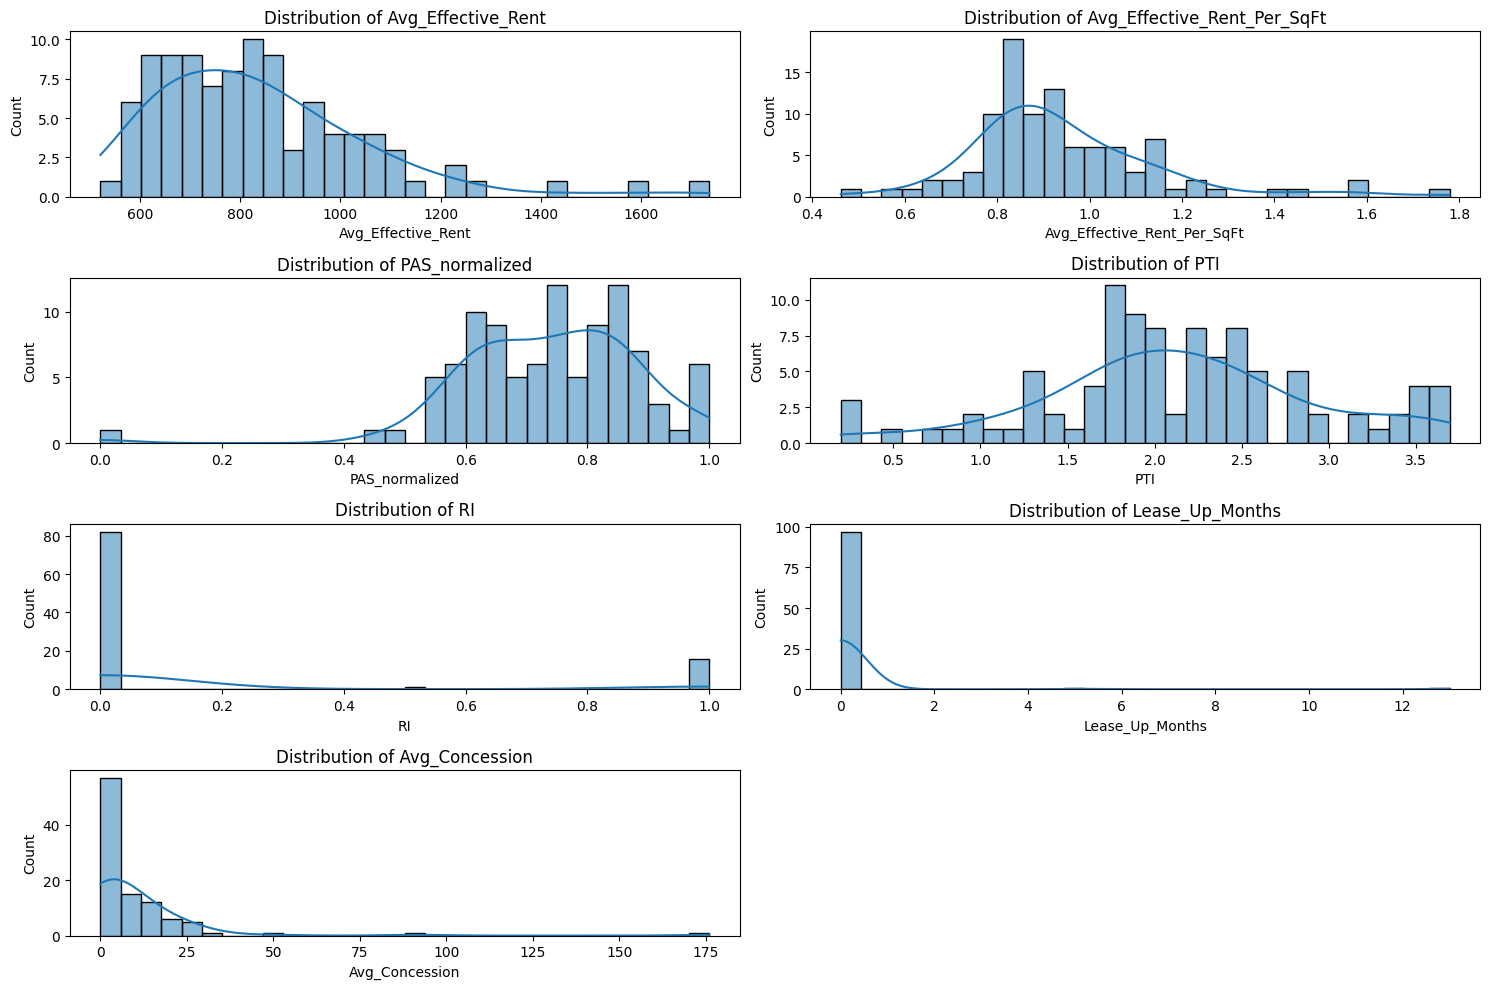

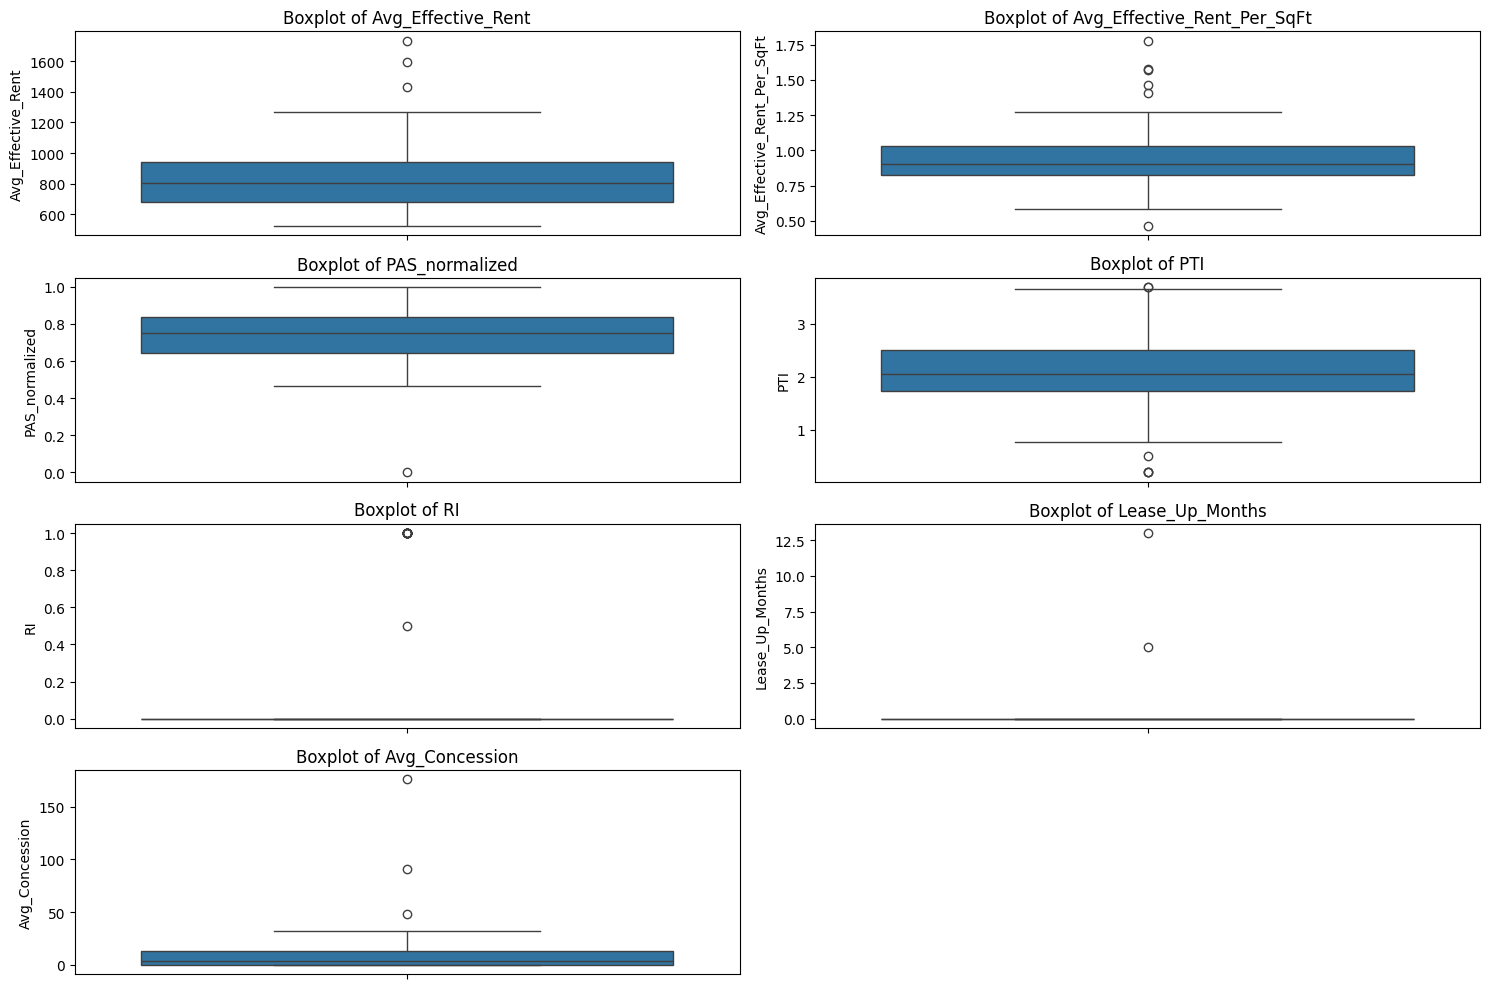

In [181]:
# List of features to visualize
features = [
    "Avg_Effective_Rent", 
    "Avg_Effective_Rent_Per_SqFt", 
    "PAS_normalized", 
    "PTI", 
    "RI", 
    "Lease_Up_Months", 
    "Avg_Concession"
]

# Set figure size
plt.figure(figsize=(15, 10))

# Loop through features to create subplots
for i, feature in enumerate(features, 1):
    plt.subplot(4, 2, i)
    sns.histplot(MSA2_cleaned_sheets["Rent"][feature], bins=30, kde=True)
    plt.title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()

# Boxplots for detecting outliers
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(y=MSA2_cleaned_sheets["Rent"][feature])
    plt.title(f"Boxplot of {feature}")

plt.tight_layout()
plt.show()

In [188]:
sunburst_df = MSA1_cleaned_sheets["Rent"].groupby(["MarketName", "Submarket"]).agg({
    "Market_Grade_Avg": "mean",
    "SubMarket_Grade_Avg": "mean",
    "Avg_Occupancy_During_Lease_Up": "mean",
    "PTI": "mean"
}).reset_index()

# Creating a sunburst chart
fig_sunburst = px.sunburst(
    sunburst_df,
    path=["MarketName", "Submarket"],  # Only Market and Submarket to reduce complexity
    values="PTI",  # Use PTI to represent the size of each slice
    color="Avg_Occupancy_During_Lease_Up",  # Color based on occupancy
    hover_data={"Market_Grade_Avg": True, "SubMarket_Grade_Avg": True},
    color_continuous_scale="blues",
    title="Sunburst Chart of Market, Submarket, and Property Features for Austin Round Rock TX"
)

# Show the sunburst chart
fig_sunburst.show()

Hover Around the Chart 

In [189]:
sunburst_df = MSA2_cleaned_sheets["Rent"].groupby(["MarketName", "Submarket"]).agg({
    "Market_Grade_Avg": "mean",
    "SubMarket_Grade_Avg": "mean",
    "Avg_Occupancy_During_Lease_Up": "mean",
    "PTI": "mean"
}).reset_index()

# Creating a sunburst chart
fig_sunburst = px.sunburst(
    sunburst_df,
    path=["MarketName", "Submarket"],  # Only Market and Submarket to reduce complexity
    values="PTI",  # Use PTI to represent the size of each slice
    color="Avg_Occupancy_During_Lease_Up",  # Color based on occupancy
    hover_data={"Market_Grade_Avg": True, "SubMarket_Grade_Avg": True},
    color_continuous_scale="blues",
    title="Sunburst Chart of Market, Submarket, and Property Features For Akron OH"
)

# Show the sunburst chart
fig_sunburst.show()

In [190]:
MSA1_cleaned_sheets['Rent']

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude ETAKInd  \
0        Travis    000305              2  30.30917 -97.72881     NaN   
1        Travis    001716              2  30.36687 -97.79303     NaN   
2        Travis    001860              2  30.45009 -97.64873     NaN   
3        Travis    000604              3  30.28462 -97.74723     NaN   
4    Williamson    020312              2  30.57164 -97.87028     NaN   
..          ...       ...            ...       ...       ...     ...   
864      Travis    001817              1  30.36689 -97.72829     NaN   
865        Hays    010804              3  30.03098 -98.10173     NaN   
866      Travis    001806              3  30.34684  -97.6966     NaN   
867      Travis    002005              1  30.23269 -97.78612     NaN   
868      Travis    001707              2  30.37337 -97.75408     NaN   

0                      True Owner           ManagementCompany    ProjID  \
0                 Privately Owned          MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital           Weller Management     14466   
2      Castle Lanterra Properties    Lincoln Property Company     89519   
3          Texla Housing Partners      Texla Housing Partners     43056   
4          NE Property Management      NE Property Management  10255043   
..                            ...                         ...       ...   
864    Churchill Forge Properties  Churchill Forge Properties     18419   
865      Sendera Investment Group            Merge Management     79577   
866           DTI Investments Inc         DTI Investments Inc     69991   
867            Martine Properties          Martine Properties     88278   
868                 Nitya Capital   Karya Property Management     87479   

0                    Submarket                         Name  \
0            Near North Austin                    108 Place   
1              Far West Austin      10X Living at Grandview   
2    Pflugerville/Wells Branch                1825 Cottages   
3          Downtown/University                     21 Pearl   
4                   Cedar Park          22 North Apartments   
..                         ...                          ...   
864          Near North Austin                    Woodchase   
865                 San Marcos         Woodcreek Apartments   
866       North Central Austin  Woodland Heights Apartments   
867               South Austin            Woods at Manchaca   
868                  Arboretum                    Woodstone   

0                        Address          City State    Zip       Phone  \
0                  108 W 45th St        Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   
3                  911 W 21st St        Austin    TX  78705  5124730808   
4                149 S Bagdad Rd       Leander    TX  78641  5129868727   
..                           ...           ...   ...    ...         ...   
864               8524 Burnet Rd        Austin    TX  78757  5124208341   
865         

Let's remove missing values 

In [198]:
def missing_value_analysis(df):
    """
    Analyzes missing values in a DataFrame and plots a bar chart of missing values.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    
    Returns:
    pd.DataFrame: A summary DataFrame with missing value percentages.
    """
    # Calculate missing value percentage
    missing_values = df.isnull().sum() / len(df) * 100
    missing_df = missing_values[missing_values > 0].sort_values(ascending=False).to_frame(name="Missing_Percentage")
    missing_df.index.name = "Column"
    missing_df = missing_df.reset_index()

    # Plot bar chart
    plt.figure(figsize=(14, 6))
    sns.barplot(x="Column", y="Missing_Percentage", data=missing_df, palette="coolwarm")
    plt.xticks(rotation=90)  # Rotate column names for better readability
    plt.xlabel("Columns")
    plt.ylabel("Percentage of Missing Values")
    plt.title("Missing Values by Column ")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    
    plt.show()
    
    return missing_df

/var/folders/z2/fm7clqhj5855cx6jvwxrpyc00000gn/T/ipykernel_24614/327760524.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




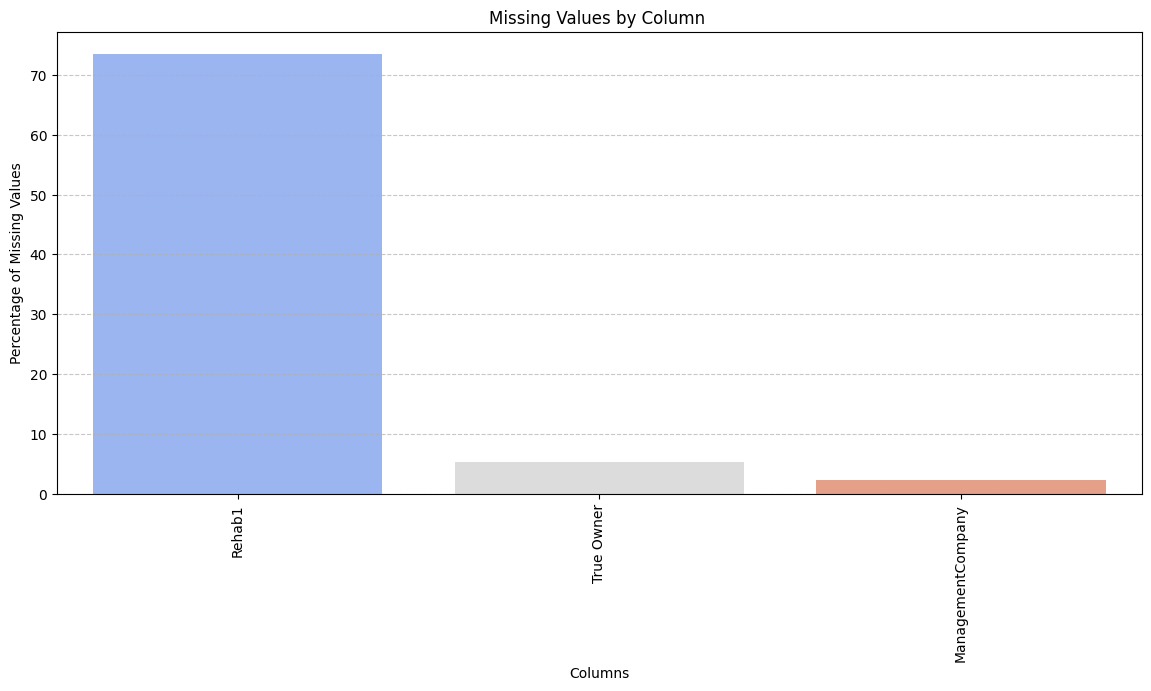

In [199]:
missing_values_rent = missing_value_analysis(MSA1_cleaned_sheets['Rent'])

In [200]:
columns_to_drop = ["ETAKInd", "Rehab2", "Rehab3", "Neighborhood"]

# Ensure columns exist before dropping to avoid errors
MSA1_cleaned_sheets["Rent"] = MSA1_cleaned_sheets["Rent"].drop(columns=[col for col in columns_to_drop if col in MSA1_cleaned_sheets["Rent"].columns])

# Verify the changes
print(MSA1_cleaned_sheets["Rent"].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 869 entries, 0 to 868
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   MarketCode                     869 non-null    object 
 1   MarketName                     869 non-null    object 
 2   StateCode                      869 non-null    object 
 3   StateName                      869 non-null    object 
 4   CountyCode                     869 non-null    object 
 5   CountyName                     869 non-null    object 
 6   TractCode                      869 non-null    object 
 7   BlockGroupCode                 869 non-null    object 
 8   Latitude                       869 non-null    object 
 9   Longitude                      869 non-null    object 
 10  True Owner                     823 non-null    object 
 11  ManagementCompany              849 non-null    object 
 12  ProjID                         869 non-null    obj

In [196]:
MSA1_cleaned_sheets['Rent']

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude  \
0        Travis    000305              2  30.30917 -97.72881   
1        Travis    001716              2  30.36687 -97.79303   
2        Travis    001860              2  30.45009 -97.64873   
3        Travis    000604              3  30.28462 -97.74723   
4    Williamson    020312              2  30.57164 -97.87028   
..          ...       ...            ...       ...       ...   
864      Travis    001817              1  30.36689 -97.72829   
865        Hays    010804              3  30.03098 -98.10173   
866      Travis    001806              3  30.34684  -97.6966   
867      Travis    002005              1  30.23269 -97.78612   
868      Travis    001707              2  30.37337 -97.75408   

0                      True Owner           ManagementCompany    ProjID  \
0                 Privately Owned          MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital           Weller Management     14466   
2      Castle Lanterra Properties    Lincoln Property Company     89519   
3          Texla Housing Partners      Texla Housing Partners     43056   
4          NE Property Management      NE Property Management  10255043   
..                            ...                         ...       ...   
864    Churchill Forge Properties  Churchill Forge Properties     18419   
865      Sendera Investment Group            Merge Management     79577   
866           DTI Investments Inc         DTI Investments Inc     69991   
867            Martine Properties          Martine Properties     88278   
868                 Nitya Capital   Karya Property Management     87479   

0                    Submarket                         Name  \
0            Near North Austin                    108 Place   
1              Far West Austin      10X Living at Grandview   
2    Pflugerville/Wells Branch                1825 Cottages   
3          Downtown/University                     21 Pearl   
4                   Cedar Park          22 North Apartments   
..                         ...                          ...   
864          Near North Austin                    Woodchase   
865                 San Marcos         Woodcreek Apartments   
866       North Central Austin  Woodland Heights Apartments   
867               South Austin            Woods at Manchaca   
868                  Arboretum                    Woodstone   

0                        Address          City State    Zip       Phone  \
0                  108 W 45th St        Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   
3                  911 W 21st St        Austin    TX  78705  5124730808   
4                149 S Bagdad Rd       Leander    TX  78641  5129868727   
..                           ...           ...   ...    ...         ...   
864               8524 Burnet Rd        Austin    TX  78757  5124208341   
865          16515 Ranch Road 12     Woodcreek    TX  78676  5126483989   
866                8312 N I H 35 

/var/folders/z2/fm7clqhj5855cx6jvwxrpyc00000gn/T/ipykernel_24614/2473662417.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




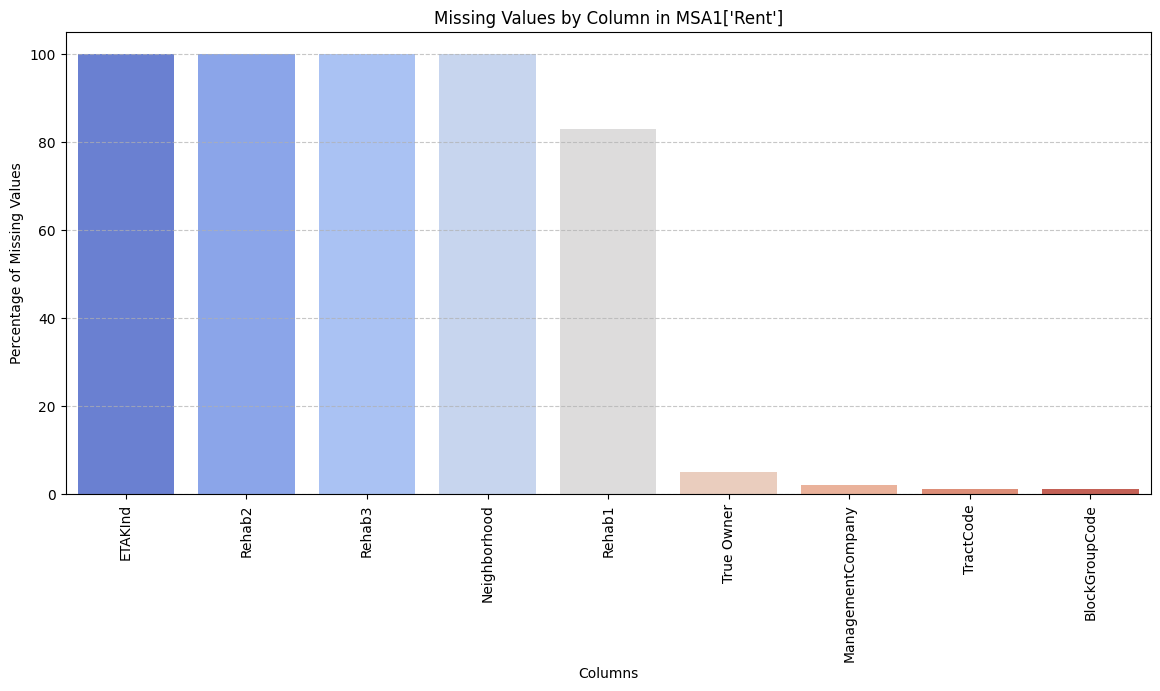

In [197]:
missing_values_rent = missing_value_analysis(MSA2_cleaned_sheets['Rent'])

In [201]:
columns_to_drop = ["ETAKInd", "Rehab2", "Rehab3", "Neighborhood"]

# Ensure columns exist before dropping to avoid errors
MSA2_cleaned_sheets["Rent"] = MSA2_cleaned_sheets["Rent"].drop(columns=[col for col in columns_to_drop if col in MSA2_cleaned_sheets["Rent"].columns])

# Verify the changes
print(MSA2_cleaned_sheets["Rent"].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   MarketCode                     99 non-null     object 
 1   MarketName                     99 non-null     object 
 2   StateCode                      99 non-null     object 
 3   StateName                      99 non-null     object 
 4   CountyCode                     99 non-null     object 
 5   CountyName                     99 non-null     object 
 6   TractCode                      98 non-null     object 
 7   BlockGroupCode                 98 non-null     object 
 8   Latitude                       99 non-null     object 
 9   Longitude                      99 non-null     object 
 10  True Owner                     94 non-null     object 
 11  ManagementCompany              97 non-null     object 
 12  ProjID                         99 non-null     objec

In [202]:
MSA1_cleaned_sheets["Rent"].drop(columns=["Rehab1"],inplace = True)

In [203]:
MSA2_cleaned_sheets["Rent"].drop(columns=["Rehab1"],inplace = True)

In [204]:
#as we alreaady have Rehab scores into consideration and proeport trudst index

In [205]:
MSA1_cleaned_sheets["Rent"]

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
864      12420  Austin-Round Rock, TX        TX     Texas        453   
865      12420  Austin-Round Rock, TX        TX     Texas        209   
866      12420  Austin-Round Rock, TX        TX     Texas        453   
867      12420  Austin-Round Rock, TX        TX     Texas        453   
868      12420  Austin-Round Rock, TX        TX     Texas        453   

0    CountyName TractCode BlockGroupCode  Latitude Longitude  \
0        Travis    000305              2  30.30917 -97.72881   
1        Travis    001716              2  30.36687 -97.79303   
2        Travis    001860              2  30.45009 -97.64873   
3        Travis    000604              3  30.28462 -97.74723   
4    Williamson    020312              2  30.57164 -97.87028   
..          ...       ...            ...       ...       ...   
864      Travis    001817              1  30.36689 -97.72829   
865        Hays    010804              3  30.03098 -98.10173   
866      Travis    001806              3  30.34684  -97.6966   
867      Travis    002005              1  30.23269 -97.78612   
868      Travis    001707              2  30.37337 -97.75408   

0                      True Owner           ManagementCompany    ProjID  \
0                 Privately Owned          MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital           Weller Management     14466   
2      Castle Lanterra Properties    Lincoln Property Company     89519   
3          Texla Housing Partners      Texla Housing Partners     43056   
4          NE Property Management      NE Property Management  10255043   
..                            ...                         ...       ...   
864    Churchill Forge Properties  Churchill Forge Properties     18419   
865      Sendera Investment Group            Merge Management     79577   
866           DTI Investments Inc         DTI Investments Inc     69991   
867            Martine Properties          Martine Properties     88278   
868                 Nitya Capital   Karya Property Management     87479   

0                    Submarket                         Name  \
0            Near North Austin                    108 Place   
1              Far West Austin      10X Living at Grandview   
2    Pflugerville/Wells Branch                1825 Cottages   
3          Downtown/University                     21 Pearl   
4                   Cedar Park          22 North Apartments   
..                         ...                          ...   
864          Near North Austin                    Woodchase   
865                 San Marcos         Woodcreek Apartments   
866       North Central Austin  Woodland Heights Apartments   
867               South Austin            Woods at Manchaca   
868                  Arboretum                    Woodstone   

0                        Address          City State    Zip       Phone  \
0                  108 W 45th St        Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way        Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr  Pflugerville    TX  78660  5122523500   
3                  911 W 21st St        Austin    TX  78705  5124730808   
4                149 S Bagdad Rd       Leander    TX  78641  5129868727   
..                           ...           ...   ...    ...         ...   
864               8524 Burnet Rd        Austin    TX  78757  5124208341   
865          16515 Ranch Road 12     Woodcreek    TX  78676  5126483989   
866                8312 N I H 35 

In [207]:
from sklearn.impute import KNNImputer

In [208]:
MSA1_rent_backup = MSA1_cleaned_sheets["Rent"].copy()


In [209]:
columns_to_impute = ["True Owner", "ManagementCompany"]


USED KNN Imputer to Impute missing values utilising nearest 5 neighbours

In [210]:
backup_values = MSA1_cleaned_sheets["Rent"][columns_to_impute].copy()

# One-Hot Encode categorical columns
one_hot_encoded = pd.get_dummies(MSA1_cleaned_sheets["Rent"][columns_to_impute], dtype=float)

# Initialize KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")

# Apply imputer to the one-hot encoded data
imputed_data = knn_imputer.fit_transform(one_hot_encoded)

# Convert back to DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=one_hot_encoded.columns, index=MSA1_cleaned_sheets["Rent"].index)

# Reconstruct categorical columns by taking the most probable category (column with max value)
for col in columns_to_impute:
    category_columns = [c for c in imputed_df.columns if c.startswith(col + "_")]
    MSA1_cleaned_sheets["Rent"][col] = imputed_df[category_columns].idxmax(axis=1).str[len(col) + 1:]


In [219]:
MSA1_cleaned_sheets['Rent']['True Owner'].isnull()

0      False
1      False
2      False
3      False
4      False
       ...  
864    False
865    False
866    False
867    False
868    False
Name: True Owner, Length: 869, dtype: bool

In [220]:
null_values_msa1_rent = MSA1_cleaned_sheets["Rent"].isnull().sum()


In [221]:
null_values_msa1_rent

0
MarketCode                       0
MarketName                       0
StateCode                        0
StateName                        0
CountyCode                       0
CountyName                       0
TractCode                        0
BlockGroupCode                   0
Latitude                         0
Longitude                        0
True Owner                       0
ManagementCompany                0
ProjID                           0
Submarket                        0
Name                             0
Address                          0
City                             0
State                            0
Zip                              0
Phone                            0
YearBuilt                        0
Quantity                         0
AreaPerUnit                      0
Level                            0
Status                           0
Estimated_Property_Size          0
Avg_Effective_Rent               0
Avg_Effective_Rent_Per_SqFt      0
Avg_Occupancy     

In [227]:
null_values_msa2_rent = MSA2_cleaned_sheets["Rent"].isnull().sum()


In [223]:
null_values_msa2_rent

0
MarketCode                       0
MarketName                       0
StateCode                        0
StateName                        0
CountyCode                       0
CountyName                       0
TractCode                        1
BlockGroupCode                   1
Latitude                         0
Longitude                        0
True Owner                       5
ManagementCompany                2
ProjID                           0
Submarket                        0
Name                             0
Address                          0
City                             0
State                            0
Zip                              0
Phone                            0
YearBuilt                        0
Quantity                         0
AreaPerUnit                      0
Level                            0
Status                           0
Estimated_Property_Size          0
Avg_Effective_Rent               0
Avg_Effective_Rent_Per_SqFt      0
Avg_Occupancy     

In [224]:
columns_to_impute_2 = ["True Owner", "ManagementCompany",'BlockGroupCode','TractCode']


In [225]:
backup_values_2 = MSA2_cleaned_sheets["Rent"][columns_to_impute_2].copy()

# One-Hot Encode categorical columns
one_hot_encoded = pd.get_dummies(MSA2_cleaned_sheets["Rent"][columns_to_impute_2], dtype=float)

# Initialize KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")

# Apply imputer to the one-hot encoded data
imputed_data = knn_imputer.fit_transform(one_hot_encoded)

# Convert back to DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=one_hot_encoded.columns, index=MSA2_cleaned_sheets["Rent"].index)

# Reconstruct categorical columns by taking the most probable category (column with max value)
for col in columns_to_impute:
    category_columns = [c for c in imputed_df.columns if c.startswith(col + "_")]
    MSA2_cleaned_sheets["Rent"][col] = imputed_df[category_columns].idxmax(axis=1).str[len(col) + 1:]


In [228]:
null_values_msa2_rent

0
MarketCode                       0
MarketName                       0
StateCode                        0
StateName                        0
CountyCode                       0
CountyName                       0
TractCode                        1
BlockGroupCode                   1
Latitude                         0
Longitude                        0
True Owner                       0
ManagementCompany                0
ProjID                           0
Submarket                        0
Name                             0
Address                          0
City                             0
State                            0
Zip                              0
Phone                            0
YearBuilt                        0
Quantity                         0
AreaPerUnit                      0
Level                            0
Status                           0
Estimated_Property_Size          0
Avg_Effective_Rent               0
Avg_Effective_Rent_Per_SqFt      0
Avg_Occupancy     

In [237]:
MSA2_cleaned_sheets['Rent'][MSA2_cleaned_sheets['Rent']['BlockGroupCode'].isnull()]

0  MarketCode MarketName StateCode StateName CountyCode CountyName TractCode  \
29      10420  Akron, OH        OH      Ohio        133    Portage       NaN   

0  BlockGroupCode  Latitude Longitude                True Owner  \
29            NaN  41.16994 -81.22757  Insight Management Group   

0          ManagementCompany    ProjID            Submarket         Name  \
29  Insight Management Group  10048613  Kent/Portage County  Heatherwood   

0           Address     City State    Zip       Phone YearBuilt Quantity  \
29  779 Eastowne Dr  Ravenna    OH  44266  3302967721      1986       75   

0  AreaPerUnit Level Status  Estimated_Property_Size Avg_Effective_Rent  \
29         595     1      S                  44625.0         625.621622   

0  Avg_Effective_Rent_Per_SqFt  Avg_Occupancy  Avg_Occupancy_During_Lease_Up  \
29                    1.051465       0.978784                            0.0   

0   Avg_Concession  Lease_Up_Months  Market_Grade_Avg  SubMarket_Grade_Avg  \
29        1.324324              0.0               2.5                  3.0   

0  Property_Age PAS_normalized   RI   PTI  
29           34           0.75  0.0  2.05

In [239]:
#Found TractCOde through https://geomap.ffiec.gov/ffiecgeomap/ - 6008

In [240]:
#found blockgroup code by taking first digit from block code - 1001 - 1 from https://geocoding.geo.census.gov/geocoder/geographies/coordinates?x=-81.22757&y=41.16994&benchmark=2020&vintage=2020

In [242]:
MSA2_cleaned_sheets["Rent"]["TractCode"].fillna("6008", inplace=True)
MSA2_cleaned_sheets["Rent"]["BlockGroupCode"].fillna("1", inplace=True)

/var/folders/z2/fm7clqhj5855cx6jvwxrpyc00000gn/T/ipykernel_24614/1445883758.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [243]:
print(MSA1_cleaned_sheets["Rent"][["TractCode", "BlockGroupCode"]].isnull().sum())


0
TractCode         0
BlockGroupCode    0
dtype: int64


In [244]:
#lets do embedding 

In [246]:
MSA2_cleaned_sheets['Rent'].shape

(99, 38)

In [247]:
MSA1_cleaned_sheets['Rent'].shape

(869, 38)

MERGING ALL FEATURES AND BOTH MARKETS TO CREATE A COMPREHENSIVE DATASET. WE ALSO WANNA TAKE A HIGHER LEVEL GLOBAL VIEW RATHER THAN JUST LOCAL INTERACTIONS. SO -> Concatenated TWO MARKETS DATA

In [248]:
merged = pd.concat([MSA1_cleaned_sheets["Rent"], MSA2_cleaned_sheets["Rent"]], ignore_index=True)


In [ ]:
merged

0   MarketCode             MarketName StateCode StateName CountyCode  \
0        12420  Austin-Round Rock, TX        TX     Texas        453   
1        12420  Austin-Round Rock, TX        TX     Texas        453   
2        12420  Austin-Round Rock, TX        TX     Texas        453   
3        12420  Austin-Round Rock, TX        TX     Texas        453   
4        12420  Austin-Round Rock, TX        TX     Texas        491   
..         ...                    ...       ...       ...        ...   
963      10420              Akron, OH        OH      Ohio        133   
964      10420              Akron, OH        OH      Ohio        133   
965      10420              Akron, OH        OH      Ohio        153   
966      10420              Akron, OH        OH      Ohio        153   
967      10420              Akron, OH        OH      Ohio        153   

0    CountyName TractCode BlockGroupCode  Latitude Longitude  \
0        Travis    000305              2  30.30917 -97.72881   
1        Travis    001716              2  30.36687 -97.79303   
2        Travis    001860              2  30.45009 -97.64873   
3        Travis    000604              3  30.28462 -97.74723   
4    Williamson    020312              2  30.57164 -97.87028   
..          ...       ...            ...       ...       ...   
963     Portage    600800              1  41.16758 -81.23151   
964     Portage    600401              1  41.26366  -81.3641   
965      Summit    506100              6  41.11091 -81.57355   
966      Summit    530603              1  41.17923 -81.48822   
967      Summit    520106              2  41.12067 -81.46037   

0                      True Owner             ManagementCompany    ProjID  \
0                 Privately Owned            MILLER PROPERTIES   10031809   
1    Cardone Acquisitions Capital             Weller Management     14466   
2      Castle Lanterra Properties      Lincoln Property Company     89519   
3          Texla Housing Partners        Texla Housing Partners     43056   
4          NE Property Management        NE Property Management  10255043   
..                            ...                           ...       ...   
963  Simco Management Corporation  Simco Management Corporation     62083   
964      Elon Property Management      Elon Property Management  10000315   
965            AIY Properties Inc            AIY Properties Inc     17335   
966       PNC Real Estate Finance             Gross Residential     17396   
967          BROOKWOOD MANAGEMENT          BROOKWOOD MANAGEMENT     68394   

0                    Submarket                     Name  \
0            Near North Austin                108 Place   
1              Far West Austin  10X Living at Grandview   
2    Pflugerville/Wells Branch            1825 Cottages   
3          Downtown/University                 21 Pearl   
4                   Cedar Park      22 North Apartments   
..                         ...                      ...   
963        Kent/Portage County           Woodgate North   
964        Kent/Portage County                Woodlands   
965        South Summit County        Woods of Fairlawn   
966        North Summit County            Wyndham Ridge   
967        North Summit County          Yorkshire Woods   

0                        Address            City State    Zip       Phone  \
0                  108 W 45th St          Austin    TX  78751  5123740166   
1    6500 Champion Grandview Way          Austin    TX  78750  8448238116   
2                 1001 Nimbus Dr    Pflugerville    TX  78660  5122523500   
3                  911 W 21st St          Austin    TX  78705  5124730808   
4                149 S Bagdad Rd         Leander    TX  78641  5129868727   
..                           ...             ...   ...    ...         ...   
963                  709 Sapp Rd         Ravenna    OH  44266  3302975714   
964                 833 Frost Rd     Streetsboro    OH  44241  3302691646   
965                  17 Manor Rd       

In [250]:
merged.to_csv('merged')

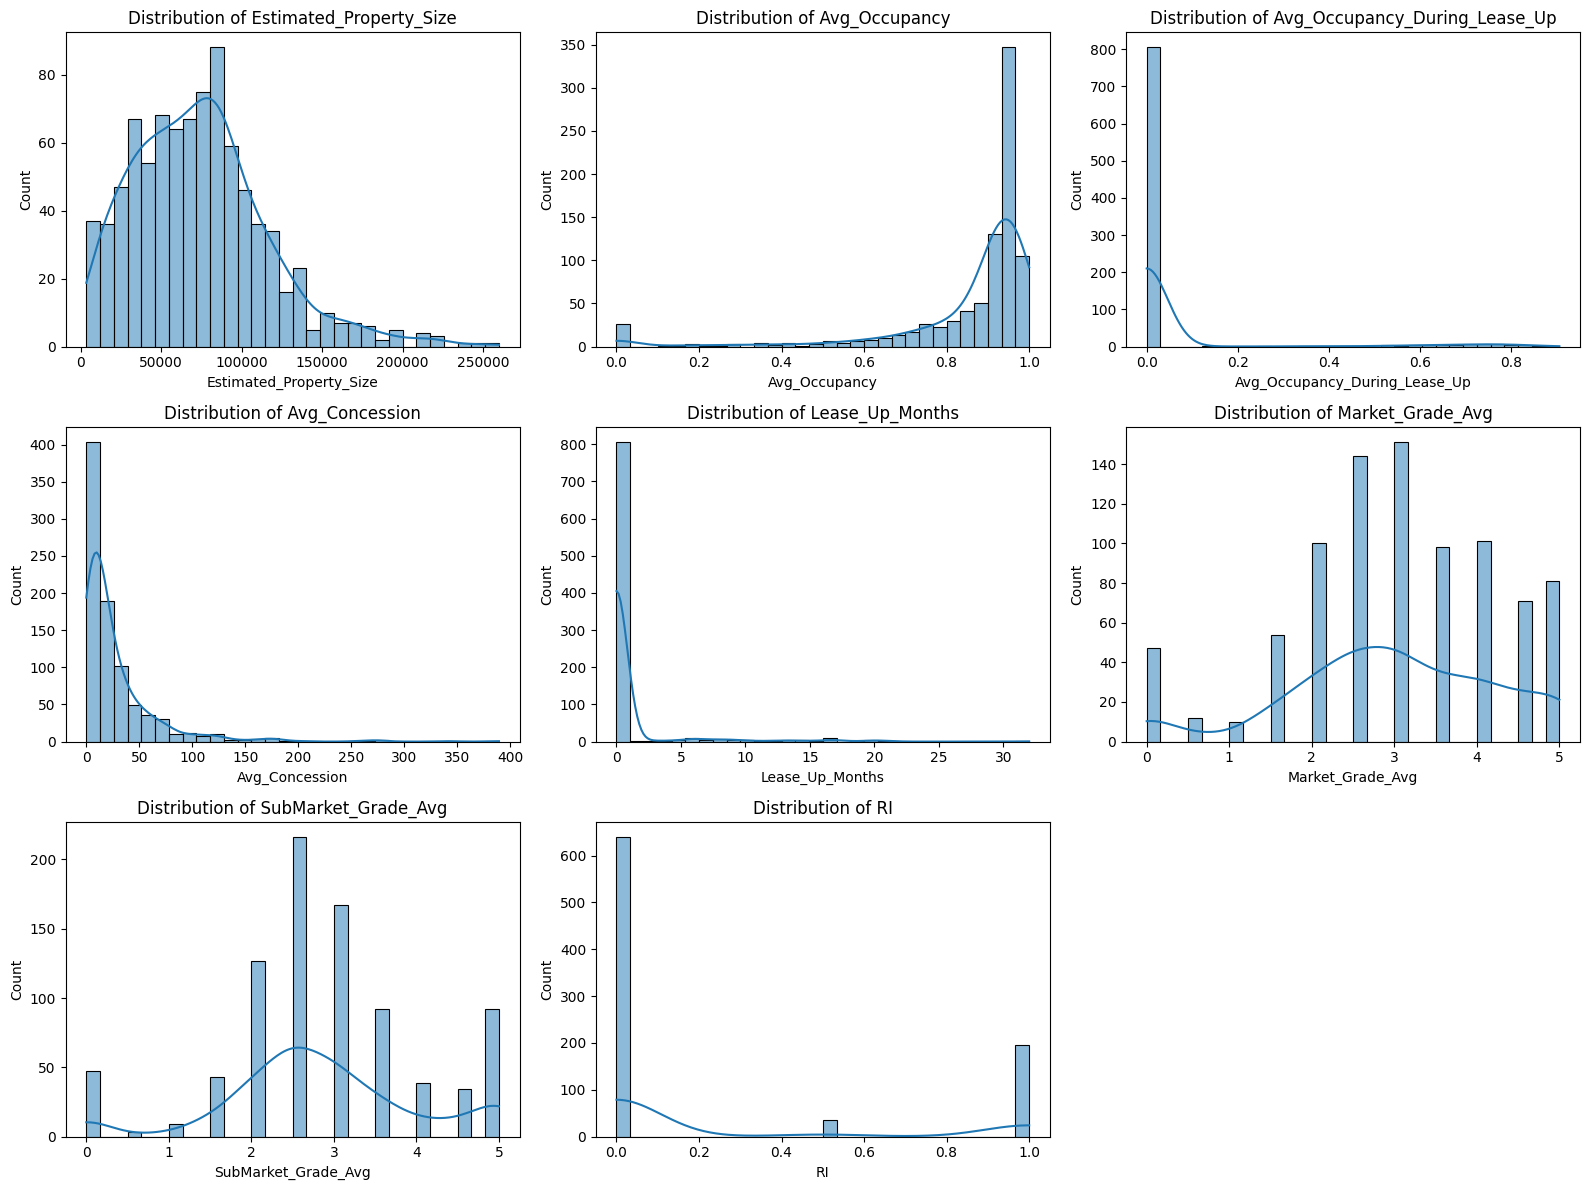

In [251]:
import scipy.stats as stats

# Select numerical columns only
numerical_columns = merged.select_dtypes(include=['number']).columns

# Set up the figure for multiple plots
plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns) // 3 + 1, 3, i)  # Adjust grid layout dynamically
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Statistical tests for normality
normality_results = {}
for col in numerical_columns:
    stat, p = stats.shapiro(df[col].dropna())  # Shapiro-Wilk test for normality
    normality_results[col] = p

# Convert results to a DataFrame for better visualization
normality_df = pd.DataFrame.from_dict(normality_results, orient='index', columns=['p-value'])
normality_df['Normal?'] = normality_df['p-value'] > 0.05  # If p > 0.05, assume normality


In [252]:
normality_df

p-value  Normal?
Estimated_Property_Size        5.017764e-16    False
Avg_Occupancy                  3.202282e-41    False
Avg_Occupancy_During_Lease_Up  2.732761e-49    False
Avg_Concession                 7.994296e-40    False
Lease_Up_Months                7.923868e-50    False
Market_Grade_Avg               3.694783e-16    False
SubMarket_Grade_Avg            3.072172e-19    False
RI                             5.617689e-42    False

In [253]:
#so we need to use min max scaler

<Axes: xlabel='Quantity', ylabel='Count'>

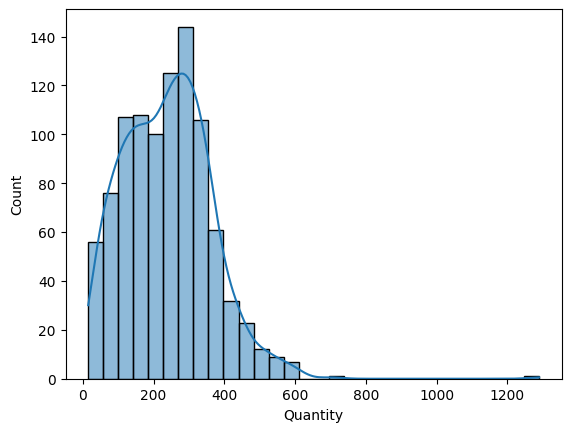

In [254]:
sns.histplot(merged['Quantity'], kde=True, bins=30)

In [255]:
stats.shapiro(merged['Quantity'].dropna())

ShapiroResult(statistic=np.float64(0.9551799488029604), pvalue=np.float64(1.292886235302973e-16))

In [256]:
# quantity is also not normally distributed

**5. Embedding Application: Use an embedding model to group similar properties based on
their characteristics. Visualize these clusters and explain what insights they provide.**

In [259]:
categorical_cols = ["MarketName", "StateName", "CountyName", "Submarket", "True Owner", "ManagementCompany", "Status"] #we will consider these columns as our cateogarical features for our clustering. As other aren't ewither part of this or adds redudancy to our model


Using Cateograical Columns to convert into sentences useful for wordembeddings

In [260]:
sentences = df[categorical_cols].astype(str).values.tolist()  # Convert each row into a list of words


In [261]:
sentences

[['Austin-Round Rock, TX',
  'Texas',
  'Travis',
  'Near North Austin',
  'Privately Owned',
  'MILLER PROPERTIES ',
  'S'],
 ['Austin-Round Rock, TX',
  'Texas',
  'Travis',
  'Far West Austin',
  'Cardone Acquisitions Capital',
  'Weller Management',
  'S'],
 ['Austin-Round Rock, TX',
  'Texas',
  'Travis',
  'Pflugerville/Wells Branch',
  'Castle Lanterra Properties',
  'Lincoln Property Company',
  'S'],
 ['Austin-Round Rock, TX',
  'Texas',
  'Travis',
  'Downtown/University',
  'Texla Housing Partners',
  'Texla Housing Partners',
  'S'],
 ['Austin-Round Rock, TX',
  'Texas',
  'Williamson',
  'Cedar Park',
  'NE Property Management',
  'NE Property Management',
  'S'],
 ['Austin-Round Rock, TX',
  'Texas',
  'Travis',
  'Downtown/University',
  'Rainier Properties',
  'Rainier Properties',
  'S'],
 ['Austin-Round Rock, TX',
  'Texas',
  'Williamson',
  'Round Rock/Georgetown',
  'GVA Property Management',
  'GVA Property Management',
  'S'],
 ['Austin-Round Rock, TX',
  'Texas'

In [267]:
#pip install gensim
merged.to_csv("merged_data.csv", index=False)


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
merged_df = pd.read_csv("merged_data.csv")

In [3]:
import gensim
print(gensim.__version__)


4.3.3


Here comes Gensim and use of Word2Vec model

In [4]:
merged_df

MarketCode             MarketName StateCode StateName  CountyCode  \
0         12420  Austin-Round Rock, TX        TX     Texas         453   
1         12420  Austin-Round Rock, TX        TX     Texas         453   
2         12420  Austin-Round Rock, TX        TX     Texas         453   
3         12420  Austin-Round Rock, TX        TX     Texas         453   
4         12420  Austin-Round Rock, TX        TX     Texas         491   
..          ...                    ...       ...       ...         ...   
963       10420              Akron, OH        OH      Ohio         133   
964       10420              Akron, OH        OH      Ohio         133   
965       10420              Akron, OH        OH      Ohio         153   
966       10420              Akron, OH        OH      Ohio         153   
967       10420              Akron, OH        OH      Ohio         153   

     CountyName  TractCode  BlockGroupCode  Latitude  Longitude  ...  \
0        Travis        305               2  30.30917  -97.72881  ...   
1        Travis       1716               2  30.36687  -97.79303  ...   
2        Travis       1860               2  30.45009  -97.64873  ...   
3        Travis        604               3  30.28462  -97.74723  ...   
4    Williamson      20312               2  30.57164  -97.87028  ...   
..          ...        ...             ...       ...        ...  ...   
963     Portage     600800               1  41.16758  -81.23151  ...   
964     Portage     600401               1  41.26366  -81.36410  ...   
965      Summit     506100               6  41.11091  -81.57355  ...   
966      Summit     530603               1  41.17923  -81.48822  ...   
967      Summit     520106               2  41.12067  -81.46037  ...   

    Avg_Occupancy Avg_Occupancy_During_Lease_Up  Avg_Concession  \
0        0.984768                        0.0000        0.050505   
1        0.933207                        0.0000        9.786667   
2        0.921484                        0.0000        7.317460   
3        0.989233                        0.0000        0.000000   
4        0.846200                        0.8462       30.555556   
..            ...                           ...             ...   
963      0.983703                        0.0000       13.359375   
964      0.952231                        0.0000        2.730769   
965      0.924673                        0.0000       25.360000   
966      0.968433                        0.0000        7.020000   
967      0.930021                        0.0000       15.319149   

    Lease_Up_Months Market_Grade_Avg SubMarket_Grade_Avg Property_Age  \
0               0.0              3.0                 4.0           47   
1               0.0              5.0                 3.5           15   
2               0.0              3.5                 3.0           35   
3               0.0              3.5                 5.0            7   
4               5.0              3.0                 2.0            2   
..              ...              ...                 ...          ...   
963             0.0              1.5                 2.0           47   
964             0.0              2.5                 3.0           36   
965             0.0              3.0                 2.0           73   
966             0.0              2.5                 2.5           21   
967             0.0              3.0                 3.0           27   

    PAS_normalized   RI       PTI  
0         0.441860  0.0  2.488372  
1         0.813953  0.0  3.212791  
2         0.581395  0.0  2.416279  
3         0.906977  0.0  3.081395  
4         0.965116  0.0  1.993023  
..             ...  ...       ...  
963       0.654412  0.0  1.330882  
964       0.735294  0.0  2.047059  
965       0.463235  0.0  1.892647  
966       0.845588  0.0  1.919118  
967       0.801471  0.0  2.260294  

[968 rows x 38 columns]

In [92]:
categorical_cols = ["MarketName", "StateName", "CountyName", "Submarket", "True Owner", "ManagementCompany", "Status"]

In [6]:
from gensim.models import Word2Vec


In [7]:
sentences = merged_df[categorical_cols].astype(str).values.tolist()


In [8]:
sentences

[['Austin-Round Rock, TX',
  'Texas',
  'Travis',
  'Near North Austin',
  'Privately Owned',
  'MILLER PROPERTIES ',
  'S'],
 ['Austin-Round Rock, TX',
  'Texas',
  'Travis',
  'Far West Austin',
  'Cardone Acquisitions Capital',
  'Weller Management',
  'S'],
 ['Austin-Round Rock, TX',
  'Texas',
  'Travis',
  'Pflugerville/Wells Branch',
  'Castle Lanterra Properties',
  'Lincoln Property Company',
  'S'],
 ['Austin-Round Rock, TX',
  'Texas',
  'Travis',
  'Downtown/University',
  'Texla Housing Partners',
  'Texla Housing Partners',
  'S'],
 ['Austin-Round Rock, TX',
  'Texas',
  'Williamson',
  'Cedar Park',
  'NE Property Management',
  'NE Property Management',
  'S'],
 ['Austin-Round Rock, TX',
  'Texas',
  'Travis',
  'Downtown/University',
  'Rainier Properties',
  'Rainier Properties',
  'S'],
 ['Austin-Round Rock, TX',
  'Texas',
  'Williamson',
  'Round Rock/Georgetown',
  'GVA Property Management',
  'GVA Property Management',
  'S'],
 ['Austin-Round Rock, TX',
  'Texas'

In [91]:
numerical_columns = ["Estimated_Property_Size", "Avg_Effective_Rent", "Avg_Effective_Rent_Per_SqFt", 
                     "Avg_Occupancy", "Avg_Occupancy_During_Lease_Up", "Avg_Concession", 
                     "Lease_Up_Months", "Market_Grade_Avg", "SubMarket_Grade_Avg", "Property_Age", 
                     "PAS_normalized", "RI", "PTI"]


SCALE NUMERICAL COLUMNS USING MIN MAX SCALER AS THEIR DISTRIBUTIONS WEREN'T NORMAL 

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


In [11]:
numerical_scaled = pd.DataFrame(scaler.fit_transform(merged_df[numerical_columns]), columns=numerical_columns)


The goal of this approach is to numerically represent categorical property attributes using Word2Vec embeddings. Instead of treating categories as one-hot encoded values, we learn meaningful relationships between them based on their context.

What is Word2Vec?
Word2Vec is a technique that converts words into numerical vectors such that words with similar meanings have similar vector representations. It captures relationships based on how words appear together in text.

Example:
In a language model, "apartment" and "condo" might have similar vector representations because they often appear in similar contexts.

In [12]:
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
def get_word_embedding(word):
    try:
        return word2vec_model.wv[word]
    except KeyError:
        return np.zeros(100)

In [13]:
embedding_features = {}
for col in categorical_cols:
    embedding_matrix = np.vstack(merged_df[col].astype(str).apply(get_word_embedding).values)
    embedding_df = pd.DataFrame(embedding_matrix, columns=[f"{col}_dim{i}" for i in range(100)])
    embedding_features[col] = embedding_df

In [14]:
clustering_df = pd.concat(embedding_features.values(), axis=1)


In [15]:
clustering_df

MarketName_dim0  MarketName_dim1  MarketName_dim2  MarketName_dim3  \
0          -0.240563         0.310799         0.014645         0.035089   
1          -0.240563         0.310799         0.014645         0.035089   
2          -0.240563         0.310799         0.014645         0.035089   
3          -0.240563         0.310799         0.014645         0.035089   
4          -0.240563         0.310799         0.014645         0.035089   
..               ...              ...              ...              ...   
963        -0.230209         0.316302         0.008421         0.030023   
964        -0.230209         0.316302         0.008421         0.030023   
965        -0.230209         0.316302         0.008421         0.030023   
966        -0.230209         0.316302         0.008421         0.030023   
967        -0.230209         0.316302         0.008421         0.030023   

     MarketName_dim4  MarketName_dim5  MarketName_dim6  MarketName_dim7  \
0           0.182779        -0.361858         0.198454         0.646000   
1           0.182779        -0.361858         0.198454         0.646000   
2           0.182779        -0.361858         0.198454         0.646000   
3           0.182779        -0.361858         0.198454         0.646000   
4           0.182779        -0.361858         0.198454         0.646000   
..               ...              ...              ...              ...   
963         0.179658        -0.375228         0.213501         0.668937   
964         0.179658        -0.375228         0.213501         0.668937   
965         0.179658        -0.375228         0.213501         0.668937   
966         0.179658        -0.375228         0.213501         0.668937   
967         0.179658        -0.375228         0.213501         0.668937   

     MarketName_dim8  MarketName_dim9  ...  Status_dim90  Status_dim91  \
0          -0.328336        -0.235924  ...      0.268773       0.26729   
1          -0.328336        -0.235924  ...      0.268773       0.26729   
2          -0.328336        -0.235924  ...      0.268773       0.26729   
3          -0.328336        -0.235924  ...      0.268773       0.26729   
4          -0.328336        -0.235924  ...      0.268773       0.26729   
..               ...              ...  ...           ...           ...   
963        -0.346168        -0.245790  ...      0.268773       0.26729   
964        -0.346168        -0.245790  ...      0.268773       0.26729   
965        -0.346168        -0.245790  ...      0.268773       0.26729   
966        -0.346168        -0.245790  ...      0.268773       0.26729   
967        -0.346168        -0.245790  ...      0.268773       0.26729   

     Status_dim92  Status_dim93  Status_dim94  Status_dim95  Status_dim96  \
0         0.24354     -0.169431      0.820515      0.302392       0.20038   
1         0.24354     -0.169431      0.820515      0.302392       0.20038   
2         0.24354     -0.169431      0.820515      0.302392       0.20038   
3         0.24354     -0.169431      0.820515      0.302392       0.20038   
4         0.24354     -0.169431      0.820515      0.302392       0.20038   
..            ...           ...           ...           ...           ...   
963       0.24354     -0.169431      0.820515      0.302392       0.20038   
964       0.24354     -0.169431      0.820515      0.302392       0.20038   
965       0.24354     -0.169431      0.820515      0.302392       0.20038   
966       0.24354     -0.169431      0.820515      0.302392       0.20038   
967       0.24354     -0.169431      0.820515      0.302392       0.20038   

     Status_dim97  Status_dim98  Status_dim99  
0       -0.023919     -0.037226     -0.227539  
1       -0.023919     -0.037226     -0.227539  
2       -0.023919     -0.037226     -0.227539  
3       -0.023919     -0.037226     -0.227539  
4       -0.023919     -0.037226     -0.227539  
..            ...           ...           ...  
963     -0.023919     -0.037226     -0.227539  
964  

In [16]:
clustering_df = pd.concat([clustering_df, numerical_scaled], axis=1)


In [17]:
clustering_df

MarketName_dim0  MarketName_dim1  MarketName_dim2  MarketName_dim3  \
0          -0.240563         0.310799         0.014645         0.035089   
1          -0.240563         0.310799         0.014645         0.035089   
2          -0.240563         0.310799         0.014645         0.035089   
3          -0.240563         0.310799         0.014645         0.035089   
4          -0.240563         0.310799         0.014645         0.035089   
..               ...              ...              ...              ...   
963        -0.230209         0.316302         0.008421         0.030023   
964        -0.230209         0.316302         0.008421         0.030023   
965        -0.230209         0.316302         0.008421         0.030023   
966        -0.230209         0.316302         0.008421         0.030023   
967        -0.230209         0.316302         0.008421         0.030023   

     MarketName_dim4  MarketName_dim5  MarketName_dim6  MarketName_dim7  \
0           0.182779        -0.361858         0.198454         0.646000   
1           0.182779        -0.361858         0.198454         0.646000   
2           0.182779        -0.361858         0.198454         0.646000   
3           0.182779        -0.361858         0.198454         0.646000   
4           0.182779        -0.361858         0.198454         0.646000   
..               ...              ...              ...              ...   
963         0.179658        -0.375228         0.213501         0.668937   
964         0.179658        -0.375228         0.213501         0.668937   
965         0.179658        -0.375228         0.213501         0.668937   
966         0.179658        -0.375228         0.213501         0.668937   
967         0.179658        -0.375228         0.213501         0.668937   

     MarketName_dim8  MarketName_dim9  ...  Avg_Occupancy  \
0          -0.328336        -0.235924  ...       0.984768   
1          -0.328336        -0.235924  ...       0.933207   
2          -0.328336        -0.235924  ...       0.921484   
3          -0.328336        -0.235924  ...       0.989233   
4          -0.328336        -0.235924  ...       0.846200   
..               ...              ...  ...            ...   
963        -0.346168        -0.245790  ...       0.983703   
964        -0.346168        -0.245790  ...       0.952231   
965        -0.346168        -0.245790  ...       0.924673   
966        -0.346168        -0.245790  ...       0.968433   
967        -0.346168        -0.245790  ...       0.930021   

     Avg_Occupancy_During_Lease_Up  Avg_Concession  Lease_Up_Months  \
0                         0.000000        0.000130          0.00000   
1                         0.000000        0.025137          0.00000   
2                         0.000000        0.018795          0.00000   
3                         0.000000        0.000000          0.00000   
4                         0.933652        0.078482          0.15625   
..                             ...             ...              ...   
963                       0.000000        0.034313          0.00000   
964                       0.000000        0.007014          0.00000   
965                       0.000000        0.065137          0.00000   
966                       0.000000        0.018031          0.00000   
967                       0.000000        0.039347          0.00000   

     Market_Grade_Avg  SubMarket_Grade_Avg  Property_Age  PAS_normalized   RI  \
0                 0.6                  0.8      0.350365        0.441860  0.0   
1                 1.0                  0.7      0.116788        0.813953  0.0   
2                 0.7                  0.6      0.262774        0.581395  0.0   
3                 0.7                  1.0      0.058394        0.906977  0.0   
4                 0.6                  0.4      0.021898        0.965116  0.0   
..                ...                  ...           ...             ...  ...   
963               0.3                  0.4      0.

In [18]:
clustering_df.iloc[:,:700]

MarketName_dim0  MarketName_dim1  MarketName_dim2  MarketName_dim3  \
0          -0.240563         0.310799         0.014645         0.035089   
1          -0.240563         0.310799         0.014645         0.035089   
2          -0.240563         0.310799         0.014645         0.035089   
3          -0.240563         0.310799         0.014645         0.035089   
4          -0.240563         0.310799         0.014645         0.035089   
..               ...              ...              ...              ...   
963        -0.230209         0.316302         0.008421         0.030023   
964        -0.230209         0.316302         0.008421         0.030023   
965        -0.230209         0.316302         0.008421         0.030023   
966        -0.230209         0.316302         0.008421         0.030023   
967        -0.230209         0.316302         0.008421         0.030023   

     MarketName_dim4  MarketName_dim5  MarketName_dim6  MarketName_dim7  \
0           0.182779        -0.361858         0.198454         0.646000   
1           0.182779        -0.361858         0.198454         0.646000   
2           0.182779        -0.361858         0.198454         0.646000   
3           0.182779        -0.361858         0.198454         0.646000   
4           0.182779        -0.361858         0.198454         0.646000   
..               ...              ...              ...              ...   
963         0.179658        -0.375228         0.213501         0.668937   
964         0.179658        -0.375228         0.213501         0.668937   
965         0.179658        -0.375228         0.213501         0.668937   
966         0.179658        -0.375228         0.213501         0.668937   
967         0.179658        -0.375228         0.213501         0.668937   

     MarketName_dim8  MarketName_dim9  ...  Status_dim90  Status_dim91  \
0          -0.328336        -0.235924  ...      0.268773       0.26729   
1          -0.328336        -0.235924  ...      0.268773       0.26729   
2          -0.328336        -0.235924  ...      0.268773       0.26729   
3          -0.328336        -0.235924  ...      0.268773       0.26729   
4          -0.328336        -0.235924  ...      0.268773       0.26729   
..               ...              ...  ...           ...           ...   
963        -0.346168        -0.245790  ...      0.268773       0.26729   
964        -0.346168        -0.245790  ...      0.268773       0.26729   
965        -0.346168        -0.245790  ...      0.268773       0.26729   
966        -0.346168        -0.245790  ...      0.268773       0.26729   
967        -0.346168        -0.245790  ...      0.268773       0.26729   

     Status_dim92  Status_dim93  Status_dim94  Status_dim95  Status_dim96  \
0         0.24354     -0.169431      0.820515      0.302392       0.20038   
1         0.24354     -0.169431      0.820515      0.302392       0.20038   
2         0.24354     -0.169431      0.820515      0.302392       0.20038   
3         0.24354     -0.169431      0.820515      0.302392       0.20038   
4         0.24354     -0.169431      0.820515      0.302392       0.20038   
..            ...           ...           ...           ...           ...   
963       0.24354     -0.169431      0.820515      0.302392       0.20038   
964       0.24354     -0.169431      0.820515      0.302392       0.20038   
965       0.24354     -0.169431      0.820515      0.302392       0.20038   
966       0.24354     -0.169431      0.820515      0.302392       0.20038   
967       0.24354     -0.169431      0.820515      0.302392       0.20038   

     Status_dim97  Status_dim98  Status_dim99  
0       -0.023919     -0.037226     -0.227539  
1       -0.023919     -0.037226     -0.227539  
2       -0.023919     -0.037226     -0.227539  
3       -0.023919     -0.037226     -0.227539  
4       -0.023919     -0.037226     -0.227539  
..            ...           ...           ...  
963     -0.023919     -0.037226     -0.227539  
964  

In [19]:
word2vec_embeddings = clustering_df.iloc[:, :700]  


Let's See Word2Vec Embeddings in 2d space

In [20]:
from sklearn.manifold import TSNE


t-SNE (t-Distributed Stochastic Neighbor Embedding) is a dimensionality reduction technique that helps visualize high-dimensional data in 2D or 3D space while preserving the structure and relationships between points.

Example & Intuition
Imagine I have a dataset of real estate properties, each represented by a 100-dimensional Word2Vec embedding based on features like property type, market, submarket, etc. This means each property is like a point in a 100D space. However, we can’t visualize 100D!

t-SNE helps by projecting these 100D points into 2D (or 3D) while keeping similar properties close together and distant properties farther apart.

A great Analogy:
Think of folding a world map into a 2D piece of paper. Even though it's compressed, nearby locations (like two cities in Texas) remain close, while far-apart locations (Texas vs. New York) stay far.



In [21]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
word2vec_2d = tsne.fit_transform(word2vec_embeddings)

In [22]:
word2vec_tsne_df = pd.DataFrame(word2vec_2d, columns=["x", "y"])


In [23]:
word2vec_tsne_df

x          y
0    -2.853873  27.976746
1    18.805035 -15.297016
2    -9.413035  -7.000755
3    34.533714 -11.957573
4     2.863238 -44.160667
..         ...        ...
963 -45.623695 -25.529743
964 -48.223991 -24.366646
965 -23.996439  30.782354
966 -21.042759  30.143597
967 -25.779940  31.548800

[968 rows x 2 columns]

In [24]:
word2vec_tsne_df["text"] = merged_df['ProjID'] # Assuming row index corresponds to meaningful text


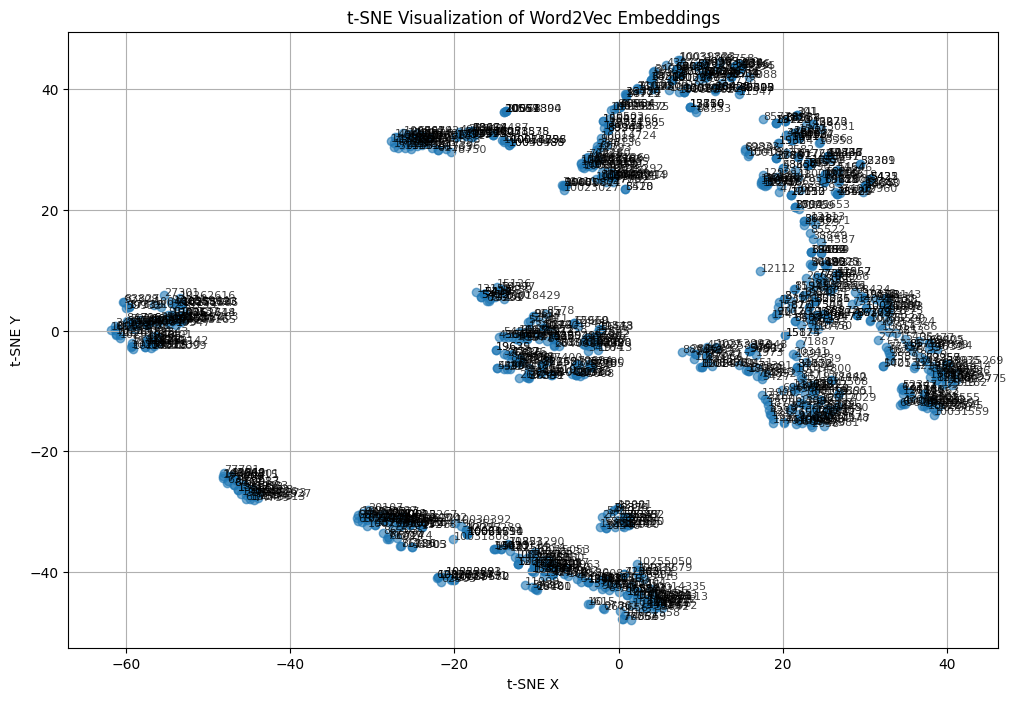

In [25]:
plt.figure(figsize=(12, 8))
plt.scatter(word2vec_tsne_df["x"], word2vec_tsne_df["y"], alpha=0.6)

# Annotate points
for i, txt in enumerate(word2vec_tsne_df["text"]):
    plt.annotate(txt, (word2vec_tsne_df["x"][i], word2vec_tsne_df["y"][i]), fontsize=8, alpha=0.75)

plt.xlabel("t-SNE X")
plt.ylabel("t-SNE Y")
plt.title("t-SNE Visualization of Word2Vec Embeddings")
plt.grid()
plt.show()

In [26]:
from sklearn.decomposition import PCA


After visualizing the Word2Vec embeddings with t-SNE, I used PCA (Principal Component Analysis) to reduce dimensionality while retaining maximum variance in my dataset.



In [27]:
pca = PCA(n_components=10, random_state=42)
pca_features = pca.fit_transform(clustering_df)


In [28]:
pca_features.shape

(968, 10)

My clustering_df had 713 features (word embeddings + numerical columns), making it computationally expensive for clustering. PCA helps by reducing dimensions while keeping most of the data’s information.

In [29]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

Suppose we have 100D data, but PCA shows that only 10 dimensions explain 95% of the variance. This means I can reduce my dataset to 10D instead of 100D, making clustering more efficient and interpretable.

In [30]:
explained_variance

array([0.27552211, 0.17862373, 0.1353939 , 0.09229039, 0.07431167,
       0.06406741, 0.0452484 , 0.04071768, 0.03213996, 0.02052688])

In [31]:
cumulative_variance

array([0.27552211, 0.45414584, 0.58953974, 0.68183013, 0.7561418 ,
       0.82020921, 0.86545761, 0.90617529, 0.93831525, 0.95884212])

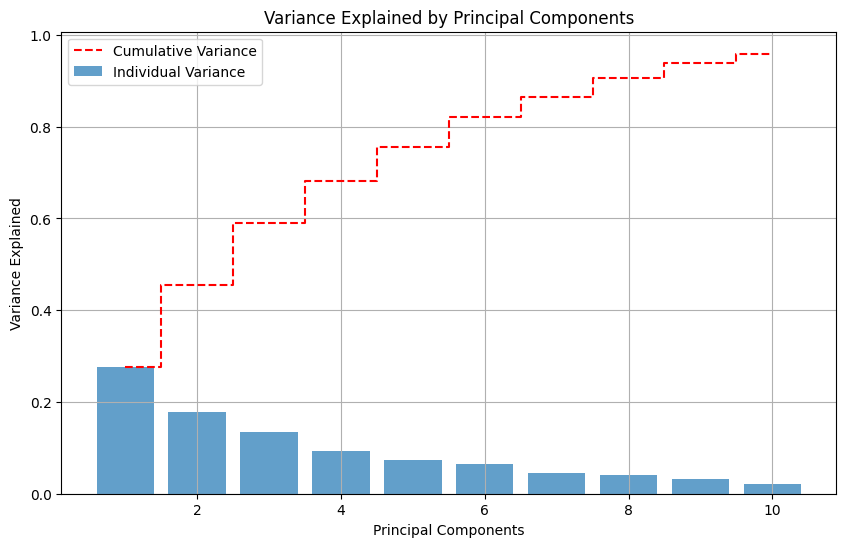

In [32]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center', label='Individual Variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', linestyle='--', color='red', label='Cumulative Variance')
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by Principal Components')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
cumulative_variance

array([0.27552211, 0.45414584, 0.58953974, 0.68183013, 0.7561418 ,
       0.82020921, 0.86545761, 0.90617529, 0.93831525, 0.95884212])

In [34]:
#our 10 components explains atleast 90% of variance

**CLUSTERING**

In [35]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

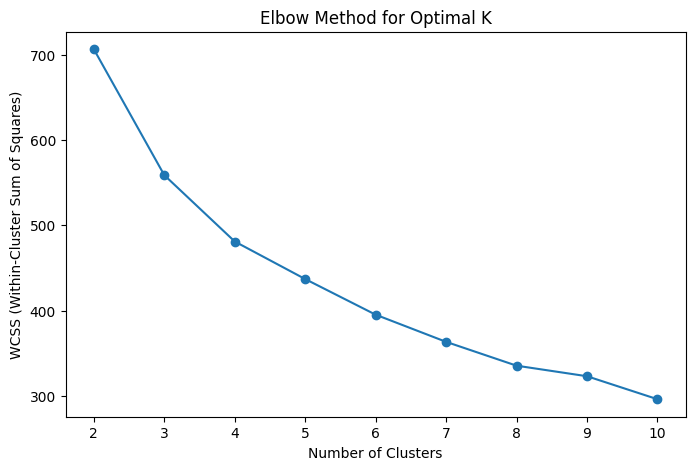

In [36]:
k_values = range(2, 11)  # Testing K from 2 to 10
wcss = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pca_features)  # Fit KMeans on PCA-reduced data
    wcss.append(kmeans.inertia_)  # Append WCSS value

# Plot Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.show()

In [37]:
#k=5 seems from where WCSS seems to decrease slowly. The elbow plot we got is not how we desired but lets see the silhoutte score

In [38]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(pca_features)


K-Means Silhouette Score: 0.2479


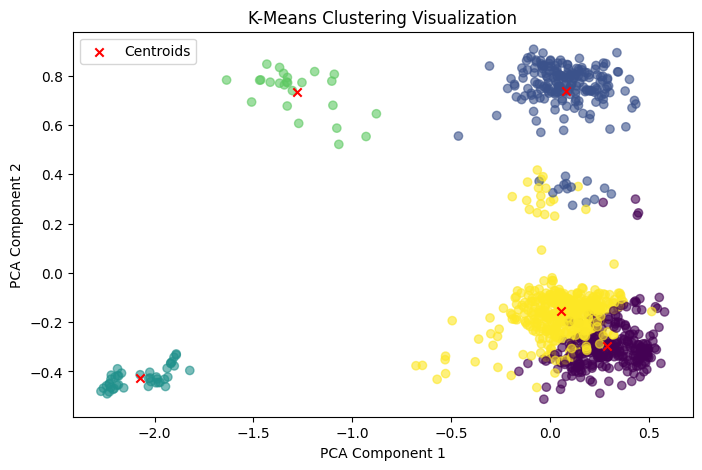

In [39]:
kmeans_silhouette = silhouette_score(pca_features, kmeans_labels)
print(f"K-Means Silhouette Score: {kmeans_silhouette:.4f}")

# Visualizing the clusters
plt.figure(figsize=(8, 5))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', label="Centroids")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clustering Visualization")
plt.legend()
plt.show()

In [40]:
# the clustering is not done properly, lets do DBSCAN

In [41]:
from sklearn.cluster import DBSCAN

In [190]:
dbscan = DBSCAN(eps=0.7, min_samples=10)   # our data had 10 PCA components
dbscan_labels = dbscan.fit_predict(pca_features)

DBSCAN Silhouette Score: 0.4889


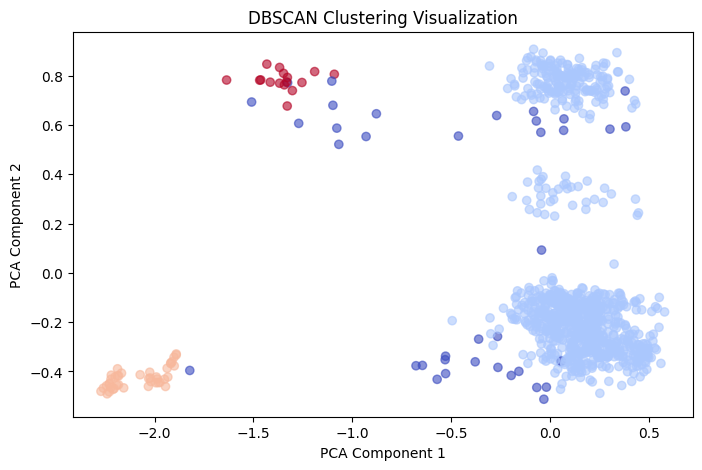

In [191]:
unique_labels = set(dbscan_labels) - {-1}  # Exclude noise (-1)
if len(unique_labels) > 1:  # At least 2 valid clusters needed for silhouette score
    valid_clusters = dbscan_labels != -1
    dbscan_silhouette = silhouette_score(pca_features[valid_clusters], dbscan_labels[valid_clusters])
    print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.4f}")
else:
    print("DBSCAN did not find enough valid clusters to compute Silhouette Score.")

# Visualizing DBSCAN clusters
plt.figure(figsize=(8, 5))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=dbscan_labels, cmap='coolwarm', alpha=0.6)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clustering Visualization")
plt.show()

In [192]:
unique_labels

{0, 1, 2}

In [133]:
# we merged two markets data so there should be atleast 2 clusters, so with DBSCAN we have best silhoutee through tuning minsamples and eps, 3 clusters come great option

In [194]:
from sklearn.cluster import AgglomerativeClustering

In [209]:
agg_clustering = AgglomerativeClustering(n_clusters=5, linkage='ward')
agg_labels = agg_clustering.fit_predict(pca_features)

In [210]:
agg_silhouette = silhouette_score(pca_features, agg_labels)
print(f"Agglomerative Clustering Silhouette Score: {agg_silhouette:.4f}")

Agglomerative Clustering Silhouette Score: 0.2281


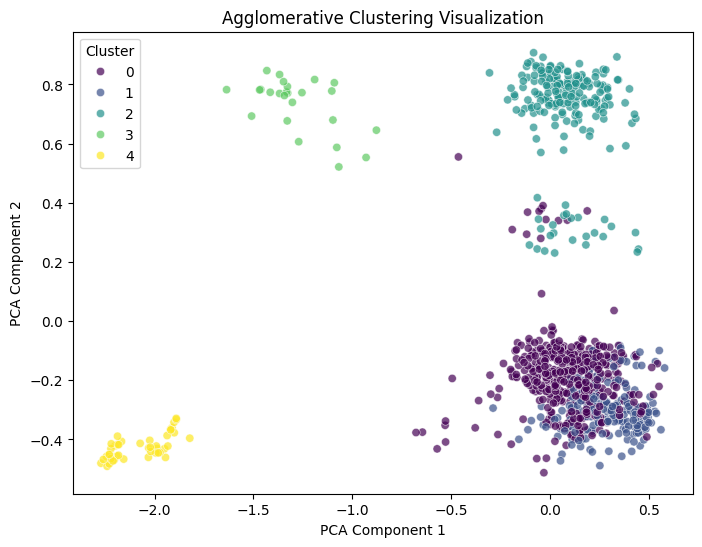

In [211]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=agg_labels, palette="viridis", alpha=0.7)
plt.title("Agglomerative Clustering Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

In [213]:
pca_features

array([[ 0.27790549, -0.0883369 , -0.21515999, ...,  0.03420159,
         0.08405516,  0.06284887],
       [ 0.42773273, -0.23278638,  0.28257686, ..., -0.05862611,
        -0.09885711, -0.24671276],
       [ 0.20394321, -0.15746099,  0.07607477, ..., -0.21814855,
         0.21876732, -0.05513176],
       ...,
       [ 0.10736194, -0.08769395, -0.46485517, ...,  0.11415614,
         0.14464705, -0.12548151],
       [ 0.06977742, -0.20533164, -0.20830398, ...,  0.12696442,
        -0.07185621, -0.065592  ],
       [ 0.18000133, -0.20675812, -0.21805808, ...,  0.17894876,
        -0.0980161 , -0.04927463]])

In [214]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [218]:
import scipy.cluster.hierarchy as sch


In [220]:
divisive_clustering = AgglomerativeClustering(n_clusters=5, linkage='ward', compute_full_tree=True)
divisive_labels = divisive_clustering.fit_predict(pca_features)


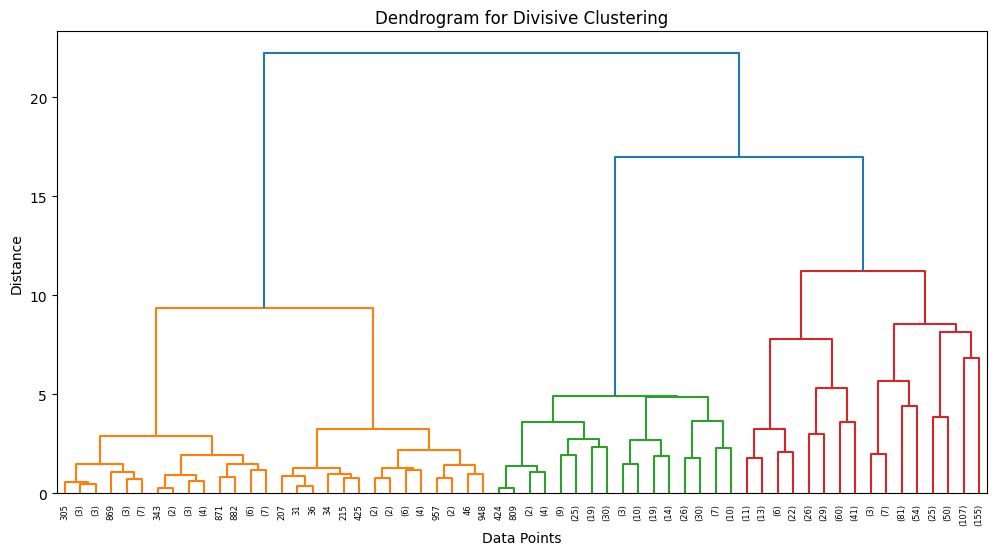

Divisive Clustering Labels: {0, 1, 2, 3, 4}


In [221]:
plt.figure(figsize=(12, 6))
linkage_matrix = sch.linkage(pca_features, method='ward')
sch.dendrogram(linkage_matrix, truncate_mode="level", p=5)
plt.title("Dendrogram for Divisive Clustering")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

# Print unique cluster labels
print("Divisive Clustering Labels:", set(divisive_labels))

In [222]:
divisive_silhouette = silhouette_score(pca_features, divisive_labels)
print(f"Divisive Clustering Silhouette Score: {divisive_silhouette:.4f}")

Divisive Clustering Silhouette Score: 0.2281


In [236]:
# Kmeans still does better and visualisation of Kmeans clustering with K=5 serves better for our purpose to generate insights

**DBSCAN was useful in testing density-based grouping but didn’t perform well with mixed-density property distributions.
✅ K-Means (K=5) provided a clearer, more interpretable segmentation, making it the best choice for our analysis.**

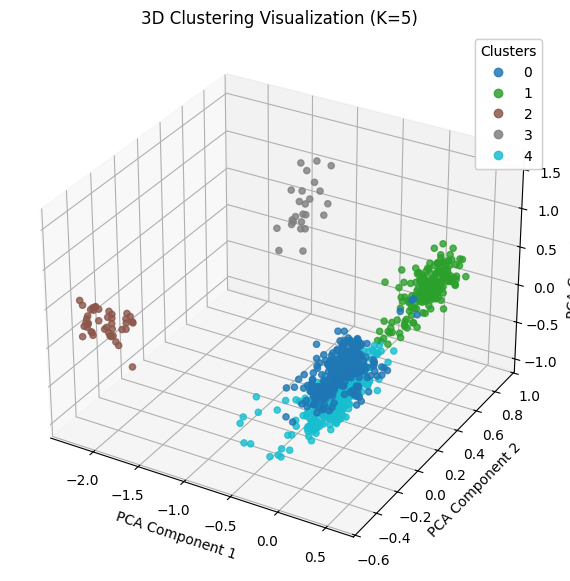

In [42]:
from mpl_toolkits.mplot3d import Axes3D

# Extract first 3 PCA components
pca_3d = pca_features[:, :3]

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
scatter = ax.scatter(pca_3d[:, 0], 
                     pca_3d[:, 1], 
                     pca_3d[:, 2], 
                     c=kmeans.labels_, 
                     cmap="tab10", 
                     alpha=0.8)

# Label axes
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.set_title("3D Clustering Visualization (K=5)")

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

# Show plot
plt.show()

In [43]:
#loooking g

In [44]:
clustering_df

MarketName_dim0  MarketName_dim1  MarketName_dim2  MarketName_dim3  \
0          -0.240563         0.310799         0.014645         0.035089   
1          -0.240563         0.310799         0.014645         0.035089   
2          -0.240563         0.310799         0.014645         0.035089   
3          -0.240563         0.310799         0.014645         0.035089   
4          -0.240563         0.310799         0.014645         0.035089   
..               ...              ...              ...              ...   
963        -0.230209         0.316302         0.008421         0.030023   
964        -0.230209         0.316302         0.008421         0.030023   
965        -0.230209         0.316302         0.008421         0.030023   
966        -0.230209         0.316302         0.008421         0.030023   
967        -0.230209         0.316302         0.008421         0.030023   

     MarketName_dim4  MarketName_dim5  MarketName_dim6  MarketName_dim7  \
0           0.182779        -0.361858         0.198454         0.646000   
1           0.182779        -0.361858         0.198454         0.646000   
2           0.182779        -0.361858         0.198454         0.646000   
3           0.182779        -0.361858         0.198454         0.646000   
4           0.182779        -0.361858         0.198454         0.646000   
..               ...              ...              ...              ...   
963         0.179658        -0.375228         0.213501         0.668937   
964         0.179658        -0.375228         0.213501         0.668937   
965         0.179658        -0.375228         0.213501         0.668937   
966         0.179658        -0.375228         0.213501         0.668937   
967         0.179658        -0.375228         0.213501         0.668937   

     MarketName_dim8  MarketName_dim9  ...  Avg_Occupancy  \
0          -0.328336        -0.235924  ...       0.984768   
1          -0.328336        -0.235924  ...       0.933207   
2          -0.328336        -0.235924  ...       0.921484   
3          -0.328336        -0.235924  ...       0.989233   
4          -0.328336        -0.235924  ...       0.846200   
..               ...              ...  ...            ...   
963        -0.346168        -0.245790  ...       0.983703   
964        -0.346168        -0.245790  ...       0.952231   
965        -0.346168        -0.245790  ...       0.924673   
966        -0.346168        -0.245790  ...       0.968433   
967        -0.346168        -0.245790  ...       0.930021   

     Avg_Occupancy_During_Lease_Up  Avg_Concession  Lease_Up_Months  \
0                         0.000000        0.000130          0.00000   
1                         0.000000        0.025137          0.00000   
2                         0.000000        0.018795          0.00000   
3                         0.000000        0.000000          0.00000   
4                         0.933652        0.078482          0.15625   
..                             ...             ...              ...   
963                       0.000000        0.034313          0.00000   
964                       0.000000        0.007014          0.00000   
965                       0.000000        0.065137          0.00000   
966                       0.000000        0.018031          0.00000   
967                       0.000000        0.039347          0.00000   

     Market_Grade_Avg  SubMarket_Grade_Avg  Property_Age  PAS_normalized   RI  \
0                 0.6                  0.8      0.350365        0.441860  0.0   
1                 1.0                  0.7      0.116788        0.813953  0.0   
2                 0.7                  0.6      0.262774        0.581395  0.0   
3                 0.7                  1.0      0.058394        0.906977  0.0   
4                 0.6                  0.4      0.021898        0.965116  0.0   
..                ...                  ...           ...             ...  ...   
963               0.3                  0.4      0.

In [45]:
pca_features

array([[ 0.27790549, -0.0883369 , -0.21515999, ...,  0.03420159,
         0.08405516,  0.06284887],
       [ 0.42773273, -0.23278638,  0.28257686, ..., -0.05862611,
        -0.09885711, -0.24671276],
       [ 0.20394321, -0.15746099,  0.07607477, ..., -0.21814855,
         0.21876732, -0.05513176],
       ...,
       [ 0.10736194, -0.08769395, -0.46485517, ...,  0.11415614,
         0.14464705, -0.12548151],
       [ 0.06977742, -0.20533164, -0.20830398, ...,  0.12696442,
        -0.07185621, -0.065592  ],
       [ 0.18000133, -0.20675812, -0.21805808, ...,  0.17894876,
        -0.0980161 , -0.04927463]])

In [46]:
pca_df = pd.DataFrame(pca_features, columns=[f"PCA_{i+1}" for i in range(pca_features.shape[1])])


In [47]:
pca_df

PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6     PCA_7  \
0    0.277905 -0.088337 -0.215160  0.481711 -0.234066  0.293192 -0.556698   
1    0.427733 -0.232786  0.282577 -0.420128 -0.372829 -0.059689 -0.311307   
2    0.203943 -0.157461  0.076075  0.033507 -0.152674 -0.141055  0.330588   
3    0.414256 -0.283683  0.351431 -0.249806 -0.271943  0.129391 -0.235849   
4    0.038281 -0.389540 -0.025297 -0.446936  0.363029 -0.264578 -0.201738   
..        ...       ...       ...       ...       ...       ...       ...   
963 -0.066694 -0.205980 -0.733352 -0.258811  0.173044  0.504342  0.382191   
964  0.083305 -0.244042 -0.421415  0.035030  0.368914  0.612921  0.406442   
965  0.107362 -0.087694 -0.464855 -0.113966 -0.324603  0.406561  0.299876   
966  0.069777 -0.205332 -0.208304 -0.079991 -0.121999  0.260444  0.594544   
967  0.180001 -0.206758 -0.218058 -0.310933 -0.262599  0.434068  0.264019   

        PCA_8     PCA_9    PCA_10  
0    0.034202  0.084055  0.062849  
1   -0.058626 -0.098857 -0.246713  
2   -0.218149  0.218767 -0.055132  
3   -0.103372 -0.088968  0.269066  
4    0.601219  0.330592 -0.048364  
..        ...       ...       ...  
963  0.025407  0.071339  0.149215  
964 -0.004152  0.029423  0.114323  
965  0.114156  0.144647 -0.125482  
966  0.126964 -0.071856 -0.065592  
967  0.178949 -0.098016 -0.049275  

[968 rows x 10 columns]

Let's see where each data point (property) is assigned to what cluster by using kmeans_labels and attaching it as column backtracked to merged_df(original df)

In [48]:
pca_df["Cluster"] = kmeans_labels


In [49]:
pca_df['Cluster'].nunique()

5

In [50]:
clustering_df["Cluster"] = pca_df["Cluster"]


In [51]:
clustering_df

MarketName_dim0  MarketName_dim1  MarketName_dim2  MarketName_dim3  \
0          -0.240563         0.310799         0.014645         0.035089   
1          -0.240563         0.310799         0.014645         0.035089   
2          -0.240563         0.310799         0.014645         0.035089   
3          -0.240563         0.310799         0.014645         0.035089   
4          -0.240563         0.310799         0.014645         0.035089   
..               ...              ...              ...              ...   
963        -0.230209         0.316302         0.008421         0.030023   
964        -0.230209         0.316302         0.008421         0.030023   
965        -0.230209         0.316302         0.008421         0.030023   
966        -0.230209         0.316302         0.008421         0.030023   
967        -0.230209         0.316302         0.008421         0.030023   

     MarketName_dim4  MarketName_dim5  MarketName_dim6  MarketName_dim7  \
0           0.182779        -0.361858         0.198454         0.646000   
1           0.182779        -0.361858         0.198454         0.646000   
2           0.182779        -0.361858         0.198454         0.646000   
3           0.182779        -0.361858         0.198454         0.646000   
4           0.182779        -0.361858         0.198454         0.646000   
..               ...              ...              ...              ...   
963         0.179658        -0.375228         0.213501         0.668937   
964         0.179658        -0.375228         0.213501         0.668937   
965         0.179658        -0.375228         0.213501         0.668937   
966         0.179658        -0.375228         0.213501         0.668937   
967         0.179658        -0.375228         0.213501         0.668937   

     MarketName_dim8  MarketName_dim9  ...  Avg_Occupancy_During_Lease_Up  \
0          -0.328336        -0.235924  ...                       0.000000   
1          -0.328336        -0.235924  ...                       0.000000   
2          -0.328336        -0.235924  ...                       0.000000   
3          -0.328336        -0.235924  ...                       0.000000   
4          -0.328336        -0.235924  ...                       0.933652   
..               ...              ...  ...                            ...   
963        -0.346168        -0.245790  ...                       0.000000   
964        -0.346168        -0.245790  ...                       0.000000   
965        -0.346168        -0.245790  ...                       0.000000   
966        -0.346168        -0.245790  ...                       0.000000   
967        -0.346168        -0.245790  ...                       0.000000   

     Avg_Concession  Lease_Up_Months  Market_Grade_Avg  SubMarket_Grade_Avg  \
0          0.000130          0.00000               0.6                  0.8   
1          0.025137          0.00000               1.0                  0.7   
2          0.018795          0.00000               0.7                  0.6   
3          0.000000          0.00000               0.7                  1.0   
4          0.078482          0.15625               0.6                  0.4   
..              ...              ...               ...                  ...   
963        0.034313          0.00000               0.3                  0.4   
964        0.007014          0.00000               0.5                  0.6   
965        0.065137          0.00000               0.6                  0.4   
966        0.018031          0.00000               0.5                  0.5   
967        0.039347          0.00000               0.6                  0.6   

     Property_Age  PAS_normalized   RI       PTI  Cluster  
0        0.350365        0.441860  0.0  0.645967        4  
1        0.116788        0.813953  0.0  0.845391        0  
2        0.262774        0.581395  0.0  0.626120        4  
3        0.058394        0.906977  0.0  0.809219        0  
4        0.021898        0.96

In [52]:
merged_df["Cluster"] = clustering_df["Cluster"]


In [262]:
merged_df

MarketCode             MarketName StateCode StateName  CountyCode  \
0         12420  Austin-Round Rock, TX        TX     Texas         453   
1         12420  Austin-Round Rock, TX        TX     Texas         453   
2         12420  Austin-Round Rock, TX        TX     Texas         453   
3         12420  Austin-Round Rock, TX        TX     Texas         453   
4         12420  Austin-Round Rock, TX        TX     Texas         491   
..          ...                    ...       ...       ...         ...   
963       10420              Akron, OH        OH      Ohio         133   
964       10420              Akron, OH        OH      Ohio         133   
965       10420              Akron, OH        OH      Ohio         153   
966       10420              Akron, OH        OH      Ohio         153   
967       10420              Akron, OH        OH      Ohio         153   

     CountyName  TractCode  BlockGroupCode  Latitude  Longitude  ...  \
0        Travis        305               2  30.30917  -97.72881  ...   
1        Travis       1716               2  30.36687  -97.79303  ...   
2        Travis       1860               2  30.45009  -97.64873  ...   
3        Travis        604               3  30.28462  -97.74723  ...   
4    Williamson      20312               2  30.57164  -97.87028  ...   
..          ...        ...             ...       ...        ...  ...   
963     Portage     600800               1  41.16758  -81.23151  ...   
964     Portage     600401               1  41.26366  -81.36410  ...   
965      Summit     506100               6  41.11091  -81.57355  ...   
966      Summit     530603               1  41.17923  -81.48822  ...   
967      Summit     520106               2  41.12067  -81.46037  ...   

    Avg_Occupancy_During_Lease_Up Avg_Concession  Lease_Up_Months  \
0                          0.0000       0.050505              0.0   
1                          0.0000       9.786667              0.0   
2                          0.0000       7.317460              0.0   
3                          0.0000       0.000000              0.0   
4                          0.8462      30.555556              5.0   
..                            ...            ...              ...   
963                        0.0000      13.359375              0.0   
964                        0.0000       2.730769              0.0   
965                        0.0000      25.360000              0.0   
966                        0.0000       7.020000              0.0   
967                        0.0000      15.319149              0.0   

    Market_Grade_Avg SubMarket_Grade_Avg Property_Age PAS_normalized   RI  \
0                3.0                 4.0           47       0.441860  0.0   
1                5.0                 3.5           15       0.813953  0.0   
2                3.5                 3.0           35       0.581395  0.0   
3                3.5                 5.0            7       0.906977  0.0   
4                3.0                 2.0            2       0.965116  0.0   
..               ...                 ...          ...            ...  ...   
963              1.5                 2.0           47       0.654412  0.0   
964              2.5                 3.0           36       0.735294  0.0   
965              3.0                 2.0           73       0.463235  0.0   
966              2.5                 2.5           21       0.845588  0.0   
967              3.0                 3.0           27       0.801471  0.0   

          PTI  Cluster  
0    2.488372        4  
1    3.212791        0  
2    2.416279        4  
3    3.081395        0  
4    1.993023        0  
..        ...      ...  
963  1.330882        4  
964  2.047059        4  
965  1.892647        4  
966  1.919118        4  
967  2.260294        4  

[968 rows x 39 columns]

In [54]:
kmeans.cluster_centers_

array([[ 2.88943564e-01, -2.97128540e-01,  3.16075744e-01,
        -7.32122710e-02,  4.78484153e-02, -1.15053145e-02,
        -1.87877266e-02,  1.08080822e-02, -1.74007200e-02,
         6.99949892e-05],
       [ 8.07671903e-02,  7.36279056e-01,  1.93806617e-02,
        -3.67103751e-02,  7.13172561e-02, -6.83948766e-02,
         2.08519370e-02,  4.11065123e-02, -5.84803496e-02,
         4.29721207e-02],
       [-2.07595756e+00, -4.25400877e-01,  2.35095786e-01,
         1.39157711e-03, -7.01316647e-02, -7.81461228e-03,
         1.94958469e-02,  1.28047931e-03, -8.18017093e-02,
         1.04427131e-01],
       [-1.27767383e+00,  7.34392191e-01,  6.69158425e-01,
        -6.12912525e-02, -3.12897237e-02,  4.77634441e-01,
        -1.76818863e-01, -1.78466315e-01,  2.91685505e-01,
        -2.95991219e-01],
       [ 5.68915648e-02, -1.54465401e-01, -2.86006881e-01,
         7.03920503e-02, -5.73738481e-02,  1.28601217e-02,
         1.11728756e-02, -1.64901502e-02,  3.07882499e-02,
        -1.

In [55]:
centroids_df = pd.DataFrame(kmeans.cluster_centers_, columns=[f"PCA_{i}" for i in range(pca_features.shape[1])])


In [56]:
centroids_df

PCA_0     PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6  \
0  0.288944 -0.297129  0.316076 -0.073212  0.047848 -0.011505 -0.018788   
1  0.080767  0.736279  0.019381 -0.036710  0.071317 -0.068395  0.020852   
2 -2.075958 -0.425401  0.235096  0.001392 -0.070132 -0.007815  0.019496   
3 -1.277674  0.734392  0.669158 -0.061291 -0.031290  0.477634 -0.176819   
4  0.056892 -0.154465 -0.286007  0.070392 -0.057374  0.012860  0.011173   

      PCA_7     PCA_8     PCA_9  
0  0.010808 -0.017401  0.000070  
1  0.041107 -0.058480  0.042972  
2  0.001280 -0.081802  0.104427  
3 -0.178466  0.291686 -0.295991  
4 -0.016490  0.030788 -0.013750

In [94]:
pca_df

PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6     PCA_7  \
0    0.277905 -0.088337 -0.215160  0.481711 -0.234066  0.293192 -0.556698   
1    0.427733 -0.232786  0.282577 -0.420128 -0.372829 -0.059689 -0.311307   
2    0.203943 -0.157461  0.076075  0.033507 -0.152674 -0.141055  0.330588   
3    0.414256 -0.283683  0.351431 -0.249806 -0.271943  0.129391 -0.235849   
4    0.038281 -0.389540 -0.025297 -0.446936  0.363029 -0.264578 -0.201738   
..        ...       ...       ...       ...       ...       ...       ...   
963 -0.066694 -0.205980 -0.733352 -0.258811  0.173044  0.504342  0.382191   
964  0.083305 -0.244042 -0.421415  0.035030  0.368914  0.612921  0.406442   
965  0.107362 -0.087694 -0.464855 -0.113966 -0.324603  0.406561  0.299876   
966  0.069777 -0.205332 -0.208304 -0.079991 -0.121999  0.260444  0.594544   
967  0.180001 -0.206758 -0.218058 -0.310933 -0.262599  0.434068  0.264019   

        PCA_8     PCA_9    PCA_10  Cluster  
0    0.034202  0.084055  0.062849        4  
1   -0.058626 -0.098857 -0.246713        0  
2   -0.218149  0.218767 -0.055132        4  
3   -0.103372 -0.088968  0.269066        0  
4    0.601219  0.330592 -0.048364        0  
..        ...       ...       ...      ...  
963  0.025407  0.071339  0.149215        4  
964 -0.004152  0.029423  0.114323        4  
965  0.114156  0.144647 -0.125482        4  
966  0.126964 -0.071856 -0.065592        4  
967  0.178949 -0.098016 -0.049275        4  

[968 rows x 11 columns]

In [95]:
clustering_df

MarketName_dim0  MarketName_dim1  MarketName_dim2  MarketName_dim3  \
0          -0.240563         0.310799         0.014645         0.035089   
1          -0.240563         0.310799         0.014645         0.035089   
2          -0.240563         0.310799         0.014645         0.035089   
3          -0.240563         0.310799         0.014645         0.035089   
4          -0.240563         0.310799         0.014645         0.035089   
..               ...              ...              ...              ...   
963        -0.230209         0.316302         0.008421         0.030023   
964        -0.230209         0.316302         0.008421         0.030023   
965        -0.230209         0.316302         0.008421         0.030023   
966        -0.230209         0.316302         0.008421         0.030023   
967        -0.230209         0.316302         0.008421         0.030023   

     MarketName_dim4  MarketName_dim5  MarketName_dim6  MarketName_dim7  \
0           0.182779        -0.361858         0.198454         0.646000   
1           0.182779        -0.361858         0.198454         0.646000   
2           0.182779        -0.361858         0.198454         0.646000   
3           0.182779        -0.361858         0.198454         0.646000   
4           0.182779        -0.361858         0.198454         0.646000   
..               ...              ...              ...              ...   
963         0.179658        -0.375228         0.213501         0.668937   
964         0.179658        -0.375228         0.213501         0.668937   
965         0.179658        -0.375228         0.213501         0.668937   
966         0.179658        -0.375228         0.213501         0.668937   
967         0.179658        -0.375228         0.213501         0.668937   

     MarketName_dim8  MarketName_dim9  ...  Avg_Occupancy_During_Lease_Up  \
0          -0.328336        -0.235924  ...                       0.000000   
1          -0.328336        -0.235924  ...                       0.000000   
2          -0.328336        -0.235924  ...                       0.000000   
3          -0.328336        -0.235924  ...                       0.000000   
4          -0.328336        -0.235924  ...                       0.933652   
..               ...              ...  ...                            ...   
963        -0.346168        -0.245790  ...                       0.000000   
964        -0.346168        -0.245790  ...                       0.000000   
965        -0.346168        -0.245790  ...                       0.000000   
966        -0.346168        -0.245790  ...                       0.000000   
967        -0.346168        -0.245790  ...                       0.000000   

     Avg_Concession  Lease_Up_Months  Market_Grade_Avg  SubMarket_Grade_Avg  \
0          0.000130          0.00000               0.6                  0.8   
1          0.025137          0.00000               1.0                  0.7   
2          0.018795          0.00000               0.7                  0.6   
3          0.000000          0.00000               0.7                  1.0   
4          0.078482          0.15625               0.6                  0.4   
..              ...              ...               ...                  ...   
963        0.034313          0.00000               0.3                  0.4   
964        0.007014          0.00000               0.5                  0.6   
965        0.065137          0.00000               0.6                  0.4   
966        0.018031          0.00000               0.5                  0.5   
967        0.039347          0.00000               0.6                  0.6   

     Property_Age  PAS_normalized   RI       PTI  Cluster  
0        0.350365        0.441860  0.0  0.645967        4  
1        0.116788        0.813953  0.0  0.845391        0  
2        0.262774        0.581395  0.0  0.626120        4  
3        0.058394        0.906977  0.0  0.809219        0  
4        0.021898        0.96

In [99]:
merged_df

MarketCode             MarketName StateCode StateName  CountyCode  \
0         12420  Austin-Round Rock, TX        TX     Texas         453   
1         12420  Austin-Round Rock, TX        TX     Texas         453   
2         12420  Austin-Round Rock, TX        TX     Texas         453   
3         12420  Austin-Round Rock, TX        TX     Texas         453   
4         12420  Austin-Round Rock, TX        TX     Texas         491   
..          ...                    ...       ...       ...         ...   
963       10420              Akron, OH        OH      Ohio         133   
964       10420              Akron, OH        OH      Ohio         133   
965       10420              Akron, OH        OH      Ohio         153   
966       10420              Akron, OH        OH      Ohio         153   
967       10420              Akron, OH        OH      Ohio         153   

     CountyName  TractCode  BlockGroupCode  Latitude  Longitude  ...  \
0        Travis        305               2  30.30917  -97.72881  ...   
1        Travis       1716               2  30.36687  -97.79303  ...   
2        Travis       1860               2  30.45009  -97.64873  ...   
3        Travis        604               3  30.28462  -97.74723  ...   
4    Williamson      20312               2  30.57164  -97.87028  ...   
..          ...        ...             ...       ...        ...  ...   
963     Portage     600800               1  41.16758  -81.23151  ...   
964     Portage     600401               1  41.26366  -81.36410  ...   
965      Summit     506100               6  41.11091  -81.57355  ...   
966      Summit     530603               1  41.17923  -81.48822  ...   
967      Summit     520106               2  41.12067  -81.46037  ...   

    Avg_Occupancy_During_Lease_Up Avg_Concession  Lease_Up_Months  \
0                          0.0000       0.050505              0.0   
1                          0.0000       9.786667              0.0   
2                          0.0000       7.317460              0.0   
3                          0.0000       0.000000              0.0   
4                          0.8462      30.555556              5.0   
..                            ...            ...              ...   
963                        0.0000      13.359375              0.0   
964                        0.0000       2.730769              0.0   
965                        0.0000      25.360000              0.0   
966                        0.0000       7.020000              0.0   
967                        0.0000      15.319149              0.0   

    Market_Grade_Avg SubMarket_Grade_Avg Property_Age PAS_normalized   RI  \
0                3.0                 4.0           47       0.441860  0.0   
1                5.0                 3.5           15       0.813953  0.0   
2                3.5                 3.0           35       0.581395  0.0   
3                3.5                 5.0            7       0.906977  0.0   
4                3.0                 2.0            2       0.965116  0.0   
..               ...                 ...          ...            ...  ...   
963              1.5                 2.0           47       0.654412  0.0   
964              2.5                 3.0           36       0.735294  0.0   
965              3.0                 2.0           73       0.463235  0.0   
966              2.5                 2.5           21       0.845588  0.0   
967              3.0                 3.0           27       0.801471  0.0   

          PTI  Cluster  
0    2.488372        4  
1    3.212791        0  
2    2.416279        4  
3    3.081395        0  
4    1.993023        0  
..        ...      ...  
963  1.330882        4  
964  2.047059        4  
965  1.892647        4  
966  1.919118        4  
967  2.260294        4  

[968 rows x 39 columns]

In [97]:
cluster_means = clustering_df.groupby('Cluster').mean()


**LET"S GET INSIGHTS OF EACH CLUSTER**

In [102]:
for cluster_id in sorted(clustering_df['Cluster'].unique()):
    # Get indices of all points in this cluster
    cluster_indices = clustering_df[clustering_df['Cluster'] == cluster_id].index
    
    # Get the corresponding rows from merged_df
    cluster_original_data = merged_df.loc[cluster_indices]
    
    print(f"\n=== CLUSTER {cluster_id} CHARACTERISTICS ===")
    print(f"Number of samples: {len(cluster_indices)}")
    
    # For each categorical column, show the distribution of values
    categorical_cols = ['MarketName']  # Add your other categorical columns here
    for cat_col in categorical_cols:
        print(f"\n{cat_col} distribution in Cluster {cluster_id}:")
        
        # Get value counts with percentages
        value_counts = cluster_original_data[cat_col].value_counts()
        value_percentages = cluster_original_data[cat_col].value_counts(normalize=True) * 100
        
        # Display top values (adjust the number as needed)
        top_n = 5
        for i, (value, count) in enumerate(value_counts.head(top_n).items()):
            percentage = value_percentages[value]
            print(f"  {value}: {count} samples ({percentage:.2f}%)")
            
        # Show how many more values exist
        if len(value_counts) > top_n:
            remaining = len(value_counts) - top_n
            print(f"  ... and {remaining} more values")
    
    if numerical_columns:
        print("\nNumerical feature means:")
        for col in numerical_columns:
            mean_val = cluster_original_data[col].mean()
            print(f"  {col}: {mean_val:.4f}")



=== CLUSTER 0 CHARACTERISTICS ===
Number of samples: 282

MarketName distribution in Cluster 0:
  Austin-Round Rock, TX: 269 samples (95.39%)
  Akron, OH: 13 samples (4.61%)

Numerical feature means:
  Estimated_Property_Size: 70696.7853
  Avg_Effective_Rent: 1423.2959
  Avg_Effective_Rent_Per_SqFt: 1.6136
  Avg_Occupancy: 0.8235
  Avg_Occupancy_During_Lease_Up: 0.1191
  Avg_Concession: 31.5154
  Lease_Up_Months: 1.7872
  Market_Grade_Avg: 4.2110
  SubMarket_Grade_Avg: 3.6950
  Property_Age: 10.1241
  PAS_normalized: 0.8754
  RI: 0.0071
  PTI: 2.9687

=== CLUSTER 1 CHARACTERISTICS ===
Number of samples: 200

MarketName distribution in Cluster 1:
  Austin-Round Rock, TX: 188 samples (94.00%)
  Akron, OH: 12 samples (6.00%)

Numerical feature means:
  Estimated_Property_Size: 82815.2143
  Avg_Effective_Rent: 988.0169
  Avg_Effective_Rent_Per_SqFt: 1.1969
  Avg_Occupancy: 0.9290
  Avg_Occupancy_During_Lease_Up: 0.0274
  Avg_Concession: 18.4446
  Lease_Up_Months: 0.5750
  Market_Grade_Avg

In [104]:
# For each cluster, split by MarketName and get numerical means
for cluster_id in sorted(clustering_df['Cluster'].unique()):
    # Get indices of all points in this cluster
    cluster_indices = clustering_df[clustering_df['Cluster'] == cluster_id].index
    
    # Get the corresponding rows from merged_df
    cluster_original_data = merged_df.loc[cluster_indices]
    
    print(f"\n=== CLUSTER {cluster_id} CHARACTERISTICS ===")
    print(f"Number of samples: {len(cluster_indices)}")
    
    # List of numerical columns
    numerical_cols = [
        "Estimated_Property_Size", "Avg_Effective_Rent", "Avg_Effective_Rent_Per_SqFt",
        "Avg_Occupancy", "Avg_Occupancy_During_Lease_Up", "Avg_Concession",
        "Lease_Up_Months", "Market_Grade_Avg", "SubMarket_Grade_Avg", "Property_Age",
        "PAS_normalized", "RI", "PTI"
    ]
    
    # Split by MarketName and get means of numerical features
    market_groups = cluster_original_data.groupby('MarketName')
    
    for market_name, market_data in market_groups:
        print(f"\n  {market_name} (Samples: {len(market_data)}, {len(market_data)/len(cluster_indices)*100:.2f}%)")
        print("  " + "-"*50)
        
        # Calculate means for numerical features
        for col in numerical_cols:
            mean_val = market_data[col].mean()
            print(f"  {col}: {mean_val:.4f}")


=== CLUSTER 0 CHARACTERISTICS ===
Number of samples: 282

  Akron, OH (Samples: 13, 4.61%)
  --------------------------------------------------
  Estimated_Property_Size: 70190.1474
  Avg_Effective_Rent: 1084.0397
  Avg_Effective_Rent_Per_SqFt: 1.1822
  Avg_Occupancy: 0.9214
  Avg_Occupancy_During_Lease_Up: 0.1074
  Avg_Concession: 7.5065
  Lease_Up_Months: 1.3846
  Market_Grade_Avg: 4.4231
  SubMarket_Grade_Avg: 4.4615
  Property_Age: 21.5385
  PAS_normalized: 0.8416
  RI: 0.0000
  PTI: 3.2760

  Austin-Round Rock, TX (Samples: 269, 95.39%)
  --------------------------------------------------
  Estimated_Property_Size: 70721.2697
  Avg_Effective_Rent: 1439.6912
  Avg_Effective_Rent_Per_SqFt: 1.6345
  Avg_Occupancy: 0.8187
  Avg_Occupancy_During_Lease_Up: 0.1197
  Avg_Concession: 32.6757
  Lease_Up_Months: 1.8067
  Market_Grade_Avg: 4.2007
  SubMarket_Grade_Avg: 3.6580
  Property_Age: 9.5725
  PAS_normalized: 0.8771
  RI: 0.0074
  PTI: 2.9539

=== CLUSTER 1 CHARACTERISTICS ===
Number 

**LET"S MAKE A SMALL SIMPLE TABLE FOR INSGIHTS**

In [111]:
import pandas as pd
from tabulate import tabulate 

# Create a summary DataFrame
summary_data = []

for cluster_id in sorted(clustering_df['Cluster'].unique()):
    cluster_indices = clustering_df[clustering_df['Cluster'] == cluster_id].index
    cluster_original_data = merged_df.loc[cluster_indices]
    
    # Group by MarketName
    market_groups = cluster_original_data.groupby('MarketName')
    
    for market_name, market_data in market_groups:
        row = {'Cluster': cluster_id, 'MarketName': market_name, 'Samples': len(market_data)}
        
        # Add numerical means
        for col in numerical_cols:
            row[col] = market_data[col].mean()
            
        summary_data.append(row)

# Create DataFrame
summary_df = pd.DataFrame(summary_data)

# Display as a formatted table
print(tabulate(summary_df, headers='keys', tablefmt='grid', showindex=False))

# Or if you prefer to see it as a DataFrame
print(summary_df)

+-----------+-----------------------+-----------+---------------------------+----------------------+-------------------------------+-----------------+---------------------------------+------------------+-------------------+--------------------+-----------------------+----------------+------------------+------------+----------+
|   Cluster | MarketName            |   Samples |   Estimated_Property_Size |   Avg_Effective_Rent |   Avg_Effective_Rent_Per_SqFt |   Avg_Occupancy |   Avg_Occupancy_During_Lease_Up |   Avg_Concession |   Lease_Up_Months |   Market_Grade_Avg |   SubMarket_Grade_Avg |   Property_Age |   PAS_normalized |         RI |      PTI |
+===========+=======================+===========+===========================+======================+===============================+=================+=================================+==================+===================+====================+=======================+================+==================+============+==========+
|         0 |

In [107]:
merged_df

MarketCode             MarketName StateCode StateName  CountyCode  \
0         12420  Austin-Round Rock, TX        TX     Texas         453   
1         12420  Austin-Round Rock, TX        TX     Texas         453   
2         12420  Austin-Round Rock, TX        TX     Texas         453   
3         12420  Austin-Round Rock, TX        TX     Texas         453   
4         12420  Austin-Round Rock, TX        TX     Texas         491   
..          ...                    ...       ...       ...         ...   
963       10420              Akron, OH        OH      Ohio         133   
964       10420              Akron, OH        OH      Ohio         133   
965       10420              Akron, OH        OH      Ohio         153   
966       10420              Akron, OH        OH      Ohio         153   
967       10420              Akron, OH        OH      Ohio         153   

     CountyName  TractCode  BlockGroupCode  Latitude  Longitude  ...  \
0        Travis        305               2  30.30917  -97.72881  ...   
1        Travis       1716               2  30.36687  -97.79303  ...   
2        Travis       1860               2  30.45009  -97.64873  ...   
3        Travis        604               3  30.28462  -97.74723  ...   
4    Williamson      20312               2  30.57164  -97.87028  ...   
..          ...        ...             ...       ...        ...  ...   
963     Portage     600800               1  41.16758  -81.23151  ...   
964     Portage     600401               1  41.26366  -81.36410  ...   
965      Summit     506100               6  41.11091  -81.57355  ...   
966      Summit     530603               1  41.17923  -81.48822  ...   
967      Summit     520106               2  41.12067  -81.46037  ...   

    Avg_Occupancy_During_Lease_Up Avg_Concession  Lease_Up_Months  \
0                          0.0000       0.050505              0.0   
1                          0.0000       9.786667              0.0   
2                          0.0000       7.317460              0.0   
3                          0.0000       0.000000              0.0   
4                          0.8462      30.555556              5.0   
..                            ...            ...              ...   
963                        0.0000      13.359375              0.0   
964                        0.0000       2.730769              0.0   
965                        0.0000      25.360000              0.0   
966                        0.0000       7.020000              0.0   
967                        0.0000      15.319149              0.0   

    Market_Grade_Avg SubMarket_Grade_Avg Property_Age PAS_normalized   RI  \
0                3.0                 4.0           47       0.441860  0.0   
1                5.0                 3.5           15       0.813953  0.0   
2                3.5                 3.0           35       0.581395  0.0   
3                3.5                 5.0            7       0.906977  0.0   
4                3.0                 2.0            2       0.965116  0.0   
..               ...                 ...          ...            ...  ...   
963              1.5                 2.0           47       0.654412  0.0   
964              2.5                 3.0           36       0.735294  0.0   
965              3.0                 2.0           73       0.463235  0.0   
966              2.5                 2.5           21       0.845588  0.0   
967              3.0                 3.0           27       0.801471  0.0   

          PTI  Cluster  
0    2.488372        4  
1    3.212791        0  
2    2.416279        4  
3    3.081395        0  
4    1.993023        0  
..        ...      ...  
963  1.330882        4  
964  2.047059        4  
965  1.892647        4  
966  1.919118        4  
967  2.260294        4  

[968 rows x 39 columns]

In [115]:
summary_df.to_csv('summary')

In [118]:
summary_df

Cluster             MarketName  Samples  Estimated_Property_Size  \
0        0              Akron, OH       13             70190.147436   
1        0  Austin-Round Rock, TX      269             70721.269673   
2        1              Akron, OH       12             91917.527778   
3        1  Austin-Round Rock, TX      188             82234.215514   
4        2              Akron, OH        3             29150.555556   
5        2  Austin-Round Rock, TX       40             70986.281637   
6        3              Akron, OH        4             99992.600000   
7        3  Austin-Round Rock, TX       21             81548.588662   
8        4              Akron, OH       67             74000.349799   
9        4  Austin-Round Rock, TX      351             71553.195916   

   Avg_Effective_Rent  Avg_Effective_Rent_Per_SqFt  Avg_Occupancy  \
0         1084.039658                     1.182186       0.921437   
1         1439.691227                     1.634470       0.818731   
2          864.367681                     0.938884       0.965432   
3          995.909362                     1.213416       0.926634   
4         1325.949507                     1.399784       0.203172   
5         1504.982987                     1.664507       0.131120   
6          681.181531                     0.874228       0.864639   
7         1124.967785                     1.346008       0.848152   
8          775.094798                     0.881936       0.961659   
9          948.443668                     1.171556       0.930863   

   Avg_Occupancy_During_Lease_Up  Avg_Concession  Lease_Up_Months  \
0                       0.107447        7.506504         1.384615   
1                       0.119707       32.675682         1.806691   
2                       0.000000        7.372096         0.000000   
3                       0.029197       19.151316         0.611702   
4                       0.000000       95.417077         0.000000   
5                       0.000000      141.219162         0.000000   
6                       0.000000        9.167812         0.000000   
7                       0.112758       23.439449         2.380952   
8                       0.000000        7.261383         0.000000   
9                       0.007209       14.349372         0.133903   

   Market_Grade_Avg  SubMarket_Grade_Avg  Property_Age  PAS_normalized  \
0          4.423077             4.461538     21.538462        0.841629   
1          4.200743             3.657993      9.572491        0.877064   
2          3.083333             3.125000     34.916667        0.743260   
3          2.859043             2.859043     30.973404        0.628216   
4          0.000000             0.000000      1.000000        0.992647   
5          0.000000             0.000000     -0.050000        0.988953   
6          2.500000             2.500000     49.250000        0.637868   
7          2.904762             3.023810     28.142857        0.661130   
8          2.604478             2.582090     39.059701        0.712796   
9          2.430199             2.495726     30.655271        0.631915   

         RI       PTI  
0  0.000000  3.276018  
1  0.007435  2.953851  
2  1.000000  2.419485  
3  0.962766  2.223250  
4  0.000000  0.198529  
5  0.000000  0.197791  
6  1.000000  1.977574  
7  1.000000  2.301274  
8  0.007463  1.959723  
9  0.024217  1.849602

In [119]:
#The Insights:

Market Comparison Insights

Price differential: Austin commands significantly higher rents across all clusters (30-50% premium over Akron)
Age pattern: Austin's portfolio is generally newer than Akron's across clusters
Concessions: Austin offers substantially higher concessions, especially in lease-up properties
Market representation: Akron has proportionally more properties in the value-oriented and stable clusters (Clusters 3 and 4)



Cluster Analysis and Names Assigned accordingly
Cluster 0: "High-End New Developments"

Key characteristics: High rents, newer properties, active lease-up
Akron: Avg rent $1,084, properties ~21.5 years old
Austin: Avg rent $1,440, newer properties (~9.6 years), higher concessions (32.7 $)
This cluster represents premium properties with higher rents and newer construction in Austin. Both markets show active lease-up activity.

Cluster 1: "Stable Established Properties"

Key characteristics: High occupancy, older properties, minimal lease-up
Akron: 96.5% occupancy, 34.9 years old, lower rents ($864)
Austin: 92.7% occupancy, 31 years old, moderate rents ($996)
These are well-established properties with very high occupancy and stability. The high RI(rehabilation Index) scores (1.0 and 0.96) indicate these are renovated and known and maintained their occupancy rates.

Cluster 2: "New Development Pre-Lease"

Key characteristics: Very low occupancy, very high concessions, brand new properties
Akron: 20.3% occupancy, 95.4 $ of concessions, 1 year old
Austin: 13.1% occupancy, 141.2 $ of concessions, new construction
This cluster represents properties in the earliest stage of lease-up, the extremely high concessions ($95-$141) reflect substantial monetary incentives to attract initial tenants to these brand-new properties with very low occupancy.

Cluster 3: "Repositioning Properties"

Key characteristics: Moderate occupancy, older properties, extended lease-up
Akron: 86.5% occupancy, 49.3 years old (oldest across clusters)
Austin: 84.8% occupancy, 28.1 years old, longer lease-up period (2.38 months)
These properties appear to be undergoing repositioning or renovation, with extended lease-up periods despite their age.

Cluster 4: "Value-Oriented Stable Assets"

Key characteristics: High occupancy, lower rents, older properties
Akron: 96.2% occupancy, lowest rents ($775), 39.1 years old
Austin: 93.1% occupancy, moderate rents ($948), 30.7 years old
The largest cluster (418 properties) represents stable, value-oriented assets with high occupancy but lower rental rates.'''

In [121]:
cluster_mapping = {
    0: "High-End New Developments",
    1: "Stable Established Properties",
    2: "New Development Pre-Lease",
    3: "Repositioning Properties",
    4: "Value-Oriented Stable Assets"
}

# Assign cluster categories to a new column
merged_df["Cluster_Category"] = merged_df["Cluster"].map(cluster_mapping)

In [127]:
merged_df.groupby('MarketName').nunique()

MarketCode  StateCode  StateName  CountyCode  \
MarketName                                                            
Akron, OH                       1          1          1           2   
Austin-Round Rock, TX           1          1          1           5   

                       CountyName  TractCode  BlockGroupCode  Latitude  \
MarketName                                                               
Akron, OH                       2         51               6        97   
Austin-Round Rock, TX           5        222               6       831   

                       Longitude  True Owner  ...  Avg_Concession  \
MarketName                                    ...                   
Akron, OH                     98          59  ...              77   
Austin-Round Rock, TX        828         355  ...             819   

                       Lease_Up_Months  Market_Grade_Avg  SubMarket_Grade_Avg  \
MarketName                                                                      
Akron, OH                            3                11                   11   
Austin-Round Rock, TX               21                11                   11   

                       Property_Age  PAS_normalized  RI  PTI  Cluster  \
MarketName                                                              
Akron, OH                        50              50   3   97        5   
Austin-Round Rock, TX            65              65   3  585        5   

                       Cluster_Category  
MarketName                               
Akron, OH                             5  
Austin-Round Rock, TX                 5  

[2 rows x 39 columns]

In [128]:
merged_df

MarketCode             MarketName StateCode StateName  CountyCode  \
0         12420  Austin-Round Rock, TX        TX     Texas         453   
1         12420  Austin-Round Rock, TX        TX     Texas         453   
2         12420  Austin-Round Rock, TX        TX     Texas         453   
3         12420  Austin-Round Rock, TX        TX     Texas         453   
4         12420  Austin-Round Rock, TX        TX     Texas         491   
..          ...                    ...       ...       ...         ...   
963       10420              Akron, OH        OH      Ohio         133   
964       10420              Akron, OH        OH      Ohio         133   
965       10420              Akron, OH        OH      Ohio         153   
966       10420              Akron, OH        OH      Ohio         153   
967       10420              Akron, OH        OH      Ohio         153   

     CountyName  TractCode  BlockGroupCode  Latitude  Longitude  ...  \
0        Travis        305               2  30.30917  -97.72881  ...   
1        Travis       1716               2  30.36687  -97.79303  ...   
2        Travis       1860               2  30.45009  -97.64873  ...   
3        Travis        604               3  30.28462  -97.74723  ...   
4    Williamson      20312               2  30.57164  -97.87028  ...   
..          ...        ...             ...       ...        ...  ...   
963     Portage     600800               1  41.16758  -81.23151  ...   
964     Portage     600401               1  41.26366  -81.36410  ...   
965      Summit     506100               6  41.11091  -81.57355  ...   
966      Summit     530603               1  41.17923  -81.48822  ...   
967      Summit     520106               2  41.12067  -81.46037  ...   

    Avg_Concession Lease_Up_Months  Market_Grade_Avg SubMarket_Grade_Avg  \
0         0.050505             0.0               3.0                 4.0   
1         9.786667             0.0               5.0                 3.5   
2         7.317460             0.0               3.5                 3.0   
3         0.000000             0.0               3.5                 5.0   
4        30.555556             5.0               3.0                 2.0   
..             ...             ...               ...                 ...   
963      13.359375             0.0               1.5                 2.0   
964       2.730769             0.0               2.5                 3.0   
965      25.360000             0.0               3.0                 2.0   
966       7.020000             0.0               2.5                 2.5   
967      15.319149             0.0               3.0                 3.0   

    Property_Age PAS_normalized   RI       PTI  Cluster  \
0             47       0.441860  0.0  2.488372        4   
1             15       0.813953  0.0  3.212791        0   
2             35       0.581395  0.0  2.416279        4   
3              7       0.906977  0.0  3.081395        0   
4              2       0.965116  0.0  1.993023        0   
..           ...            ...  ...       ...      ...   
963           47       0.654412  0.0  1.330882        4   
964           36       0.735294  0.0  2.047059        4   
965           73       0.463235  0.0  1.892647        4   
966           21       0.845588  0.0  1.919118        4   
967           27       0.801471  0.0  2.260294        4   

                 Cluster_Category  
0    Value-Oriented Stable Assets  
1       High-End New Developments  
2    Value-Oriented Stable Assets  
3       High-End New Developments  
4       High-End New Developments  
..                            ...  
963  Value-Oriented Stable Assets  
964  Value-Oriented Stable Assets  
965  Value-Oriented Stable Assets  
966  Value-Oriented Stable Assets  
967  Value-Oriented Stable Assets  

[968 rows x 40 columns]

In [130]:
merged_df.to_csv("merged.csv", index=False)

In [131]:
summary_df.to_csv("summary.csv", index=False)

#Let's Use these Summary and merged CSVs for our dashboard to communicate the insights. Everyone loves interactions and visualisations to better understand the results